# Eksperymenty na sytetycznych zbiorach: Prosty Autoenkoder, Porównanie propocji maskowania, Porównanie z innymi metodami maskowania

# Przygotowanie

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install networkx

In [ ]:
!pip install torch torch-geometric

In [ ]:
!pip install umap-learn

In [ ]:
!pip install scikit-learn

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.32.1
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3

# Graf losowy syntetyczny - MaskGAE 2GCNConv

## 250 węzłów treningowych - Przewidywanie połaczeń

Training with mask ratio: 0.0
Epoch 0, Loss: 0.0032642423175275326
Epoch 10, Loss: 0.003204363165423274
Epoch 20, Loss: 0.00319354678504169
Epoch 30, Loss: 0.0031851185485720634
Epoch 40, Loss: 0.0031785492319613695
Epoch 50, Loss: 0.0031757375691086054
Training with mask ratio: 0.1
Epoch 0, Loss: 0.0032202533911913633
Epoch 10, Loss: 0.003202526830136776
Epoch 20, Loss: 0.003188763977959752
Epoch 30, Loss: 0.003183626336976886
Epoch 40, Loss: 0.003178524784743786
Epoch 50, Loss: 0.003179749008268118
Training with mask ratio: 0.3
Epoch 0, Loss: 0.0033181924372911453
Epoch 10, Loss: 0.003202055348083377
Epoch 20, Loss: 0.003197887446731329
Epoch 30, Loss: 0.0031905146315693855
Epoch 40, Loss: 0.003186997026205063
Epoch 50, Loss: 0.003186151385307312
Training with mask ratio: 0.5
Epoch 0, Loss: 0.003244637744501233
Epoch 10, Loss: 0.003209963906556368
Epoch 20, Loss: 0.003197282552719116
Epoch 30, Loss: 0.003194705117493868
Epoch 40, Loss: 0.0031902906484901905
Epoch 50, Loss: 0.00318843

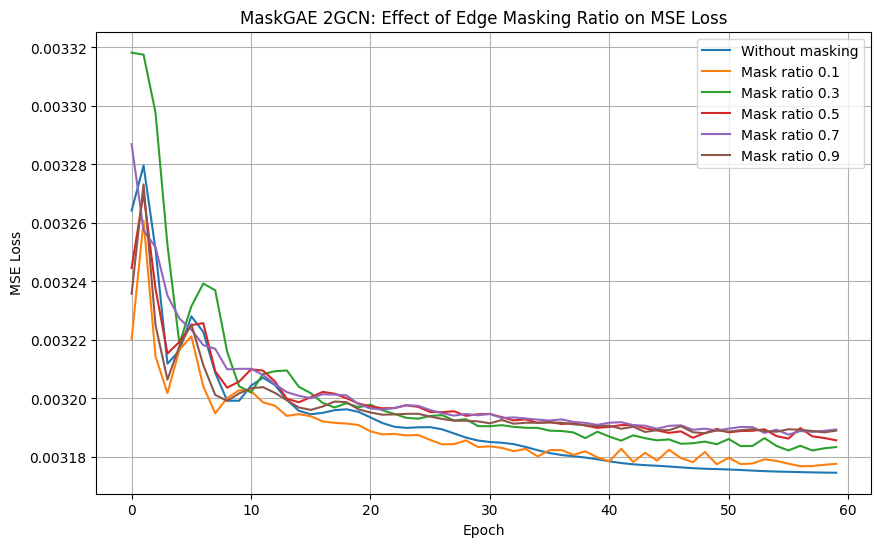

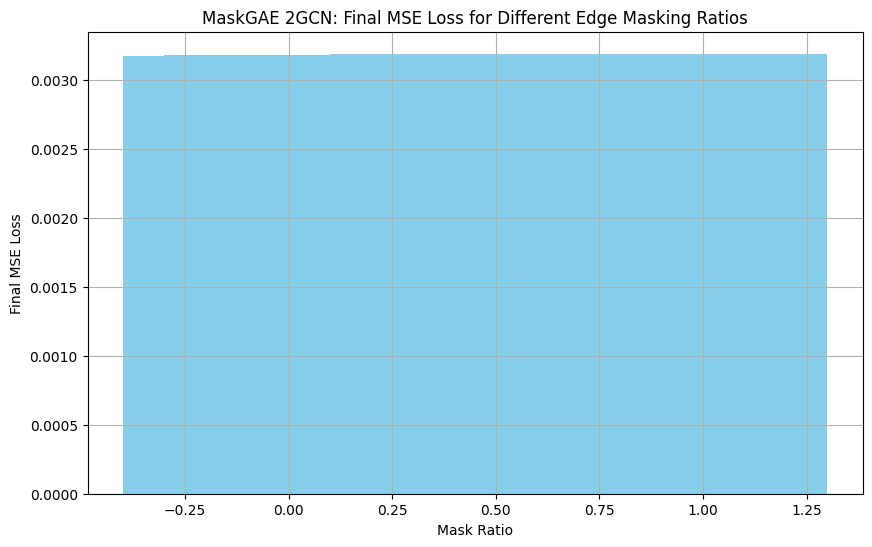

Test Loss: 0.00319423689506948
Test Loss: 0.00319423689506948
Training with mask ratio: 0.0
Epoch 0, Loss: 0.0033223270438611507
Epoch 10, Loss: 0.0032081040553748608
Epoch 20, Loss: 0.003196920035406947
Epoch 30, Loss: 0.003188476897776127
Epoch 40, Loss: 0.003182613290846348
Epoch 50, Loss: 0.0031787012703716755
Training with mask ratio: 0.1
Epoch 0, Loss: 0.0032529234886169434
Epoch 10, Loss: 0.003208627225831151
Epoch 20, Loss: 0.0031943584326654673
Epoch 30, Loss: 0.003189180977642536
Epoch 40, Loss: 0.003186778863891959
Epoch 50, Loss: 0.0031853732652962208
Training with mask ratio: 0.3
Epoch 0, Loss: 0.0033275000751018524
Epoch 10, Loss: 0.0032114791683852673
Epoch 20, Loss: 0.0031996779143810272
Epoch 30, Loss: 0.0031947381794452667
Epoch 40, Loss: 0.003191855037584901
Epoch 50, Loss: 0.0031887157820165157
Training with mask ratio: 0.5
Epoch 0, Loss: 0.0032405834645032883
Epoch 10, Loss: 0.0032062295358628035
Epoch 20, Loss: 0.003194388234987855
Epoch 30, Loss: 0.00319096236489

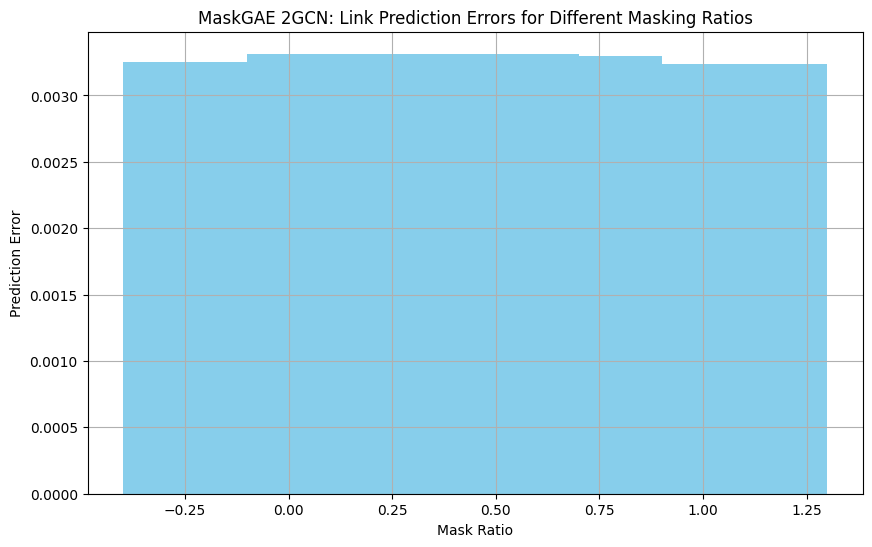

Visualizing encoded features for mask ratio: 0.0


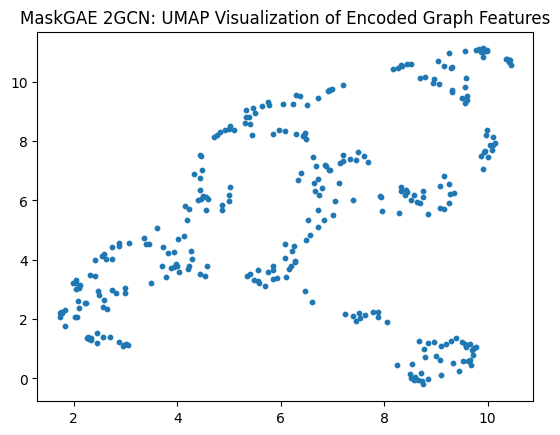

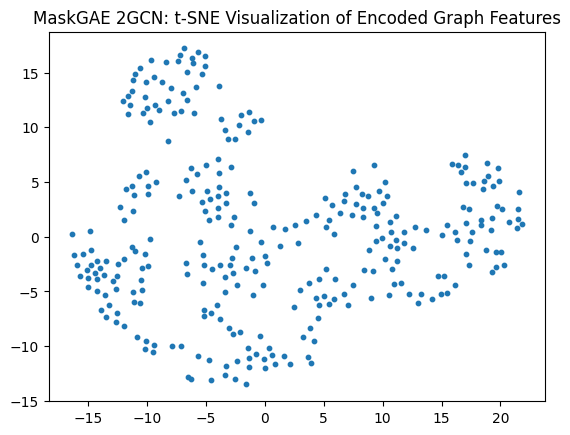

Visualizing encoded features for mask ratio: 0.1


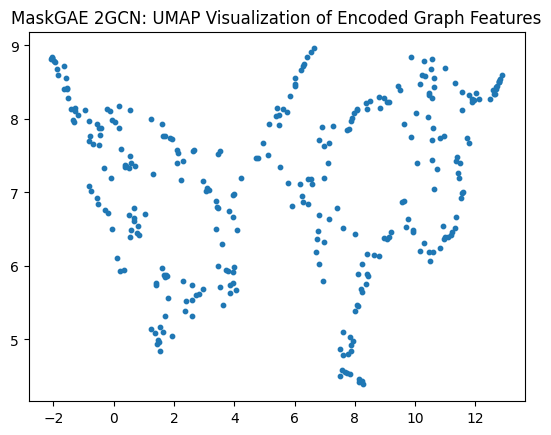

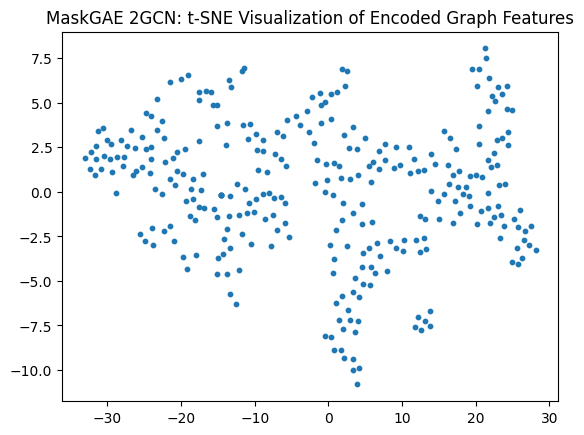

Visualizing encoded features for mask ratio: 0.3


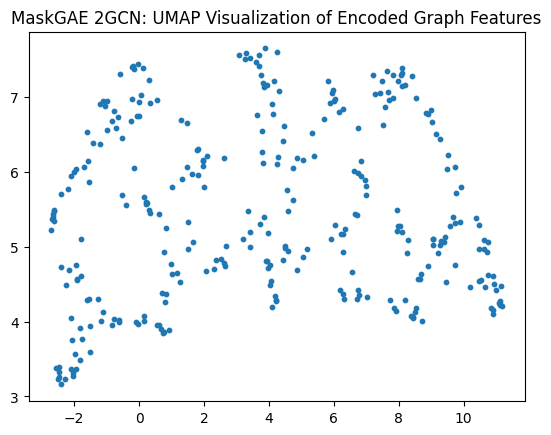

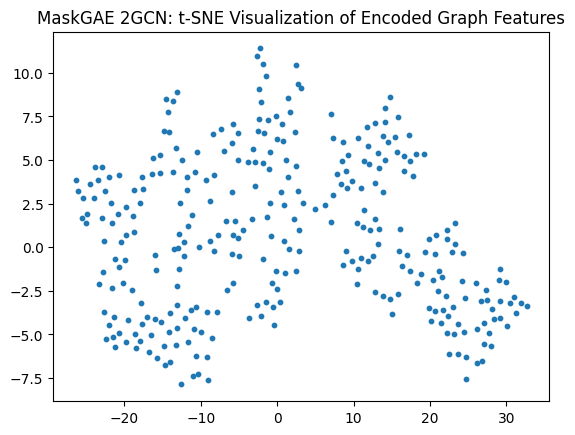

Visualizing encoded features for mask ratio: 0.5


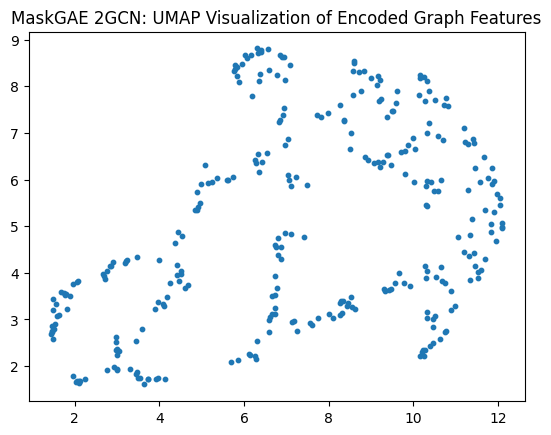

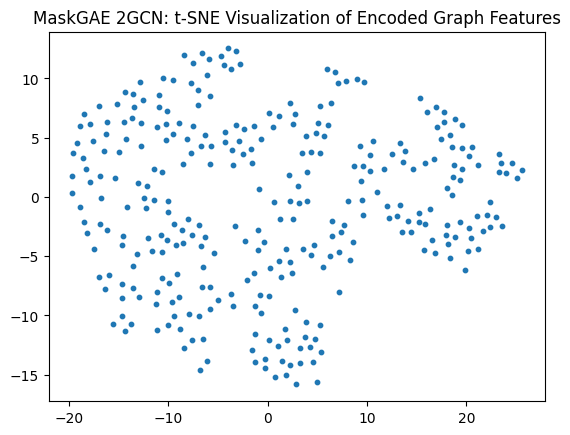

Visualizing encoded features for mask ratio: 0.7


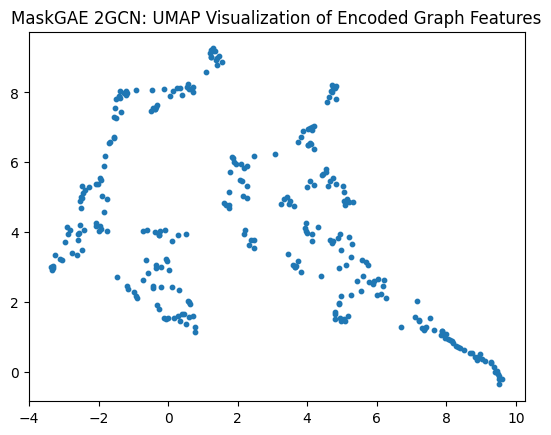

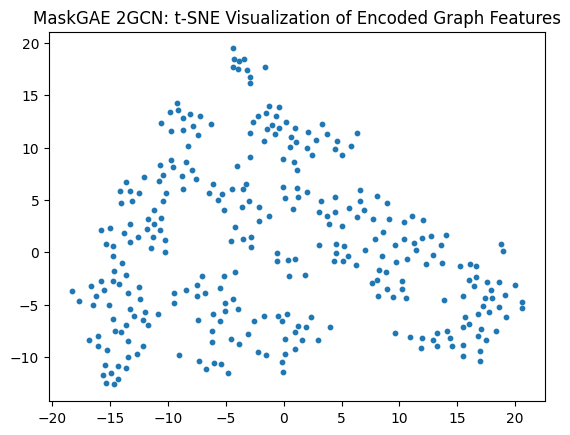

Visualizing encoded features for mask ratio: 0.9


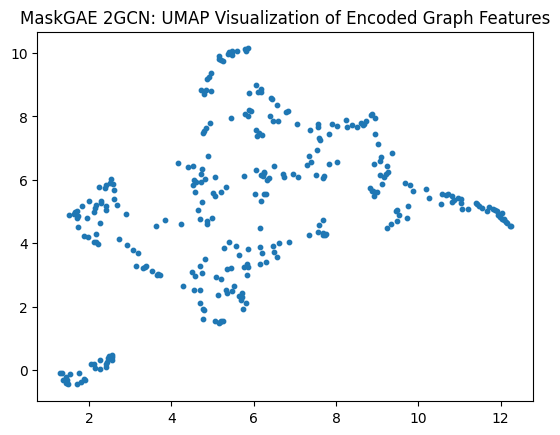

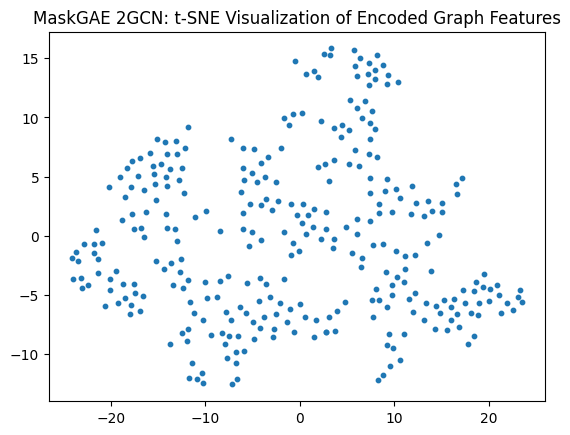

In [ ]:
import torch
import networkx as nx
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import umap
from sklearn.manifold import TSNE
import numpy as np

CUSTOM_EPOCHS = 60

# Generowanie losowego grafu Erdos-Renyi
num_nodes = 312
prob = 0.1
G = nx.erdos_renyi_graph(num_nodes, prob)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
data = Data(x=x, edge_index=edge_index)

## Podział na zbiór treningowy i testowy
def split_edges(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    # Wygenerowanie losowego permutacji indeksów
    perm = torch.randperm(num_edges)
    test_size = int(num_edges * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm[:test_size]]
    train_edge_index = edge_index[:, perm[test_size:]]

    # Utworzenie dwóch obiektów Data: jeden dla treningu, drugi dla testowania
    train_data = Data(x=data.x, edge_index=train_edge_index)
    test_data = Data(x=data.x, edge_index=test_edge_index)

    return train_data, test_data

train_data, test_data = split_edges(data, test_ratio=0.2)

## Implementacja Autoenkodera Grafowego MaskGAE
class MaskGAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MaskGAE, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)
        self.decoder = GCNConv(out_channels, in_channels)

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_index)

## Maskowanie krawędzi
def mask_edges(data, mask_ratio):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    mask_indices = random.sample(range(num_edges), num_mask)
    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

## Trening modelu z użyciem zbioru treningowego i ocena na zbiorze testowym
def train_and_evaluate(in_channels, out_channels, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    criterion = torch.nn.MSELoss()

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        # Inicjalizacja nowego modelu dla każdego mask_ratio
        model = MaskGAE(in_channels=in_channels, out_channels=out_channels)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            out = model(masked_train_data.x, masked_train_data.edge_index)

            loss = criterion(out, train_data.x)  # Loss is computed on the training data
            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

    return results, model

# Funkcja do oceny modelu na zbiorze testowym
def evaluate_on_test(model, test_data):
    model.eval()
    with torch.no_grad():
        z = model.encode(test_data.x, test_data.edge_index)
        out = model.decode(z, test_data.edge_index)
        loss = calculate_prediction_error(out, test_data)
        print(f'Test Loss: {loss}')
        return loss

def calculate_prediction_error(pred, data):
    return torch.nn.functional.mse_loss(pred, data.x).item()

## Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('MaskGAE 2GCN: Effect of Edge Masking Ratio on MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def predict(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        out = model.decode(z, data.edge_index)
        return out, z

def final_loss_comparison(results):
    final_losses = {ratio: losses[-1] for ratio, losses in results.items()}
    ratios = list(final_losses.keys())
    losses = list(final_losses.values())

    plt.figure(figsize=(10, 6))
    plt.bar(ratios, losses, color='skyblue')
    plt.xlabel('Mask Ratio')
    plt.ylabel('Final MSE Loss')
    plt.title('MaskGAE 2GCN: Final MSE Loss for Different Edge Masking Ratios')
    plt.grid(True)
    plt.show()

# Funkcja do wizualizacji UMAP i t-SNE
def visualize_latent_space(z, method='UMAP'):
    if method == 'UMAP':
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
        embedding = reducer.fit_transform(z.detach().cpu().numpy())
        plt.title('MaskGAE 2GCN: UMAP Visualization of Encoded Graph Features')
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
        embedding = reducer.fit_transform(z.detach().cpu().numpy())
        plt.title('MaskGAE 2GCN: t-SNE Visualization of Encoded Graph Features')

    plt.scatter(embedding[:, 0], embedding[:, 1], s=10)
    plt.show()

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]  # Including 0.0 for no masking
results, trained_model = train_and_evaluate(in_channels=train_data.num_features, out_channels=2, train_data=train_data, test_data=test_data, mask_ratios=mask_ratios, epochs=CUSTOM_EPOCHS)
plot_results(results)
final_loss_comparison(results)

# Ewaluacja na zbiorze testowym
test_loss = evaluate_on_test(trained_model, test_data)
print(f"Test Loss: {test_loss}")

# Predykcja na nieolabelowanych danych
unlabeled_data = test_data  # In real scenario, use a different unlabeled dataset

predictions = {}
errors = {}
encoded_representations = {}
for ratio in mask_ratios:
    model = MaskGAE(in_channels=train_data.num_features, out_channels=2)
    train_and_evaluate(train_data.num_features, 2, train_data, test_data, [ratio], epochs=CUSTOM_EPOCHS)
    predictions[ratio], z = predict(model, unlabeled_data)
    errors[ratio] = calculate_prediction_error(predictions[ratio], unlabeled_data)
    encoded_representations[ratio] = z

# Wizualizacja błędów predykcji
plt.figure(figsize=(10, 6))
plt.bar(errors.keys(), errors.values(), color='skyblue')
plt.xlabel('Mask Ratio')
plt.ylabel('Prediction Error')
plt.title('MaskGAE 2GCN: Link Prediction Errors for Different Masking Ratios')
plt.grid(True)
plt.show()

# Wizualizacja zakodowanych reprezentacji z użyciem UMAP i t-SNE
for ratio, z in encoded_representations.items():
    print(f"Visualizing encoded features for mask ratio: {ratio}")

    # UMAP
    visualize_latent_space(z, method='UMAP')

    # t-SNE
    visualize_latent_space(z, method='t-SNE')


## Klasyfikacja społeczności


Training with mask ratio: 0.0
Epoch 0, Loss: 1.212227463722229
Epoch 10, Loss: 1.111769676208496
Epoch 20, Loss: 0.9526639580726624
Epoch 30, Loss: 0.7409966588020325
Epoch 40, Loss: 0.5600368976593018
Epoch 50, Loss: 0.4506589472293854
Epoch 60, Loss: 0.3675805330276489
Epoch 70, Loss: 0.28689172863960266
Epoch 80, Loss: 0.21108464896678925
Epoch 90, Loss: 0.14910319447517395
Epoch 100, Loss: 0.10519655793905258
Epoch 110, Loss: 0.07572095841169357
Epoch 120, Loss: 0.05560185760259628
Epoch 130, Loss: 0.04172712191939354
Epoch 140, Loss: 0.03208215907216072
Classification Accuracy for mask ratio 0.0: 0.6481481481481481
Training with mask ratio: 0.1
Epoch 0, Loss: 1.223393440246582
Epoch 10, Loss: 1.1335235834121704
Epoch 20, Loss: 1.0220369100570679
Epoch 30, Loss: 0.8876217603683472
Epoch 40, Loss: 0.7171053886413574
Epoch 50, Loss: 0.5819348692893982
Epoch 60, Loss: 0.49278196692466736
Epoch 70, Loss: 0.42872005701065063
Epoch 80, Loss: 0.36709022521972656
Epoch 90, Loss: 0.29271301

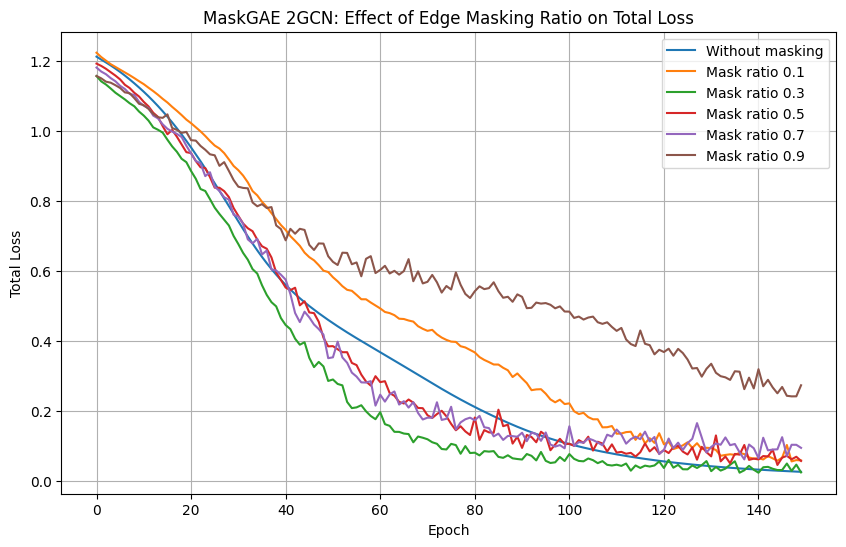

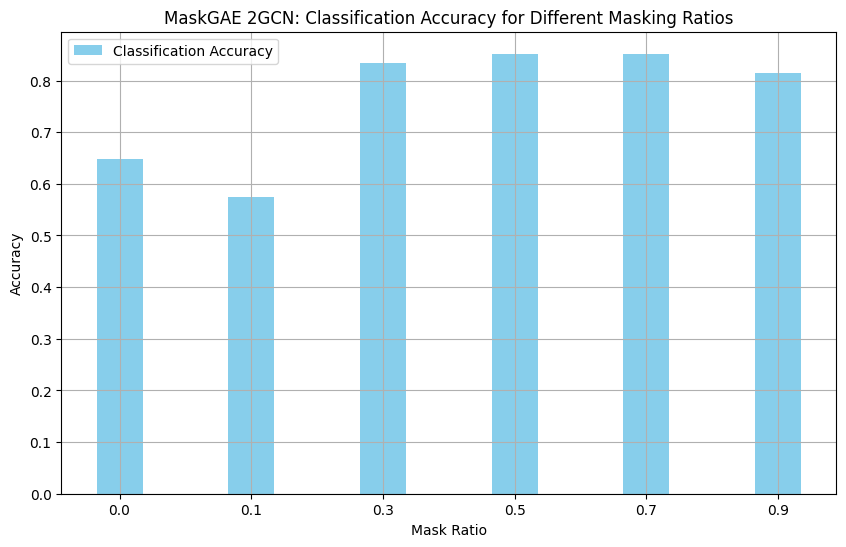

In [ ]:
import torch
import networkx as nx
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import numpy as np

CUSTOM_EPOCHS = 150

# Generowanie grafu za pomocą Stochastic Block Model (SBM)
num_nodes = 270
sizes = [90, 90, 90]  # Liczba węzłów w każdej społeczności (bloku)
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.25]]  # Macierz prawdopodobieństw krawędzi między społecznościami
G = nx.stochastic_block_model(sizes, probs)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
labels = torch.zeros(num_nodes, dtype=torch.long)

# Przydzielanie etykiet węzłom na podstawie społeczności
for i, size in enumerate(sizes):
    labels[sum(sizes[:i]):sum(sizes[:i+1])] = i

data = Data(x=x, edge_index=edge_index, y=labels)

# Podział na zbiór treningowy i testowy
def split_edges_and_nodes(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    num_nodes = data.num_nodes

    # Wygenerowanie losowego permutacji indeksów
    perm_edges = torch.randperm(num_edges)
    perm_nodes = torch.randperm(num_nodes)
    test_size_edges = int(num_edges * test_ratio)
    test_size_nodes = int(num_nodes * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm_edges[:test_size_edges]]
    train_edge_index = edge_index[:, perm_edges[test_size_edges:]]
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[perm_nodes[test_size_nodes:]] = True
    test_mask[perm_nodes[:test_size_nodes]] = True

    train_data = Data(x=data.x, edge_index=train_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)
    test_data = Data(x=data.x, edge_index=test_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)

    return train_data, test_data

train_data, test_data = split_edges_and_nodes(data, test_ratio=0.2)

# Implementacja Autoenkodera Grafowego MaskGAE z klasyfikacją węzłów
class MaskGAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(MaskGAE, self).__init__()

        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

        self.classifier = nn.Linear(out_channels, num_classes)  # Warstwa klasyfikacyjna

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

    def classify(self, z):
        # Klasyfikacja węzłów
        return self.classifier(z)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return self.classify(z)

# Funkcja do maskowania krawędzi
def mask_edges(data, mask_ratio):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    mask_indices = random.sample(range(num_edges), num_mask)
    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

# Trening modelu z klasyfikacją węzłów
def train_and_evaluate(in_channels, out_channels, num_classes, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    accuracies = {}
    criterion_classification = torch.nn.CrossEntropyLoss()
    models = {}  # Store trained models for each mask ratio

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        model = MaskGAE(in_channels=in_channels, out_channels=out_channels, num_classes=num_classes)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            logits = model(masked_train_data.x, masked_train_data.edge_index)

            loss_classification = criterion_classification(logits[train_data.train_mask], train_data.y[train_data.train_mask])
            loss_classification.backward()
            optimizer.step()

            results[ratio].append(loss_classification.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss_classification.item()}')

        # Evaluate classification accuracy on test data
        model.eval()
        with torch.no_grad():
            logits = model(test_data.x, test_data.edge_index)
            predicted_classes = logits.argmax(dim=1)
            correct = (predicted_classes[test_data.test_mask] == test_data.y[test_data.test_mask]).sum().item()
            accuracy = correct / test_data.test_mask.sum().item()
            accuracies[ratio] = accuracy
            print(f'Classification Accuracy for mask ratio {ratio}: {accuracy}')

        models[ratio] = model  # Save the trained model for this ratio

    return results, models, accuracies

# Funkcja do predykcji
def predict(model, data):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        return logits

# Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('MaskGAE 2GCN: Effect of Edge Masking Ratio on Total Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
results, trained_models, accuracies = train_and_evaluate(
    in_channels=train_data.num_features,
    out_channels=2,
    num_classes=len(sizes),
    train_data=train_data,
    test_data=test_data,
    mask_ratios=mask_ratios,
    epochs=CUSTOM_EPOCHS
)

# Plot the loss results
plot_results(results)

# Plot classification accuracy for each mask ratio
plt.figure(figsize=(10, 6))
index = np.arange(len(accuracies))
bar_width = 0.35

plt.bar(index, list(accuracies.values()), width=bar_width, color='skyblue', label='Classification Accuracy')
plt.xlabel('Mask Ratio')
plt.ylabel('Accuracy')
plt.title('MaskGAE 2GCN: Classification Accuracy for Different Masking Ratios')
plt.xticks(index, [str(ratio) for ratio in accuracies.keys()])
plt.legend()
plt.grid(True)
plt.show()


## 500 węzłów - Przewidywanie połaczeń

Training with mask ratio: 0.0
Epoch 0, Loss: 0.0016076230676844716
Epoch 10, Loss: 0.0016132217133417726
Epoch 20, Loss: 0.0015990380197763443
Epoch 30, Loss: 0.0015971111133694649
Epoch 40, Loss: 0.001595227513462305
Epoch 50, Loss: 0.0015939860604703426
Training with mask ratio: 0.1
Epoch 0, Loss: 0.0016066982643678784
Epoch 10, Loss: 0.0016141454689204693
Epoch 20, Loss: 0.0016006225487217307
Epoch 30, Loss: 0.001598429400473833
Epoch 40, Loss: 0.0015972265973687172
Epoch 50, Loss: 0.0015965135535225272
Training with mask ratio: 0.3
Epoch 0, Loss: 0.001605403609573841
Epoch 10, Loss: 0.0016131933080032468
Epoch 20, Loss: 0.0016000540927052498
Epoch 30, Loss: 0.0015982550103217363
Epoch 40, Loss: 0.0015970715321600437
Epoch 50, Loss: 0.001596124260686338
Training with mask ratio: 0.5
Epoch 0, Loss: 0.0016880349721759558
Epoch 10, Loss: 0.001612500986084342
Epoch 20, Loss: 0.0016019652830436826
Epoch 30, Loss: 0.001599574345164001
Epoch 40, Loss: 0.0015977495349943638
Epoch 50, Loss: 

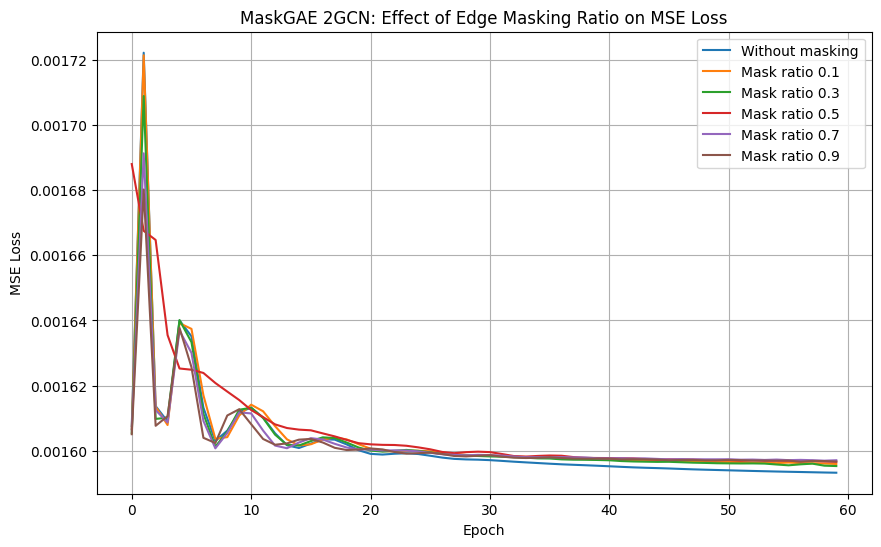

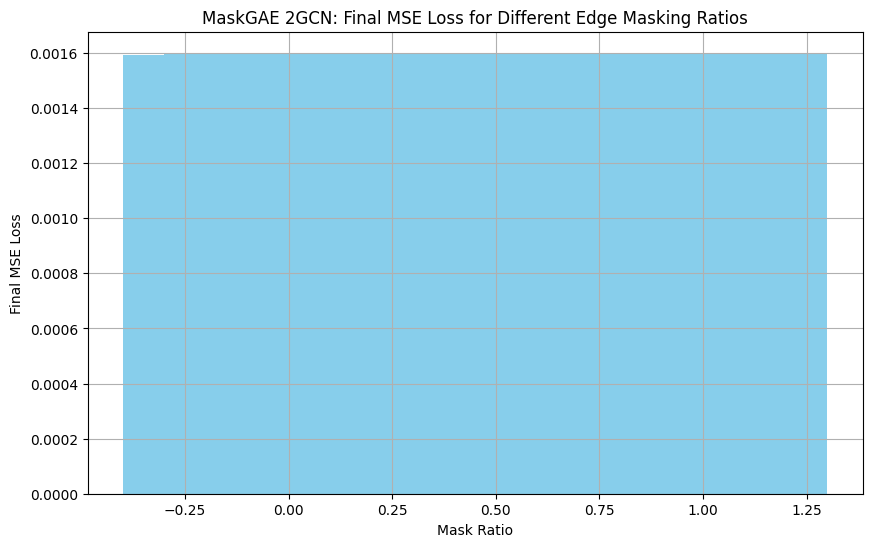

Test Loss: 0.0015972215915098786
Test Loss: 0.0015972215915098786
Training with mask ratio: 0.0
Epoch 0, Loss: 0.0016130582662299275
Epoch 10, Loss: 0.0016113916644826531
Epoch 20, Loss: 0.001598772476427257
Epoch 30, Loss: 0.001597006106749177
Epoch 40, Loss: 0.001595298876054585
Epoch 50, Loss: 0.0015937703428789973
Training with mask ratio: 0.1
Epoch 0, Loss: 0.0016242810525000095
Epoch 10, Loss: 0.001611691084690392
Epoch 20, Loss: 0.0016008579405024648
Epoch 30, Loss: 0.0015981040196493268
Epoch 40, Loss: 0.001597145339474082
Epoch 50, Loss: 0.0015961334574967623
Training with mask ratio: 0.3
Epoch 0, Loss: 0.0016052324790507555
Epoch 10, Loss: 0.0016128189163282514
Epoch 20, Loss: 0.0016009469982236624
Epoch 30, Loss: 0.0015986054204404354
Epoch 40, Loss: 0.0015978662995621562
Epoch 50, Loss: 0.0015973304398357868
Training with mask ratio: 0.5
Epoch 0, Loss: 0.0016284823650494218
Epoch 10, Loss: 0.0016098655760288239
Epoch 20, Loss: 0.0016000780742615461
Epoch 30, Loss: 0.0015986

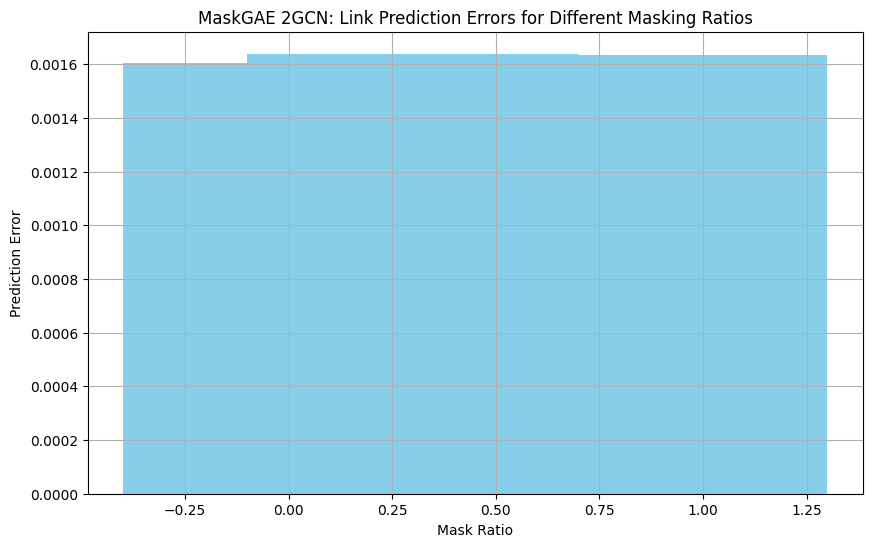

Visualizing encoded features for mask ratio: 0.0


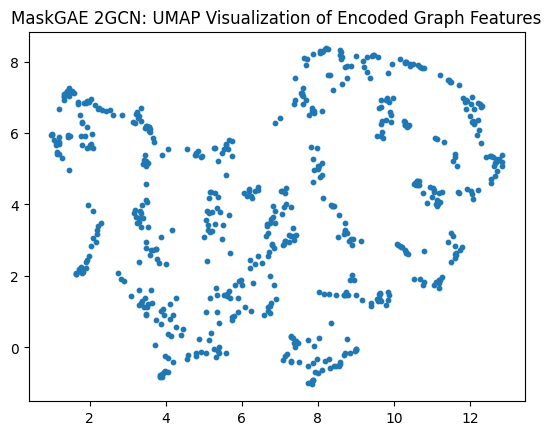

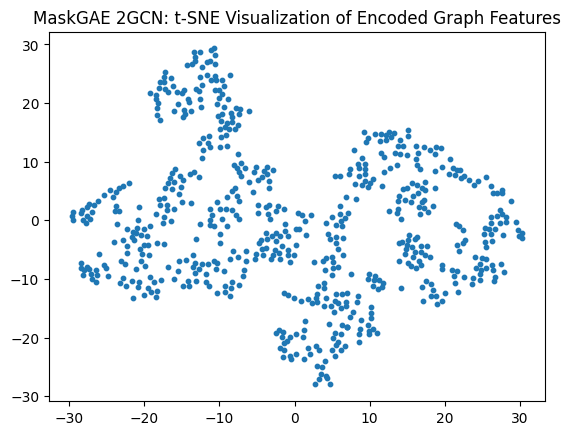

Visualizing encoded features for mask ratio: 0.1


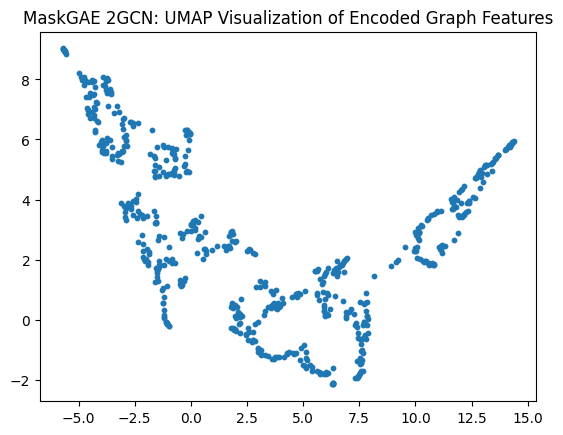

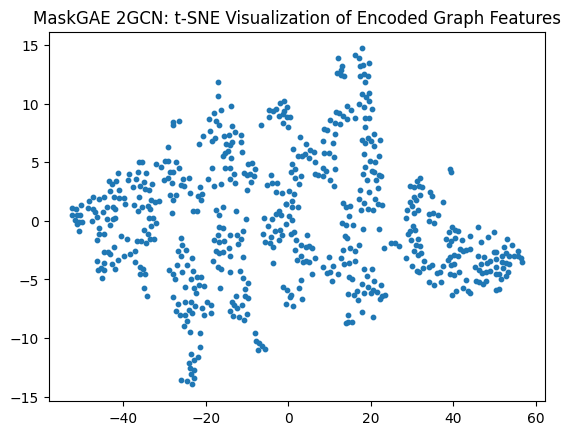

Visualizing encoded features for mask ratio: 0.3


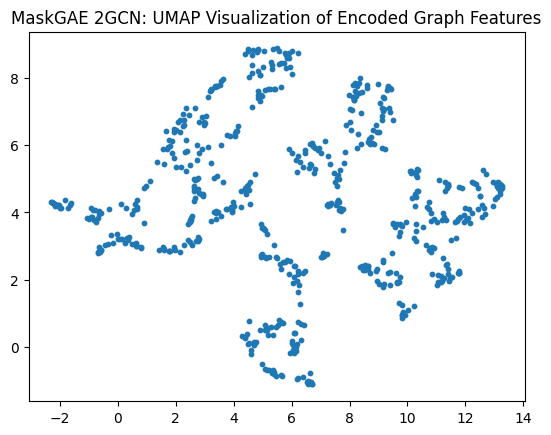

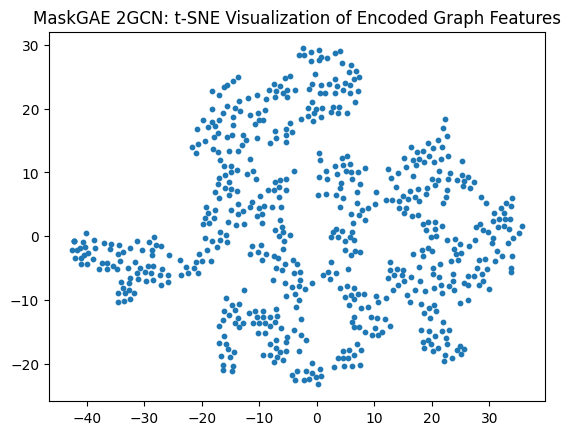

Visualizing encoded features for mask ratio: 0.5


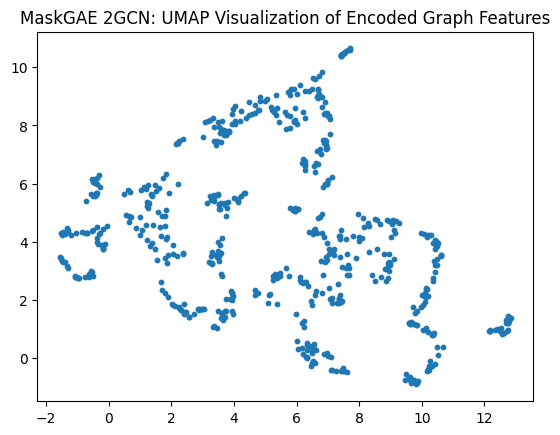

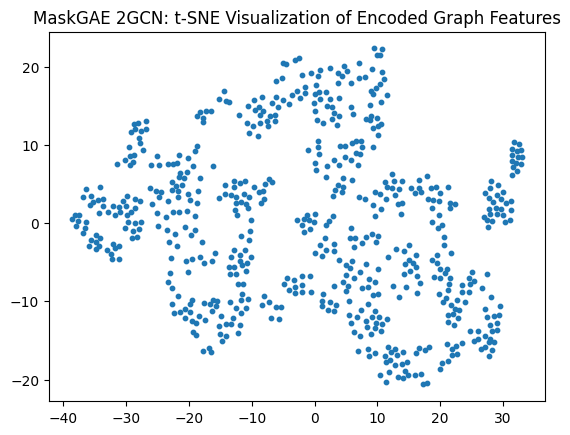

Visualizing encoded features for mask ratio: 0.7


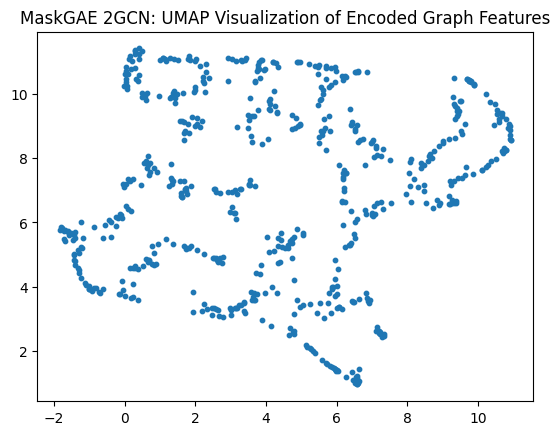

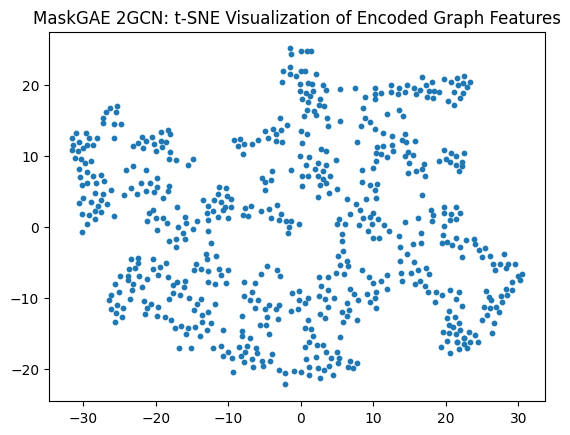

Visualizing encoded features for mask ratio: 0.9


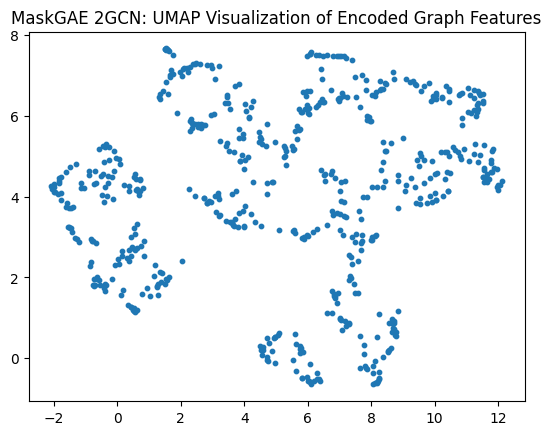

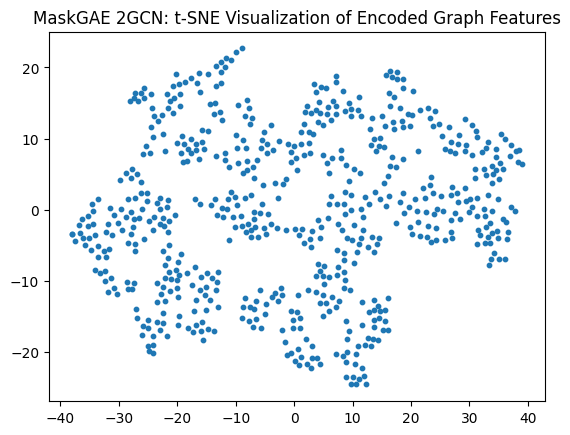

In [ ]:
import torch
import networkx as nx
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import umap
from sklearn.manifold import TSNE
import numpy as np

CUSTOM_EPOCHS = 60

# Generowanie losowego grafu Erdos-Renyi
num_nodes = 625
prob = 0.1
G = nx.erdos_renyi_graph(num_nodes, prob)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
data = Data(x=x, edge_index=edge_index)

## Podział na zbiór treningowy i testowy
def split_edges(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    # Wygenerowanie losowego permutacji indeksów
    perm = torch.randperm(num_edges)
    test_size = int(num_edges * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm[:test_size]]
    train_edge_index = edge_index[:, perm[test_size:]]

    # Utworzenie dwóch obiektów Data: jeden dla treningu, drugi dla testowania
    train_data = Data(x=data.x, edge_index=train_edge_index)
    test_data = Data(x=data.x, edge_index=test_edge_index)

    return train_data, test_data

train_data, test_data = split_edges(data, test_ratio=0.2)

## Implementacja Autoenkodera Grafowego MaskGAE
class MaskGAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MaskGAE, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)
        self.decoder = GCNConv(out_channels, in_channels)

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_index)

## Maskowanie krawędzi
def mask_edges(data, mask_ratio):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    mask_indices = random.sample(range(num_edges), num_mask)
    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

## Trening modelu z użyciem zbioru treningowego i ocena na zbiorze testowym
def train_and_evaluate(in_channels, out_channels, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    criterion = torch.nn.MSELoss()

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        # Inicjalizacja nowego modelu dla każdego mask_ratio
        model = MaskGAE(in_channels=in_channels, out_channels=out_channels)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            out = model(masked_train_data.x, masked_train_data.edge_index)

            loss = criterion(out, train_data.x)  # Loss is computed on the training data
            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

    return results, model

# Funkcja do oceny modelu na zbiorze testowym
def evaluate_on_test(model, test_data):
    model.eval()
    with torch.no_grad():
        z = model.encode(test_data.x, test_data.edge_index)
        out = model.decode(z, test_data.edge_index)
        loss = calculate_prediction_error(out, test_data)
        print(f'Test Loss: {loss}')
        return loss

def calculate_prediction_error(pred, data):
    return torch.nn.functional.mse_loss(pred, data.x).item()

## Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('MaskGAE 2GCN: Effect of Edge Masking Ratio on MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def predict(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        out = model.decode(z, data.edge_index)
        return out, z

def final_loss_comparison(results):
    final_losses = {ratio: losses[-1] for ratio, losses in results.items()}
    ratios = list(final_losses.keys())
    losses = list(final_losses.values())

    plt.figure(figsize=(10, 6))
    plt.bar(ratios, losses, color='skyblue')
    plt.xlabel('Mask Ratio')
    plt.ylabel('Final MSE Loss')
    plt.title('MaskGAE 2GCN: Final MSE Loss for Different Edge Masking Ratios')
    plt.grid(True)
    plt.show()

# Funkcja do wizualizacji UMAP i t-SNE
def visualize_latent_space(z, method='UMAP'):
    if method == 'UMAP':
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
        embedding = reducer.fit_transform(z.detach().cpu().numpy())
        plt.title('MaskGAE 2GCN: UMAP Visualization of Encoded Graph Features')
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
        embedding = reducer.fit_transform(z.detach().cpu().numpy())
        plt.title('MaskGAE 2GCN: t-SNE Visualization of Encoded Graph Features')

    plt.scatter(embedding[:, 0], embedding[:, 1], s=10)
    plt.show()

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]  # Including 0.0 for no masking
results, trained_model = train_and_evaluate(in_channels=train_data.num_features, out_channels=2, train_data=train_data, test_data=test_data, mask_ratios=mask_ratios, epochs=CUSTOM_EPOCHS)
plot_results(results)
final_loss_comparison(results)

# Ewaluacja na zbiorze testowym
test_loss = evaluate_on_test(trained_model, test_data)
print(f"Test Loss: {test_loss}")

# Predykcja na nieolabelowanych danych
unlabeled_data = test_data  # In real scenario, use a different unlabeled dataset

predictions = {}
errors = {}
encoded_representations = {}
for ratio in mask_ratios:
    model = MaskGAE(in_channels=train_data.num_features, out_channels=2)
    train_and_evaluate(train_data.num_features, 2, train_data, test_data, [ratio], epochs=CUSTOM_EPOCHS)
    predictions[ratio], z = predict(model, unlabeled_data)
    errors[ratio] = calculate_prediction_error(predictions[ratio], unlabeled_data)
    encoded_representations[ratio] = z

# Wizualizacja błędów predykcji
plt.figure(figsize=(10, 6))
plt.bar(errors.keys(), errors.values(), color='skyblue')
plt.xlabel('Mask Ratio')
plt.ylabel('Prediction Error')
plt.title('MaskGAE 2GCN: Link Prediction Errors for Different Masking Ratios')
plt.grid(True)
plt.show()

# Wizualizacja zakodowanych reprezentacji z użyciem UMAP i t-SNE
for ratio, z in encoded_representations.items():
    print(f"Visualizing encoded features for mask ratio: {ratio}")

    # UMAP
    visualize_latent_space(z, method='UMAP')

    # t-SNE
    visualize_latent_space(z, method='t-SNE')


## Klasyfikacja społeczności

Training with mask ratio: 0.0
Epoch 0, Loss: 1.1223127841949463
Epoch 10, Loss: 1.0366231203079224
Epoch 20, Loss: 0.9075844883918762
Epoch 30, Loss: 0.7153254151344299
Epoch 40, Loss: 0.5037986040115356
Epoch 50, Loss: 0.32538938522338867
Epoch 60, Loss: 0.2070295363664627
Epoch 70, Loss: 0.13740088045597076
Epoch 80, Loss: 0.09678570181131363
Epoch 90, Loss: 0.07189782708883286
Epoch 100, Loss: 0.05558858439326286
Epoch 110, Loss: 0.0442081019282341
Epoch 120, Loss: 0.03589547798037529
Epoch 130, Loss: 0.029610395431518555
Epoch 140, Loss: 0.024768041446805
Classification Accuracy for mask ratio 0.0: 0.6547619047619048
Training with mask ratio: 0.1
Epoch 0, Loss: 1.1023521423339844
Epoch 10, Loss: 1.060001254081726
Epoch 20, Loss: 0.9514555335044861
Epoch 30, Loss: 0.7528920769691467
Epoch 40, Loss: 0.5020107626914978
Epoch 50, Loss: 0.30722248554229736
Epoch 60, Loss: 0.1872047781944275
Epoch 70, Loss: 0.11587842553853989
Epoch 80, Loss: 0.08344563841819763
Epoch 90, Loss: 0.0647354

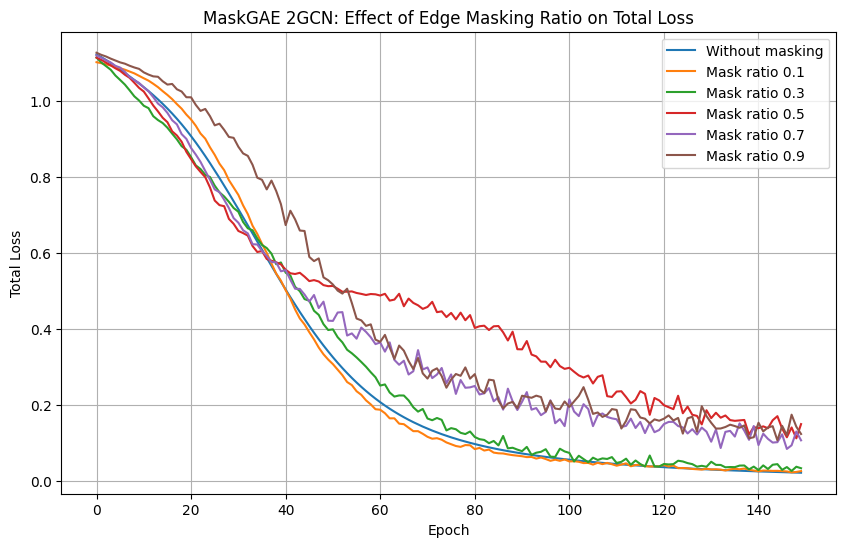

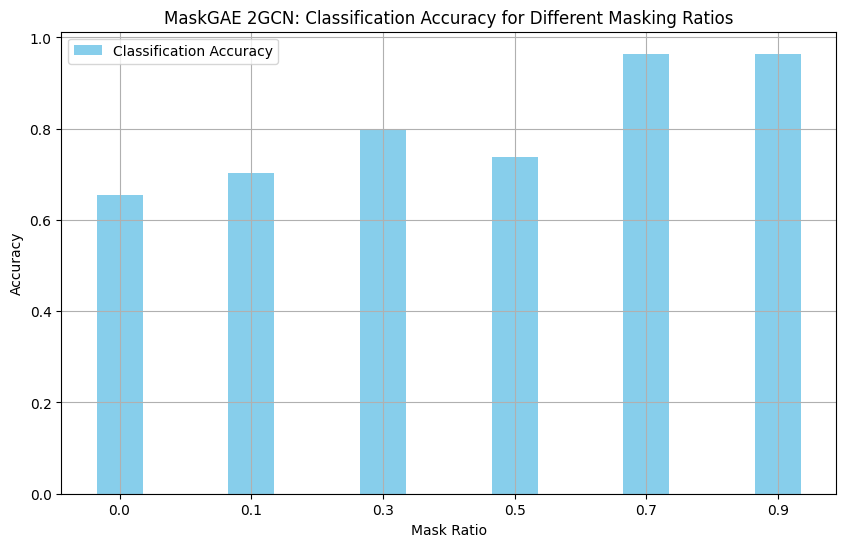

In [ ]:
import torch
import networkx as nx
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import numpy as np

CUSTOM_EPOCHS = 150

# Generowanie grafu za pomocą Stochastic Block Model (SBM)
num_nodes = 423
sizes = [141, 141, 141]  # Liczba węzłów w każdej społeczności (bloku)
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.25]]  # Macierz prawdopodobieństw krawędzi między społecznościami
G = nx.stochastic_block_model(sizes, probs)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
labels = torch.zeros(num_nodes, dtype=torch.long)

# Przydzielanie etykiet węzłom na podstawie społeczności
for i, size in enumerate(sizes):
    labels[sum(sizes[:i]):sum(sizes[:i+1])] = i

data = Data(x=x, edge_index=edge_index, y=labels)

# Podział na zbiór treningowy i testowy
def split_edges_and_nodes(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    num_nodes = data.num_nodes

    # Wygenerowanie losowego permutacji indeksów
    perm_edges = torch.randperm(num_edges)
    perm_nodes = torch.randperm(num_nodes)
    test_size_edges = int(num_edges * test_ratio)
    test_size_nodes = int(num_nodes * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm_edges[:test_size_edges]]
    train_edge_index = edge_index[:, perm_edges[test_size_edges:]]
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[perm_nodes[test_size_nodes:]] = True
    test_mask[perm_nodes[:test_size_nodes]] = True

    train_data = Data(x=data.x, edge_index=train_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)
    test_data = Data(x=data.x, edge_index=test_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)

    return train_data, test_data

train_data, test_data = split_edges_and_nodes(data, test_ratio=0.2)

# Implementacja Autoenkodera Grafowego MaskGAE z klasyfikacją węzłów
class MaskGAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(MaskGAE, self).__init__()

        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

        self.classifier = nn.Linear(out_channels, num_classes)  # Warstwa klasyfikacyjna

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

    def classify(self, z):
        # Klasyfikacja węzłów
        return self.classifier(z)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return self.classify(z)

# Funkcja do maskowania krawędzi
def mask_edges(data, mask_ratio):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    mask_indices = random.sample(range(num_edges), num_mask)
    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

# Trening modelu z klasyfikacją węzłów
def train_and_evaluate(in_channels, out_channels, num_classes, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    accuracies = {}
    criterion_classification = torch.nn.CrossEntropyLoss()
    models = {}  # Store trained models for each mask ratio

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        model = MaskGAE(in_channels=in_channels, out_channels=out_channels, num_classes=num_classes)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            logits = model(masked_train_data.x, masked_train_data.edge_index)

            loss_classification = criterion_classification(logits[train_data.train_mask], train_data.y[train_data.train_mask])
            loss_classification.backward()
            optimizer.step()

            results[ratio].append(loss_classification.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss_classification.item()}')

        # Evaluate classification accuracy on test data
        model.eval()
        with torch.no_grad():
            logits = model(test_data.x, test_data.edge_index)
            predicted_classes = logits.argmax(dim=1)
            correct = (predicted_classes[test_data.test_mask] == test_data.y[test_data.test_mask]).sum().item()
            accuracy = correct / test_data.test_mask.sum().item()
            accuracies[ratio] = accuracy
            print(f'Classification Accuracy for mask ratio {ratio}: {accuracy}')

        models[ratio] = model  # Save the trained model for this ratio

    return results, models, accuracies

# Funkcja do predykcji
def predict(model, data):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        return logits

# Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('MaskGAE 2GCN: Effect of Edge Masking Ratio on Total Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
results, trained_models, accuracies = train_and_evaluate(
    in_channels=train_data.num_features,
    out_channels=2,
    num_classes=len(sizes),
    train_data=train_data,
    test_data=test_data,
    mask_ratios=mask_ratios,
    epochs=CUSTOM_EPOCHS
)

# Plot the loss results
plot_results(results)

# Plot classification accuracy for each mask ratio
plt.figure(figsize=(10, 6))
index = np.arange(len(accuracies))
bar_width = 0.35

plt.bar(index, list(accuracies.values()), width=bar_width, color='skyblue', label='Classification Accuracy')
plt.xlabel('Mask Ratio')
plt.ylabel('Accuracy')
plt.title('MaskGAE 2GCN: Classification Accuracy for Different Masking Ratios')
plt.xticks(index, [str(ratio) for ratio in accuracies.keys()])
plt.legend()
plt.grid(True)
plt.show()


# Graf losowy syntetyczny - MaskGAE 2GCNConv 4MLP

## 250 węzłów - Przewidywanie połaczeń

Training with mask ratio: 0.0
Epoch 0, Loss: 0.23969975113868713
Epoch 10, Loss: 0.08470799028873444
Epoch 20, Loss: 0.03696805238723755
Epoch 30, Loss: 0.017416220158338547
Epoch 40, Loss: 0.010074226185679436
Training with mask ratio: 0.1
Epoch 0, Loss: 0.18476909399032593
Epoch 10, Loss: 0.08161376416683197
Epoch 20, Loss: 0.034216348081827164
Epoch 30, Loss: 0.014812169596552849
Epoch 40, Loss: 0.008548576384782791
Training with mask ratio: 0.3
Epoch 0, Loss: 0.2448820322751999
Epoch 10, Loss: 0.08902047574520111
Epoch 20, Loss: 0.03434915840625763
Epoch 30, Loss: 0.01488671638071537
Epoch 40, Loss: 0.008872032165527344
Training with mask ratio: 0.5
Epoch 0, Loss: 0.23380237817764282
Epoch 10, Loss: 0.0876321941614151
Epoch 20, Loss: 0.036215342581272125
Epoch 30, Loss: 0.016447298228740692
Epoch 40, Loss: 0.009388289414346218
Training with mask ratio: 0.7
Epoch 0, Loss: 0.32017454504966736
Epoch 10, Loss: 0.09153524786233902
Epoch 20, Loss: 0.02958010695874691
Epoch 30, Loss: 0.01

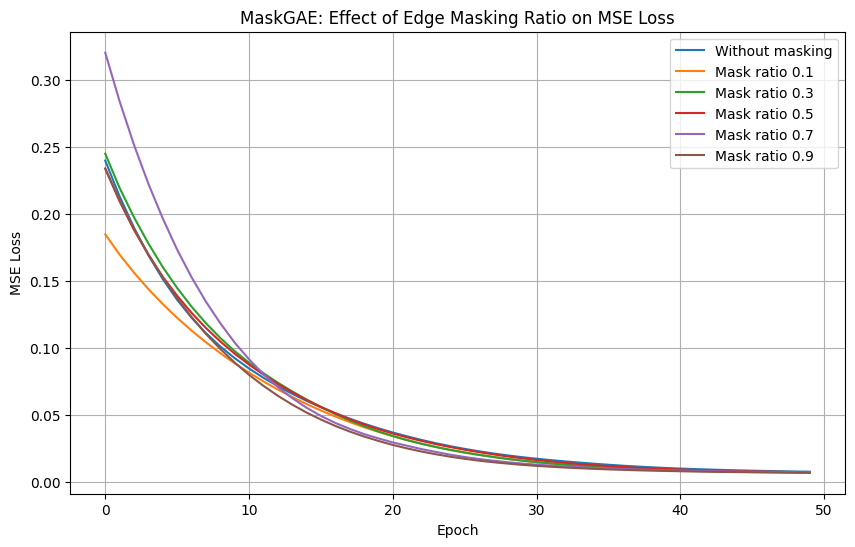

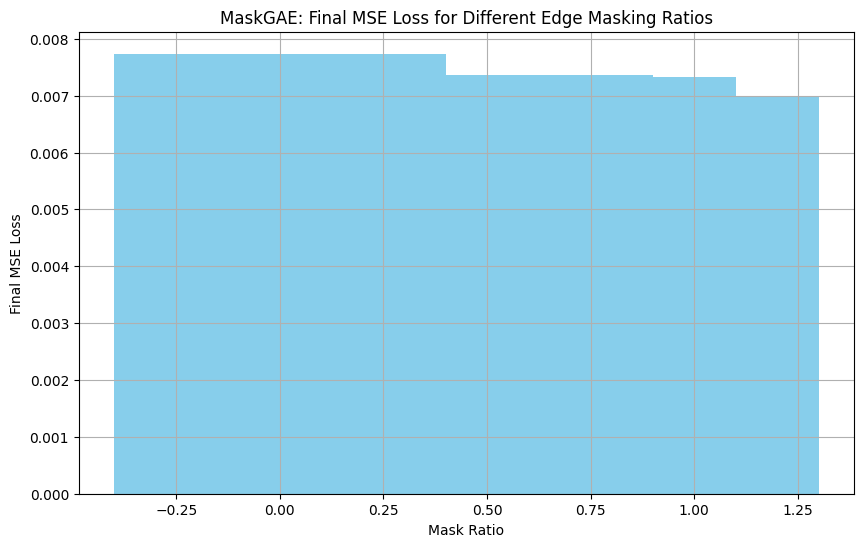

Test Structure Error: 0.003527973545715213, Test Degree Error: 0.0034391728695482016
Test Loss: (0.003527973545715213, 0.0034391728695482016)
Training with mask ratio: 0.0
Epoch 0, Loss: 0.2069803923368454
Epoch 10, Loss: 0.075181744992733
Epoch 20, Loss: 0.027719054371118546
Epoch 30, Loss: 0.012189511209726334
Epoch 40, Loss: 0.008076070807874203
Training with mask ratio: 0.1
Epoch 0, Loss: 0.1757388710975647
Epoch 10, Loss: 0.09025216102600098
Epoch 20, Loss: 0.042136430740356445
Epoch 30, Loss: 0.018741391599178314
Epoch 40, Loss: 0.009879399091005325
Training with mask ratio: 0.3
Epoch 0, Loss: 0.20657415688037872
Epoch 10, Loss: 0.07945188134908676
Epoch 20, Loss: 0.028736887499690056
Epoch 30, Loss: 0.012125115841627121
Epoch 40, Loss: 0.00799056887626648
Training with mask ratio: 0.5
Epoch 0, Loss: 0.23436638712882996
Epoch 10, Loss: 0.09488915652036667
Epoch 20, Loss: 0.0360216423869133
Epoch 30, Loss: 0.015365677885711193
Epoch 40, Loss: 0.009108193218708038
Training with mas

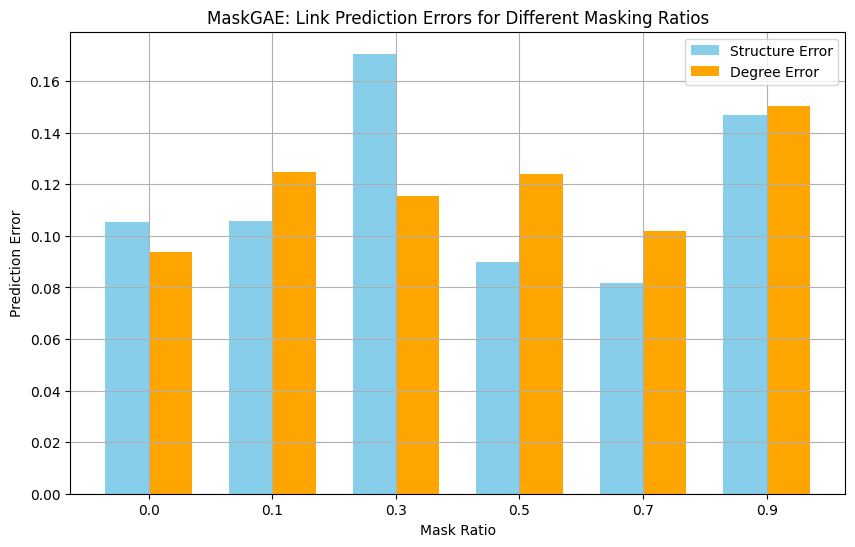

MaskGAE: Visualizing encoded features for mask ratio: 0.0


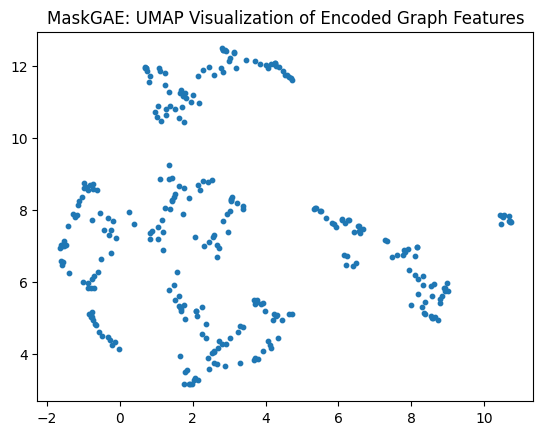

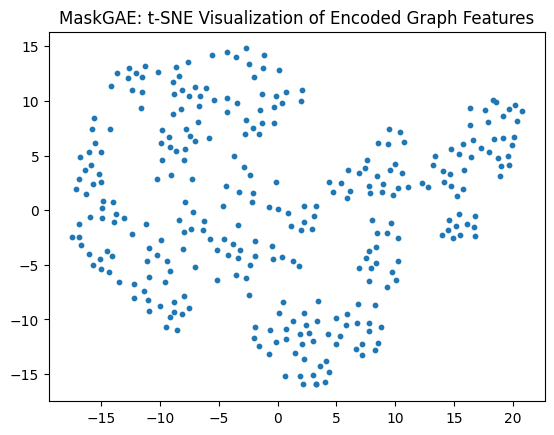

MaskGAE: Visualizing encoded features for mask ratio: 0.1


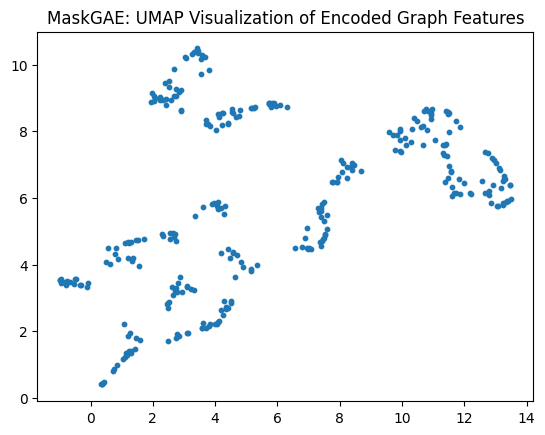

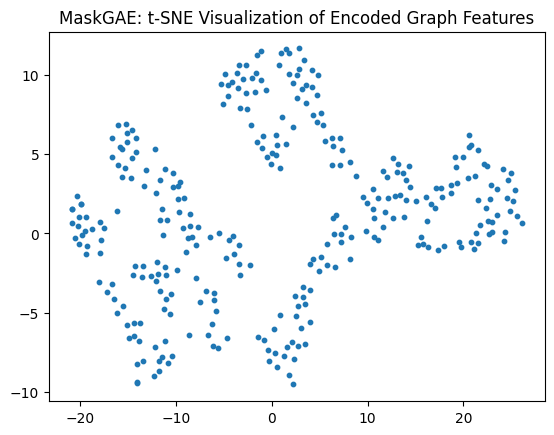

MaskGAE: Visualizing encoded features for mask ratio: 0.3


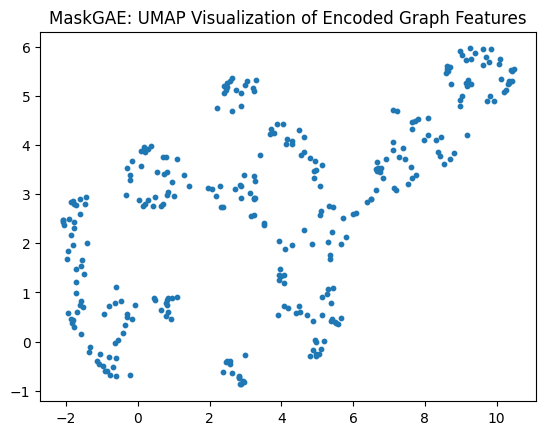

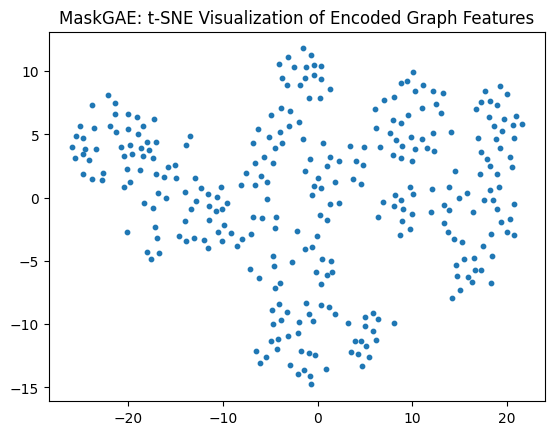

MaskGAE: Visualizing encoded features for mask ratio: 0.5


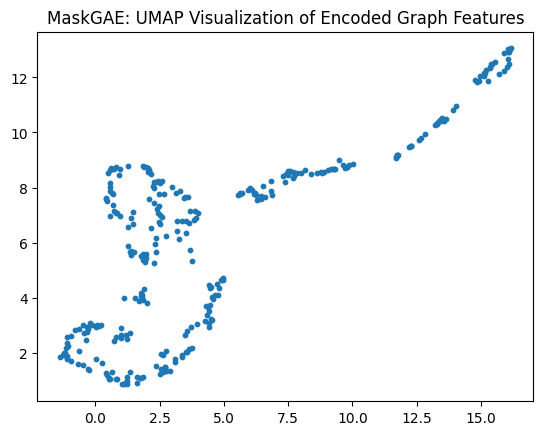

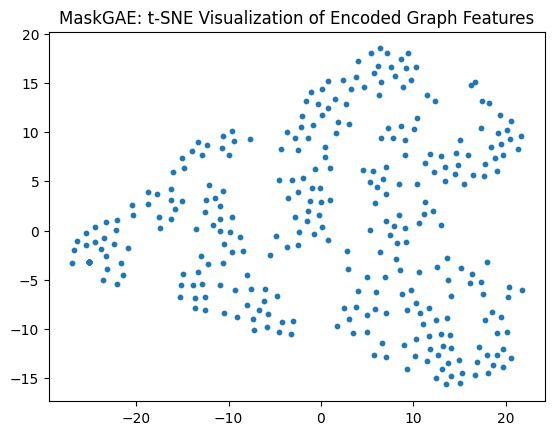

MaskGAE: Visualizing encoded features for mask ratio: 0.7


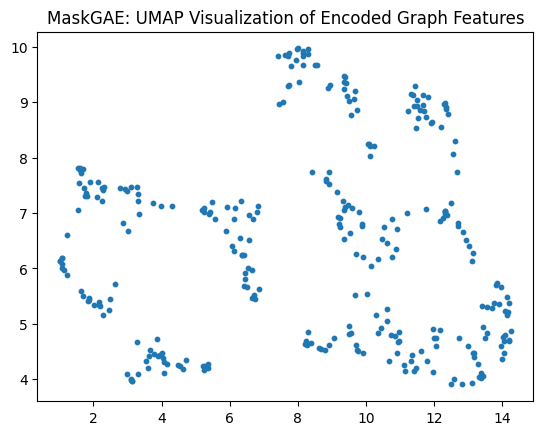

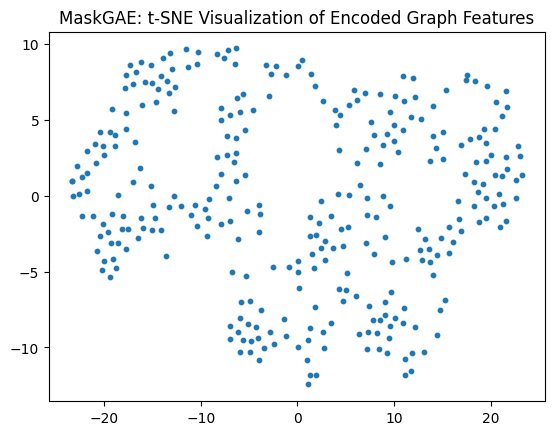

MaskGAE: Visualizing encoded features for mask ratio: 0.9


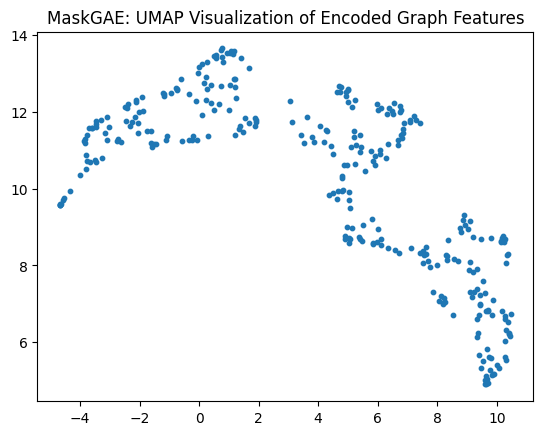

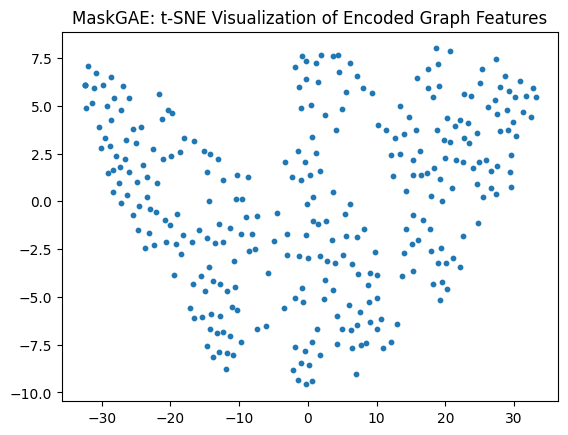

In [ ]:
import torch
import networkx as nx
import numpy as np
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import umap
from sklearn.manifold import TSNE

CUSTOM_EPOCHS = 50

# Generowanie losowego grafu Erdos-Renyi
num_nodes = 312
prob = 0.1
G = nx.erdos_renyi_graph(num_nodes, prob)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
data = Data(x=x, edge_index=edge_index)

## Podział na zbiór treningowy i testowy
def split_edges(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    # Wygenerowanie losowego permutacji indeksów
    perm = torch.randperm(num_edges)
    test_size = int(num_edges * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm[:test_size]]
    train_edge_index = edge_index[:, perm[test_size:]]

    # Utworzenie dwóch obiektów Data: jeden dla treningu, drugi dla testowania
    train_data = Data(x=data.x, edge_index=train_edge_index)
    test_data = Data(x=data.x, edge_index=test_edge_index)

    return train_data, test_data

train_data, test_data = split_edges(data, test_ratio=0.2)

## Implementacja Autoenkodera Grafowego MaskGAE
class MaskGAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MaskGAE, self).__init__()

        # Enkoder z dwoma warstwami GCN
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

        # Dekoder struktury z dwoma warstwami MLP
        self.structure_decoder = nn.Sequential(
            nn.Linear(out_channels, 2 * out_channels),
            nn.ReLU(),
            nn.Linear(2 * out_channels, in_channels)
        )

        # Dekoder stopnia z dwoma warstwami MLP
        self.degree_decoder = nn.Sequential(
            nn.Linear(out_channels, 2 * out_channels),
            nn.ReLU(),
            nn.Linear(2 * out_channels, in_channels)
        )

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

    def decode_structure(self, z):
        # Dekodowanie struktury grafu
        return self.structure_decoder(z)

    def decode_degree(self, z):
        # Dekodowanie stopnia wierzchołków
        return self.degree_decoder(z)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        structure_reconstruction = self.decode_structure(z)
        degree_prediction = self.decode_degree(z)

        # Zwracamy rekonstrukcję struktury i predykcję stopnia jako wynik
        return structure_reconstruction, degree_prediction

## Maskowanie krawędzi
def mask_edges(data, mask_ratio):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    mask_indices = random.sample(range(num_edges), num_mask)
    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

## Trening modelu z użyciem zbioru treningowego i ocena na zbiorze testowym
def train_and_evaluate(in_channels, out_channels, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    criterion = torch.nn.MSELoss()

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        # Inicjalizacja nowego modelu dla każdego mask_ratio
        model = MaskGAE(in_channels=in_channels, out_channels=out_channels)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            structure_reconstruction, degree_prediction = model(masked_train_data.x, masked_train_data.edge_index)

            # Zmodyfikowana funkcja straty: uwzględniamy zarówno rekonstrukcję struktury, jak i predykcję stopnia
            structure_loss = criterion(structure_reconstruction, train_data.x)
            degree_loss = criterion(degree_prediction, train_data.x)  # Załóżmy, że oryginalne cechy są również używane do przewidywania stopnia
            loss = structure_loss + degree_loss

            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
    return results, model

# Funkcja do oceny modelu na zbiorze testowym
def evaluate_on_test(model, test_data):
    model.eval()  # Przełącz model na tryb ewaluacji
    with torch.no_grad():  # Wyłącz gradienty podczas testowania
        # Zakoduj dane testowe
        z = model.encode(test_data.x, test_data.edge_index)

        # Dekodowanie struktury i stopnia wierzchołków
        structure_reconstruction = model.decode_structure(z)
        degree_prediction = model.decode_degree(z)

        # Obliczenie błędów predykcji dla rekonstrukcji struktury i stopnia wierzchołków
        structure_error, degree_error = calculate_prediction_error(structure_reconstruction, degree_prediction, test_data)

        print(f'Test Structure Error: {structure_error}, Test Degree Error: {degree_error}')
        return structure_error, degree_error


def calculate_prediction_error(pred, data):
    return torch.nn.functional.mse_loss(pred, data.x).item()

## Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('MaskGAE: Effect of Edge Masking Ratio on MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def final_loss_comparison(results):
    final_losses = {ratio: losses[-1] for ratio, losses in results.items()}
    ratios = list(final_losses.keys())
    losses = list(final_losses.values())

    plt.figure(figsize=(10, 6))
    plt.bar(ratios, losses, color='skyblue')
    plt.xlabel('Mask Ratio')
    plt.ylabel('Final MSE Loss')
    plt.title('MaskGAE: Final MSE Loss for Different Edge Masking Ratios')
    plt.grid(True)
    plt.show()

def predict(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        structure_reconstruction = model.decode_structure(z)
        degree_prediction = model.decode_degree(z)
        return structure_reconstruction, degree_prediction, z

def calculate_prediction_error(pred_structure, pred_degree, data):
    structure_error = torch.nn.functional.mse_loss(pred_structure, data.x).item()
    degree_error = torch.nn.functional.mse_loss(pred_degree, data.x).item()
    return structure_error, degree_error

# Funkcja do wizualizacji UMAP i t-SNE
def visualize_latent_space(z, method='UMAP'):
    if method == 'UMAP':
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
        embedding = reducer.fit_transform(z.detach().cpu().numpy())
        plt.title('MaskGAE: UMAP Visualization of Encoded Graph Features')
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
        embedding = reducer.fit_transform(z.detach().cpu().numpy())
        plt.title('MaskGAE: t-SNE Visualization of Encoded Graph Features')

    plt.scatter(embedding[:, 0], embedding[:, 1], s=10)
    plt.show()

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]  # Including 0.0 for no masking
results, trained_model = train_and_evaluate(in_channels=train_data.num_features, out_channels=2, train_data=train_data, test_data=test_data, mask_ratios=mask_ratios, epochs=CUSTOM_EPOCHS)
plot_results(results)
final_loss_comparison(results)

# Ewaluacja na zbiorze testowym
test_loss = evaluate_on_test(trained_model, test_data)
print(f"Test Loss: {test_loss}")

# Predykcja na nieolabelowanych danych
unlabeled_data = test_data  # In real scenario, use a different unlabeled dataset

predictions = {}
errors = {}
encoded_representations = {}
for ratio in mask_ratios:
    model = MaskGAE(in_channels=data.num_features, out_channels=2)
    train_and_evaluate(train_data.num_features, 2, train_data, test_data, [ratio], epochs=CUSTOM_EPOCHS)
    pred_structure, pred_degree, z = predict(model, unlabeled_data)
    structure_error, degree_error = calculate_prediction_error(pred_structure, pred_degree, unlabeled_data)
    errors[ratio] = (structure_error, degree_error)
    encoded_representations[ratio] = z

# Wizualizacja błędów predykcji
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(errors))
index_shifted = index + bar_width

# Wizualizacja błędów predykcji
plt.bar(index, [e[0] for e in errors.values()], width=bar_width, label='Structure Error', color='skyblue')
plt.bar(index_shifted, [e[1] for e in errors.values()], width=bar_width, label='Degree Error', color='orange')
plt.xlabel('Mask Ratio')
plt.ylabel('Prediction Error')
plt.title('MaskGAE: Link Prediction Errors for Different Masking Ratios')
plt.xticks(index + bar_width / 2, errors.keys())
plt.legend()
plt.grid(True)
plt.show()

# Wizualizacja zakodowanych reprezentacji z użyciem UMAP i t-SNE
for ratio, z in encoded_representations.items():
    print(f"MaskGAE: Visualizing encoded features for mask ratio: {ratio}")

    # UMAP
    visualize_latent_space(z, method='UMAP')

    # t-SNE
    visualize_latent_space(z, method='t-SNE')

## Klasyfikacja społeczności

Training with mask ratio: 0.0
Epoch 0, Loss: 1.3491039276123047
Epoch 10, Loss: 1.1353647708892822
Epoch 20, Loss: 0.9662807583808899
Epoch 30, Loss: 0.7858541011810303
Epoch 40, Loss: 0.5815144777297974
Epoch 50, Loss: 0.3973155915737152
Epoch 60, Loss: 0.26758915185928345
Epoch 70, Loss: 0.1828027367591858
Epoch 80, Loss: 0.1281905472278595
Epoch 90, Loss: 0.09304531663656235
Epoch 100, Loss: 0.07008852064609528
Epoch 110, Loss: 0.05487944930791855
Epoch 120, Loss: 0.04441531002521515
Epoch 130, Loss: 0.03692828491330147
Epoch 140, Loss: 0.031415265053510666
Classification Accuracy for mask ratio 0.0: 0.6296296296296297
Training with mask ratio: 0.1
Epoch 0, Loss: 1.3858222961425781
Epoch 10, Loss: 1.157564401626587
Epoch 20, Loss: 1.051252841949463
Epoch 30, Loss: 0.9090369343757629
Epoch 40, Loss: 0.7229217290878296
Epoch 50, Loss: 0.5330402851104736
Epoch 60, Loss: 0.3674324154853821
Epoch 70, Loss: 0.25299370288848877
Epoch 80, Loss: 0.16120533645153046
Epoch 90, Loss: 0.11226884

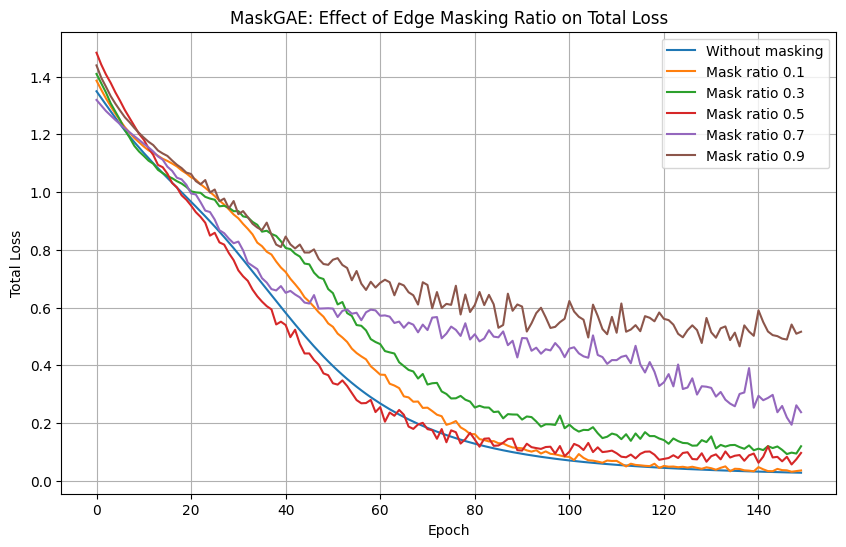

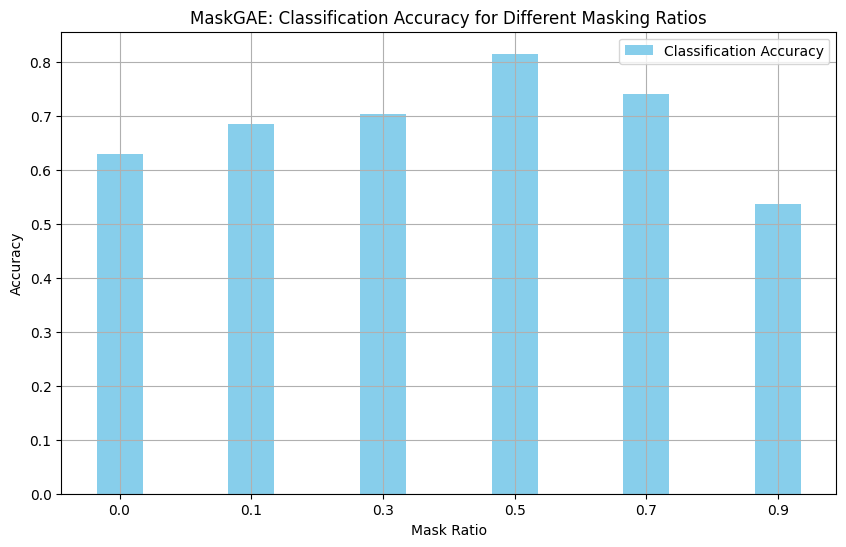

In [ ]:
import torch
import networkx as nx
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import numpy as np

CUSTOM_EPOCHS = 150

# Generowanie grafu za pomocą Stochastic Block Model (SBM)
num_nodes = 270
sizes = [90, 90, 90]  # Liczba węzłów w każdej społeczności (bloku)
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.25]]  # Macierz prawdopodobieństw krawędzi między społecznościami
G = nx.stochastic_block_model(sizes, probs)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
labels = torch.zeros(num_nodes, dtype=torch.long)

# Przydzielanie etykiet węzłom na podstawie społeczności
for i, size in enumerate(sizes):
    labels[sum(sizes[:i]):sum(sizes[:i+1])] = i

data = Data(x=x, edge_index=edge_index, y=labels)

# Podział na zbiór treningowy i testowy
def split_edges_and_nodes(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    num_nodes = data.num_nodes

    # Wygenerowanie losowego permutacji indeksów
    perm_edges = torch.randperm(num_edges)
    perm_nodes = torch.randperm(num_nodes)
    test_size_edges = int(num_edges * test_ratio)
    test_size_nodes = int(num_nodes * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm_edges[:test_size_edges]]
    train_edge_index = edge_index[:, perm_edges[test_size_edges:]]
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[perm_nodes[test_size_nodes:]] = True
    test_mask[perm_nodes[:test_size_nodes]] = True

    train_data = Data(x=data.x, edge_index=train_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)
    test_data = Data(x=data.x, edge_index=test_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)

    return train_data, test_data

train_data, test_data = split_edges_and_nodes(data, test_ratio=0.2)

# Implementacja Autoenkodera Grafowego MaskGAE
class MaskGAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(MaskGAE, self).__init__()

        # Enkoder z dwoma warstwami GCN
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

        # Dekoder struktury z dwoma warstwami MLP
        self.structure_decoder = nn.Sequential(
            nn.Linear(out_channels, 2 * out_channels),
            nn.ReLU(),
            nn.Linear(2 * out_channels, in_channels)
        )

        # Dekoder stopnia z dwoma warstwami MLP
        self.degree_decoder = nn.Sequential(
            nn.Linear(out_channels, 2 * out_channels),
            nn.ReLU(),
            nn.Linear(2 * out_channels, in_channels)
        )

        # Dekoder klasyfikacji węzłów
        self.classifier = nn.Linear(out_channels, num_classes)

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

    def decode_structure(self, z):
        # Dekodowanie struktury grafu
        return self.structure_decoder(z)

    def decode_degree(self, z):
        # Dekodowanie stopnia wierzchołków
        return self.degree_decoder(z)

    def classify(self, z):
        # Klasyfikacja węzłów
        return self.classifier(z)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        structure_reconstruction = self.decode_structure(z)
        degree_prediction = self.decode_degree(z)
        node_classification = self.classify(z)

        # Zwracamy rekonstrukcję struktury, predykcję stopnia i klasyfikację jako wynik
        return structure_reconstruction, degree_prediction, node_classification

# Funkcja do maskowania krawędzi
def mask_edges(data, mask_ratio):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    mask_indices = random.sample(range(num_edges), num_mask)
    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

# Trening modelu z klasyfikacją węzłów
def train_and_evaluate(in_channels, out_channels, num_classes, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    accuracies = {}
    criterion_reconstruction = torch.nn.MSELoss()
    criterion_degree = torch.nn.MSELoss()  # Nowy cel dla predykcji stopnia
    criterion_classification = nn.CrossEntropyLoss()  # Loss function for classification
    models = {}  # Store trained models for each mask ratio

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        model = MaskGAE(in_channels=in_channels, out_channels=out_channels, num_classes=num_classes)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            structure_out, degree_out, class_out = model(masked_train_data.x, masked_train_data.edge_index)

            loss_reconstruction = criterion_reconstruction(structure_out, train_data.x)
            loss_degree = criterion_degree(degree_out, train_data.x)  # Załóżmy, że stopień jest reprezentowany przez x
            loss_classification = criterion_classification(class_out[train_data.train_mask], train_data.y[train_data.train_mask])
            loss = loss_reconstruction + loss_degree + loss_classification
            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

        # Evaluate classification accuracy on test data
        model.eval()
        with torch.no_grad():
            _, _, class_out = model(test_data.x, test_data.edge_index)
            predicted_classes = class_out.argmax(dim=1)
            correct = (predicted_classes[test_data.test_mask] == test_data.y[test_data.test_mask]).sum().item()
            accuracy = correct / test_data.test_mask.sum().item()
            accuracies[ratio] = accuracy
            print(f'Classification Accuracy for mask ratio {ratio}: {accuracy}')

        models[ratio] = model  # Save the trained model for this ratio

    return results, models, accuracies

# Funkcja do predykcji
def predict(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        structure_out = model.decode_structure(z)
        degree_out = model.decode_degree(z)
        class_out = model.classify(z)
        return structure_out, degree_out, class_out, z

# Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('MaskGAE: Effect of Edge Masking Ratio on Total Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
results, trained_models, accuracies = train_and_evaluate(
    in_channels=train_data.num_features,
    out_channels=2,
    num_classes=len(sizes),
    train_data=train_data,
    test_data=test_data,
    mask_ratios=mask_ratios,
    epochs=CUSTOM_EPOCHS
)

# Plot loss results
plot_results(results)

# Plot classification accuracy for each mask ratio
plt.figure(figsize=(10, 6))
index = np.arange(len(accuracies))
bar_width = 0.35
plt.bar(index, list(accuracies.values()), width=bar_width, color='skyblue', label='Classification Accuracy')
plt.xlabel('Mask Ratio')
plt.ylabel('Accuracy')
plt.title('MaskGAE: Classification Accuracy for Different Masking Ratios')
plt.xticks(index, [str(ratio) for ratio in accuracies.keys()])
plt.legend()
plt.grid(True)
plt.show()


## 500 węzłów - Przewidywanie połaczeń

Training with mask ratio: 0.0
Epoch 0, Loss: 0.20317700505256653
Epoch 10, Loss: 0.08728739619255066
Epoch 20, Loss: 0.03719230368733406
Epoch 30, Loss: 0.015832826495170593
Epoch 40, Loss: 0.007371870335191488
Training with mask ratio: 0.1
Epoch 0, Loss: 0.23828241229057312
Epoch 10, Loss: 0.08902513980865479
Epoch 20, Loss: 0.03449796140193939
Epoch 30, Loss: 0.013581444509327412
Epoch 40, Loss: 0.006495651789009571
Training with mask ratio: 0.3
Epoch 0, Loss: 0.23805788159370422
Epoch 10, Loss: 0.08765092492103577
Epoch 20, Loss: 0.03581050783395767
Epoch 30, Loss: 0.014256082475185394
Epoch 40, Loss: 0.006798972375690937
Training with mask ratio: 0.5
Epoch 0, Loss: 0.27829140424728394
Epoch 10, Loss: 0.07628816366195679
Epoch 20, Loss: 0.025888096541166306
Epoch 30, Loss: 0.010600924491882324
Epoch 40, Loss: 0.005722726695239544
Training with mask ratio: 0.7
Epoch 0, Loss: 0.19551680982112885
Epoch 10, Loss: 0.07656657695770264
Epoch 20, Loss: 0.02839871309697628
Epoch 30, Loss: 0.

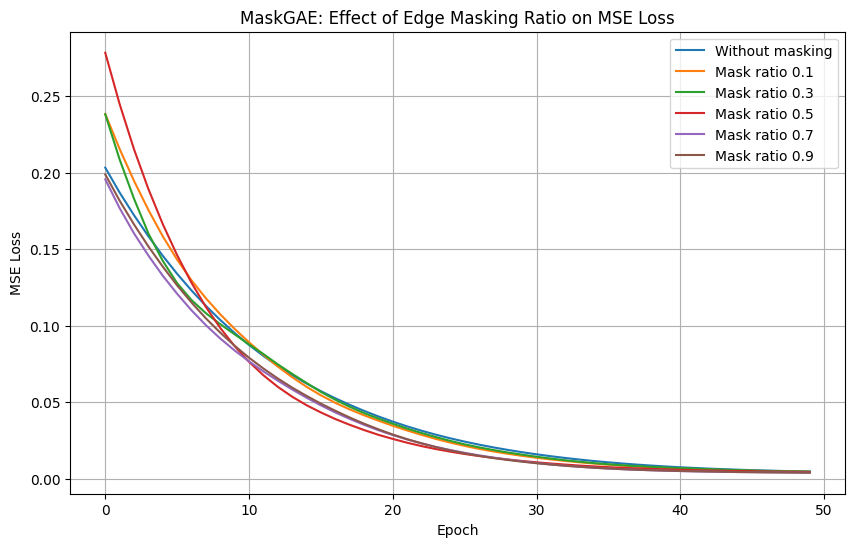

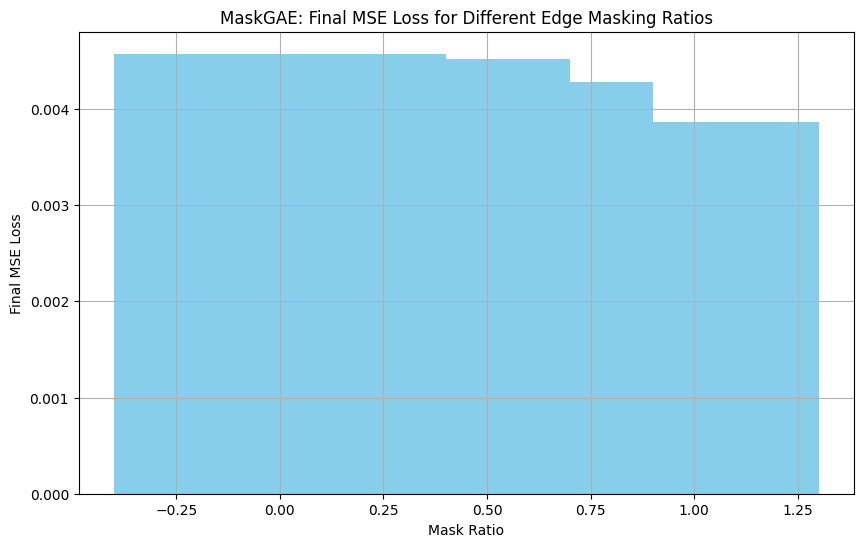

Test Structure Error: 0.002036893740296364, Test Degree Error: 0.0018512040842324495
Test Loss: (0.002036893740296364, 0.0018512040842324495)
Training with mask ratio: 0.0
Epoch 0, Loss: 0.23620709776878357
Epoch 10, Loss: 0.07738000154495239
Epoch 20, Loss: 0.02617552876472473
Epoch 30, Loss: 0.009651018306612968
Epoch 40, Loss: 0.0052696699276566505
Training with mask ratio: 0.1
Epoch 0, Loss: 0.2370738387107849
Epoch 10, Loss: 0.08033178746700287
Epoch 20, Loss: 0.029664477333426476
Epoch 30, Loss: 0.011767538264393806
Epoch 40, Loss: 0.005792128387838602
Training with mask ratio: 0.3
Epoch 0, Loss: 0.21939626336097717
Epoch 10, Loss: 0.08259297162294388
Epoch 20, Loss: 0.0316699743270874
Epoch 30, Loss: 0.012560483068227768
Epoch 40, Loss: 0.0058023352175951
Training with mask ratio: 0.5
Epoch 0, Loss: 0.17245706915855408
Epoch 10, Loss: 0.08452904969453812
Epoch 20, Loss: 0.03609154373407364
Epoch 30, Loss: 0.014420900493860245
Epoch 40, Loss: 0.006653273478150368
Training with ma

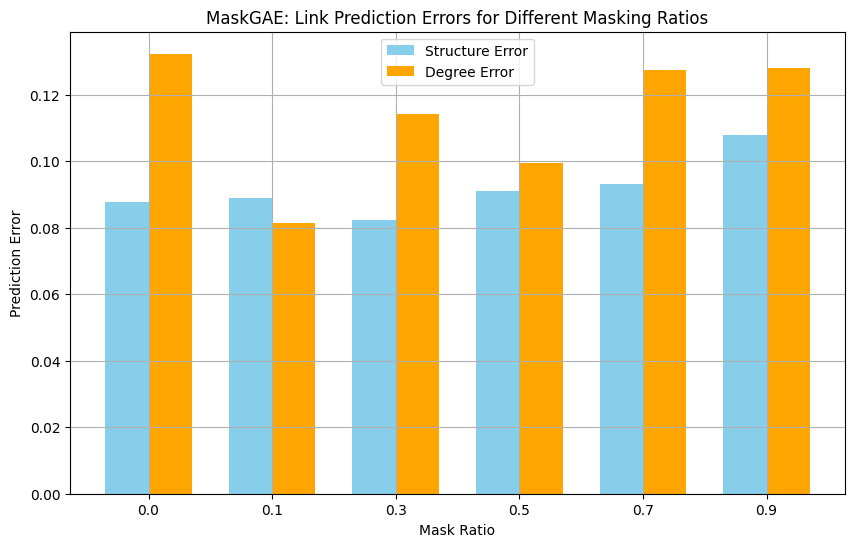

MaskGAE: Visualizing encoded features for mask ratio: 0.0


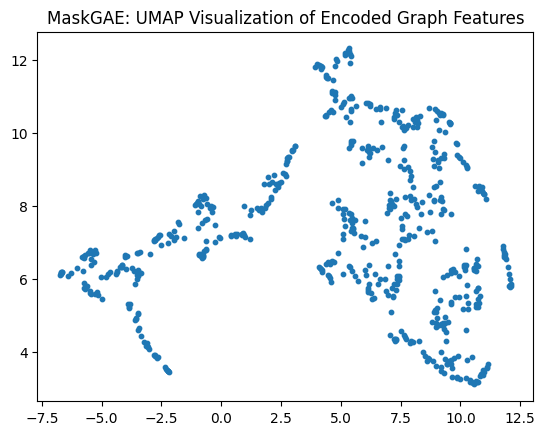

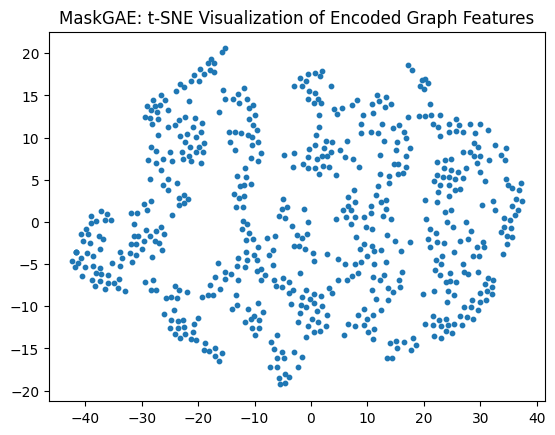

MaskGAE: Visualizing encoded features for mask ratio: 0.1


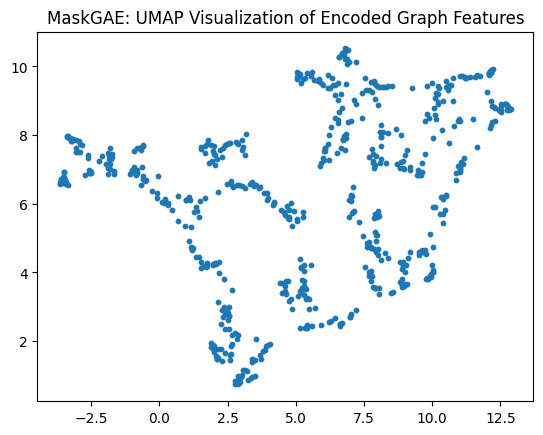

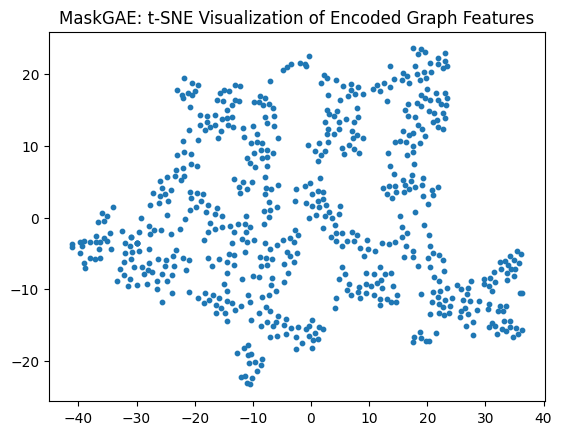

MaskGAE: Visualizing encoded features for mask ratio: 0.3


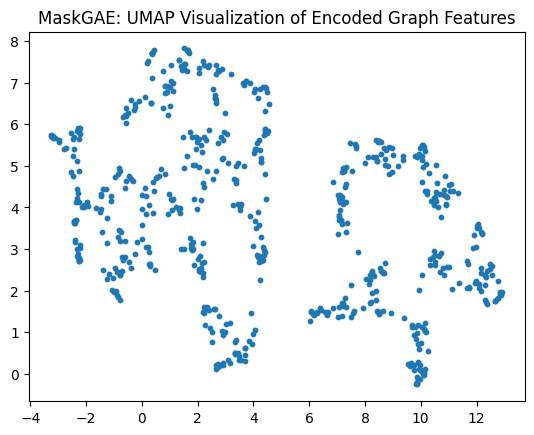

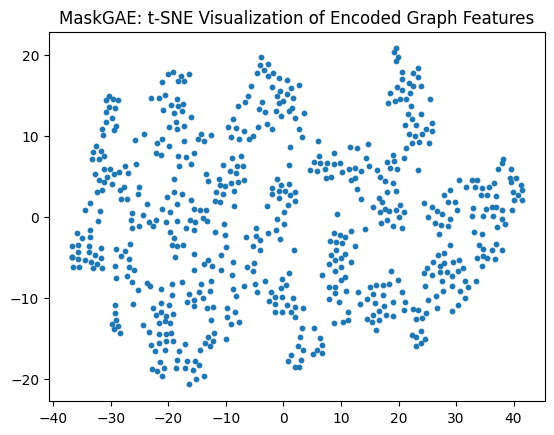

MaskGAE: Visualizing encoded features for mask ratio: 0.5


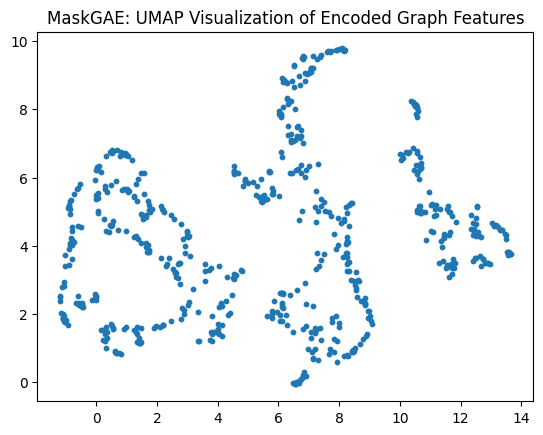

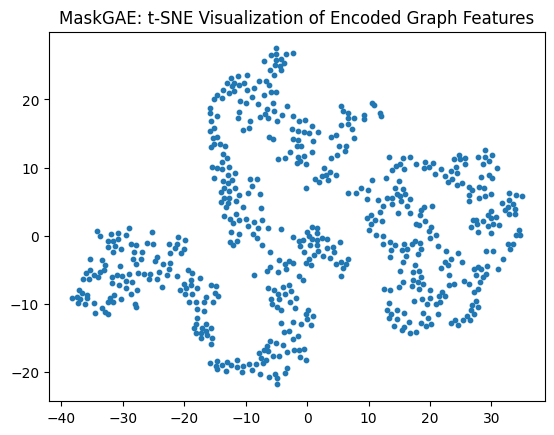

MaskGAE: Visualizing encoded features for mask ratio: 0.7


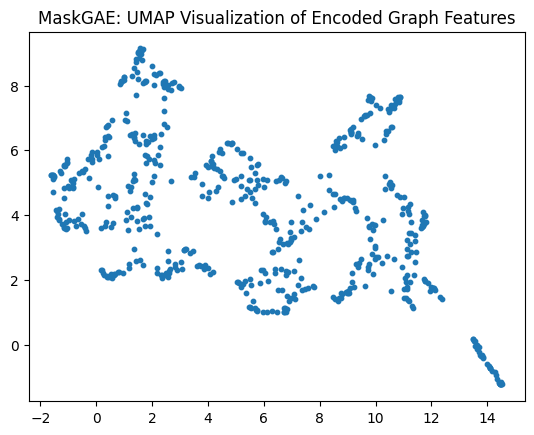

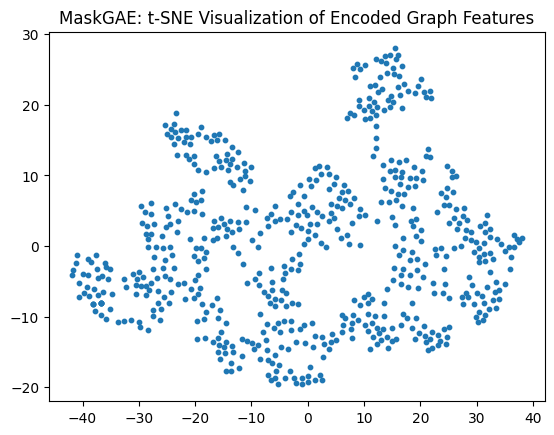

MaskGAE: Visualizing encoded features for mask ratio: 0.9


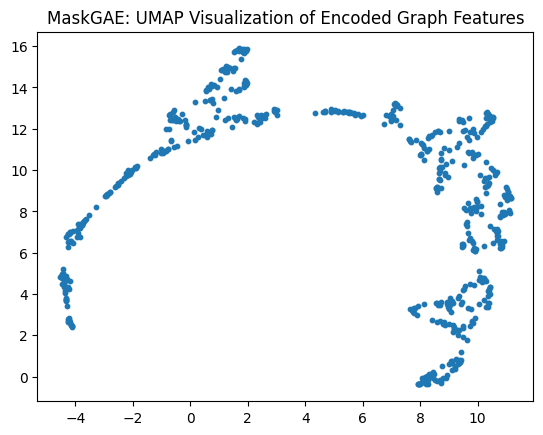

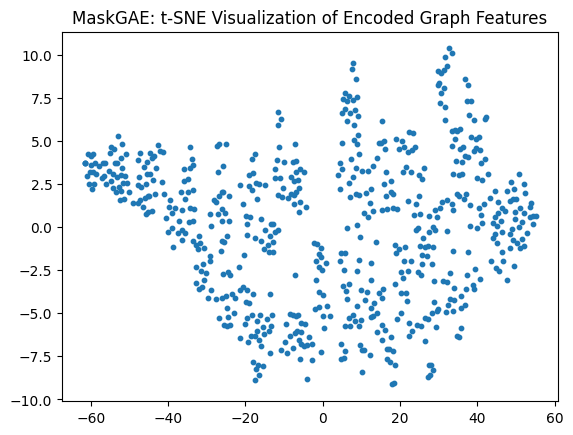

In [ ]:
import torch
import networkx as nx
import numpy as np
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import umap
from sklearn.manifold import TSNE

CUSTOM_EPOCHS = 50

# Generowanie losowego grafu Erdos-Renyi
num_nodes = 625
prob = 0.1
G = nx.erdos_renyi_graph(num_nodes, prob)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
data = Data(x=x, edge_index=edge_index)

## Podział na zbiór treningowy i testowy
def split_edges(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    # Wygenerowanie losowego permutacji indeksów
    perm = torch.randperm(num_edges)
    test_size = int(num_edges * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm[:test_size]]
    train_edge_index = edge_index[:, perm[test_size:]]

    # Utworzenie dwóch obiektów Data: jeden dla treningu, drugi dla testowania
    train_data = Data(x=data.x, edge_index=train_edge_index)
    test_data = Data(x=data.x, edge_index=test_edge_index)

    return train_data, test_data

train_data, test_data = split_edges(data, test_ratio=0.2)

## Implementacja Autoenkodera Grafowego MaskGAE
class MaskGAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MaskGAE, self).__init__()

        # Enkoder z dwoma warstwami GCN
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

        # Dekoder struktury z dwoma warstwami MLP
        self.structure_decoder = nn.Sequential(
            nn.Linear(out_channels, 2 * out_channels),
            nn.ReLU(),
            nn.Linear(2 * out_channels, in_channels)
        )

        # Dekoder stopnia z dwoma warstwami MLP
        self.degree_decoder = nn.Sequential(
            nn.Linear(out_channels, 2 * out_channels),
            nn.ReLU(),
            nn.Linear(2 * out_channels, in_channels)
        )

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

    def decode_structure(self, z):
        # Dekodowanie struktury grafu
        return self.structure_decoder(z)

    def decode_degree(self, z):
        # Dekodowanie stopnia wierzchołków
        return self.degree_decoder(z)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        structure_reconstruction = self.decode_structure(z)
        degree_prediction = self.decode_degree(z)

        # Zwracamy rekonstrukcję struktury i predykcję stopnia jako wynik
        return structure_reconstruction, degree_prediction

## Maskowanie krawędzi
def mask_edges(data, mask_ratio):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    mask_indices = random.sample(range(num_edges), num_mask)
    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

## Trening modelu z użyciem zbioru treningowego i ocena na zbiorze testowym
def train_and_evaluate(in_channels, out_channels, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    criterion = torch.nn.MSELoss()

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        # Inicjalizacja nowego modelu dla każdego mask_ratio
        model = MaskGAE(in_channels=in_channels, out_channels=out_channels)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            structure_reconstruction, degree_prediction = model(masked_train_data.x, masked_train_data.edge_index)

            # Zmodyfikowana funkcja straty: uwzględniamy zarówno rekonstrukcję struktury, jak i predykcję stopnia
            structure_loss = criterion(structure_reconstruction, train_data.x)
            degree_loss = criterion(degree_prediction, train_data.x)  # Załóżmy, że oryginalne cechy są również używane do przewidywania stopnia
            loss = structure_loss + degree_loss

            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
    return results, model

# Funkcja do oceny modelu na zbiorze testowym
def evaluate_on_test(model, test_data):
    model.eval()  # Przełącz model na tryb ewaluacji
    with torch.no_grad():  # Wyłącz gradienty podczas testowania
        # Zakoduj dane testowe
        z = model.encode(test_data.x, test_data.edge_index)

        # Dekodowanie struktury i stopnia wierzchołków
        structure_reconstruction = model.decode_structure(z)
        degree_prediction = model.decode_degree(z)

        # Obliczenie błędów predykcji dla rekonstrukcji struktury i stopnia wierzchołków
        structure_error, degree_error = calculate_prediction_error(structure_reconstruction, degree_prediction, test_data)

        print(f'Test Structure Error: {structure_error}, Test Degree Error: {degree_error}')
        return structure_error, degree_error


def calculate_prediction_error(pred, data):
    return torch.nn.functional.mse_loss(pred, data.x).item()

## Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('MaskGAE: Effect of Edge Masking Ratio on MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def final_loss_comparison(results):
    final_losses = {ratio: losses[-1] for ratio, losses in results.items()}
    ratios = list(final_losses.keys())
    losses = list(final_losses.values())

    plt.figure(figsize=(10, 6))
    plt.bar(ratios, losses, color='skyblue')
    plt.xlabel('Mask Ratio')
    plt.ylabel('Final MSE Loss')
    plt.title('MaskGAE: Final MSE Loss for Different Edge Masking Ratios')
    plt.grid(True)
    plt.show()

def predict(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        structure_reconstruction = model.decode_structure(z)
        degree_prediction = model.decode_degree(z)
        return structure_reconstruction, degree_prediction, z

def calculate_prediction_error(pred_structure, pred_degree, data):
    structure_error = torch.nn.functional.mse_loss(pred_structure, data.x).item()
    degree_error = torch.nn.functional.mse_loss(pred_degree, data.x).item()
    return structure_error, degree_error

# Funkcja do wizualizacji UMAP i t-SNE
def visualize_latent_space(z, method='UMAP'):
    if method == 'UMAP':
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
        embedding = reducer.fit_transform(z.detach().cpu().numpy())
        plt.title('MaskGAE: UMAP Visualization of Encoded Graph Features')
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
        embedding = reducer.fit_transform(z.detach().cpu().numpy())
        plt.title('MaskGAE: t-SNE Visualization of Encoded Graph Features')

    plt.scatter(embedding[:, 0], embedding[:, 1], s=10)
    plt.show()

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]  # Including 0.0 for no masking
results, trained_model = train_and_evaluate(in_channels=train_data.num_features, out_channels=2, train_data=train_data, test_data=test_data, mask_ratios=mask_ratios, epochs=CUSTOM_EPOCHS)
plot_results(results)
final_loss_comparison(results)

# Ewaluacja na zbiorze testowym
test_loss = evaluate_on_test(trained_model, test_data)
print(f"Test Loss: {test_loss}")

# Predykcja na nieolabelowanych danych
unlabeled_data = test_data  # In real scenario, use a different unlabeled dataset

predictions = {}
errors = {}
encoded_representations = {}
for ratio in mask_ratios:
    model = MaskGAE(in_channels=data.num_features, out_channels=2)
    train_and_evaluate(train_data.num_features, 2, train_data, test_data, [ratio], epochs=CUSTOM_EPOCHS)
    pred_structure, pred_degree, z = predict(model, unlabeled_data)
    structure_error, degree_error = calculate_prediction_error(pred_structure, pred_degree, unlabeled_data)
    errors[ratio] = (structure_error, degree_error)
    encoded_representations[ratio] = z

# Wizualizacja błędów predykcji
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(errors))
index_shifted = index + bar_width

# Wizualizacja błędów predykcji
plt.bar(index, [e[0] for e in errors.values()], width=bar_width, label='Structure Error', color='skyblue')
plt.bar(index_shifted, [e[1] for e in errors.values()], width=bar_width, label='Degree Error', color='orange')
plt.xlabel('Mask Ratio')
plt.ylabel('Prediction Error')
plt.title('MaskGAE: Link Prediction Errors for Different Masking Ratios')
plt.xticks(index + bar_width / 2, errors.keys())
plt.legend()
plt.grid(True)
plt.show()

# Wizualizacja zakodowanych reprezentacji z użyciem UMAP i t-SNE
for ratio, z in encoded_representations.items():
    print(f"MaskGAE: Visualizing encoded features for mask ratio: {ratio}")

    # UMAP
    visualize_latent_space(z, method='UMAP')

    # t-SNE
    visualize_latent_space(z, method='t-SNE')

## Klasyfikacja społeczności

Training with mask ratio: 0.0
Epoch 0, Loss: 1.3799960613250732
Epoch 10, Loss: 1.1093299388885498
Epoch 20, Loss: 0.9106305837631226
Epoch 30, Loss: 0.7302114367485046
Epoch 40, Loss: 0.5887029767036438
Epoch 50, Loss: 0.49447229504585266
Epoch 60, Loss: 0.4010631740093231
Epoch 70, Loss: 0.313992977142334
Epoch 80, Loss: 0.23609420657157898
Epoch 90, Loss: 0.17970168590545654
Epoch 100, Loss: 0.14141912758350372
Epoch 110, Loss: 0.11449898034334183
Epoch 120, Loss: 0.09488779306411743
Epoch 130, Loss: 0.0799906775355339
Epoch 140, Loss: 0.06835229694843292
Classification Accuracy for mask ratio 0.0: 0.7619047619047619
Training with mask ratio: 0.1
Epoch 0, Loss: 1.4732526540756226
Epoch 10, Loss: 1.1602754592895508
Epoch 20, Loss: 0.9637174606323242
Epoch 30, Loss: 0.7502189874649048
Epoch 40, Loss: 0.5283282399177551
Epoch 50, Loss: 0.3559058904647827
Epoch 60, Loss: 0.23881351947784424
Epoch 70, Loss: 0.16566671431064606
Epoch 80, Loss: 0.12588441371917725
Epoch 90, Loss: 0.0970251

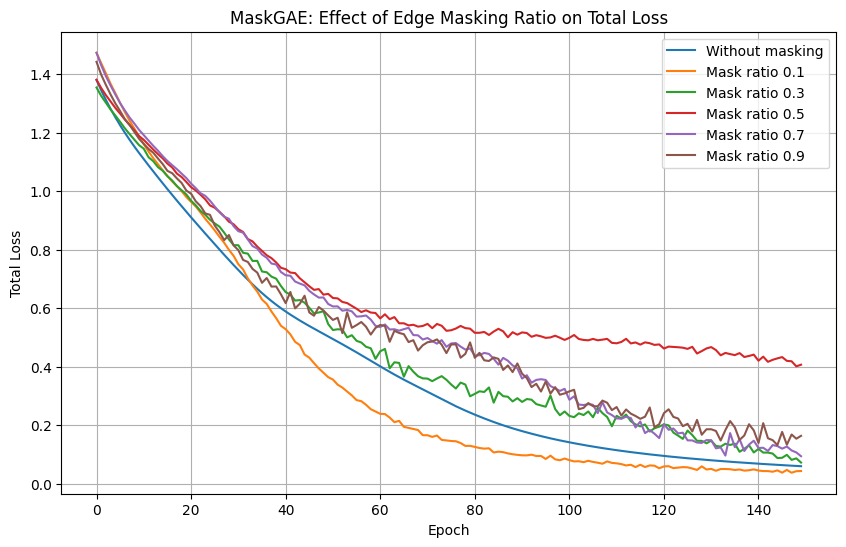

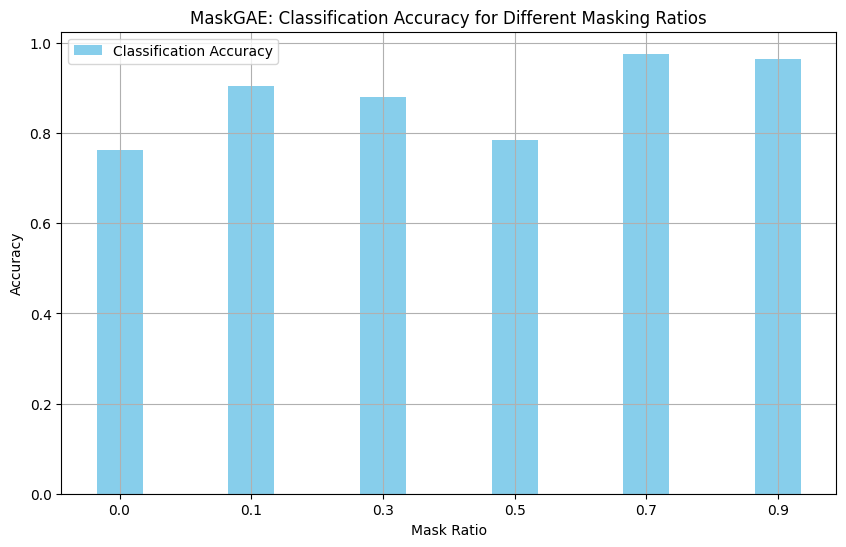

In [ ]:
import torch
import networkx as nx
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import numpy as np

CUSTOM_EPOCHS = 150

# Generowanie grafu za pomocą Stochastic Block Model (SBM)
num_nodes = 423
sizes = [141, 141, 141]  # Liczba węzłów w każdej społeczności (bloku)
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.25]]  # Macierz prawdopodobieństw krawędzi między społecznościami
G = nx.stochastic_block_model(sizes, probs)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
labels = torch.zeros(num_nodes, dtype=torch.long)

# Przydzielanie etykiet węzłom na podstawie społeczności
for i, size in enumerate(sizes):
    labels[sum(sizes[:i]):sum(sizes[:i+1])] = i

data = Data(x=x, edge_index=edge_index, y=labels)

# Podział na zbiór treningowy i testowy
def split_edges_and_nodes(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    num_nodes = data.num_nodes

    # Wygenerowanie losowego permutacji indeksów
    perm_edges = torch.randperm(num_edges)
    perm_nodes = torch.randperm(num_nodes)
    test_size_edges = int(num_edges * test_ratio)
    test_size_nodes = int(num_nodes * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm_edges[:test_size_edges]]
    train_edge_index = edge_index[:, perm_edges[test_size_edges:]]
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[perm_nodes[test_size_nodes:]] = True
    test_mask[perm_nodes[:test_size_nodes]] = True

    train_data = Data(x=data.x, edge_index=train_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)
    test_data = Data(x=data.x, edge_index=test_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)

    return train_data, test_data

train_data, test_data = split_edges_and_nodes(data, test_ratio=0.2)

# Implementacja Autoenkodera Grafowego MaskGAE
class MaskGAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(MaskGAE, self).__init__()

        # Enkoder z dwoma warstwami GCN
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

        # Dekoder struktury z dwoma warstwami MLP
        self.structure_decoder = nn.Sequential(
            nn.Linear(out_channels, 2 * out_channels),
            nn.ReLU(),
            nn.Linear(2 * out_channels, in_channels)
        )

        # Dekoder stopnia z dwoma warstwami MLP
        self.degree_decoder = nn.Sequential(
            nn.Linear(out_channels, 2 * out_channels),
            nn.ReLU(),
            nn.Linear(2 * out_channels, in_channels)
        )

        # Dekoder klasyfikacji węzłów
        self.classifier = nn.Linear(out_channels, num_classes)

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

    def decode_structure(self, z):
        # Dekodowanie struktury grafu
        return self.structure_decoder(z)

    def decode_degree(self, z):
        # Dekodowanie stopnia wierzchołków
        return self.degree_decoder(z)

    def classify(self, z):
        # Klasyfikacja węzłów
        return self.classifier(z)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        structure_reconstruction = self.decode_structure(z)
        degree_prediction = self.decode_degree(z)
        node_classification = self.classify(z)

        # Zwracamy rekonstrukcję struktury, predykcję stopnia i klasyfikację jako wynik
        return structure_reconstruction, degree_prediction, node_classification

# Funkcja do maskowania krawędzi
def mask_edges(data, mask_ratio):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    mask_indices = random.sample(range(num_edges), num_mask)
    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

# Trening modelu z klasyfikacją węzłów
def train_and_evaluate(in_channels, out_channels, num_classes, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    accuracies = {}
    criterion_reconstruction = torch.nn.MSELoss()
    criterion_degree = torch.nn.MSELoss()  # Nowy cel dla predykcji stopnia
    criterion_classification = nn.CrossEntropyLoss()  # Loss function for classification
    models = {}  # Store trained models for each mask ratio

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        model = MaskGAE(in_channels=in_channels, out_channels=out_channels, num_classes=num_classes)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            structure_out, degree_out, class_out = model(masked_train_data.x, masked_train_data.edge_index)

            loss_reconstruction = criterion_reconstruction(structure_out, train_data.x)
            loss_degree = criterion_degree(degree_out, train_data.x)  # Załóżmy, że stopień jest reprezentowany przez x
            loss_classification = criterion_classification(class_out[train_data.train_mask], train_data.y[train_data.train_mask])
            loss = loss_reconstruction + loss_degree + loss_classification
            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

        # Evaluate classification accuracy on test data
        model.eval()
        with torch.no_grad():
            _, _, class_out = model(test_data.x, test_data.edge_index)
            predicted_classes = class_out.argmax(dim=1)
            correct = (predicted_classes[test_data.test_mask] == test_data.y[test_data.test_mask]).sum().item()
            accuracy = correct / test_data.test_mask.sum().item()
            accuracies[ratio] = accuracy
            print(f'Classification Accuracy for mask ratio {ratio}: {accuracy}')

        models[ratio] = model  # Save the trained model for this ratio

    return results, models, accuracies

# Funkcja do predykcji
def predict(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        structure_out = model.decode_structure(z)
        degree_out = model.decode_degree(z)
        class_out = model.classify(z)
        return structure_out, degree_out, class_out, z

# Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('MaskGAE: Effect of Edge Masking Ratio on Total Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
results, trained_models, accuracies = train_and_evaluate(
    in_channels=train_data.num_features,
    out_channels=2,
    num_classes=len(sizes),
    train_data=train_data,
    test_data=test_data,
    mask_ratios=mask_ratios,
    epochs=CUSTOM_EPOCHS
)

# Plot loss results
plot_results(results)

# Plot classification accuracy for each mask ratio
plt.figure(figsize=(10, 6))
index = np.arange(len(accuracies))
bar_width = 0.35
plt.bar(index, list(accuracies.values()), width=bar_width, color='skyblue', label='Classification Accuracy')
plt.xlabel('Mask Ratio')
plt.ylabel('Accuracy')
plt.title('MaskGAE: Classification Accuracy for Different Masking Ratios')
plt.xticks(index, [str(ratio) for ratio in accuracies.keys()])
plt.legend()
plt.grid(True)
plt.show()

# Graf losowy syntetyczny - RGAE

## 250 węzłów - Przewidywanie połaczeń

Training with mask ratio: 0.0
Epoch 0, Loss: 0.41294533014297485
Epoch 10, Loss: 0.07525214552879333
Epoch 20, Loss: 0.03443659096956253
Epoch 30, Loss: 0.019322915002703667
Epoch 40, Loss: 0.014217360876500607
Training with mask ratio: 0.1
Epoch 0, Loss: 0.42202991247177124
Epoch 10, Loss: 0.07573729753494263
Epoch 20, Loss: 0.03410516679286957
Epoch 30, Loss: 0.019058482721447945
Epoch 40, Loss: 0.01399402879178524
Training with mask ratio: 0.3
Epoch 0, Loss: 0.3911420702934265
Epoch 10, Loss: 0.07310906052589417
Epoch 20, Loss: 0.03423178195953369
Epoch 30, Loss: 0.01935373991727829
Epoch 40, Loss: 0.014193901792168617
Training with mask ratio: 0.5
Epoch 0, Loss: 0.4203099012374878
Epoch 10, Loss: 0.07734949141740799
Epoch 20, Loss: 0.03513094410300255
Epoch 30, Loss: 0.019471829757094383
Epoch 40, Loss: 0.014410058967769146
Training with mask ratio: 0.7
Epoch 0, Loss: 0.42153453826904297
Epoch 10, Loss: 0.0775642991065979
Epoch 20, Loss: 0.035370901226997375
Epoch 30, Loss: 0.01998

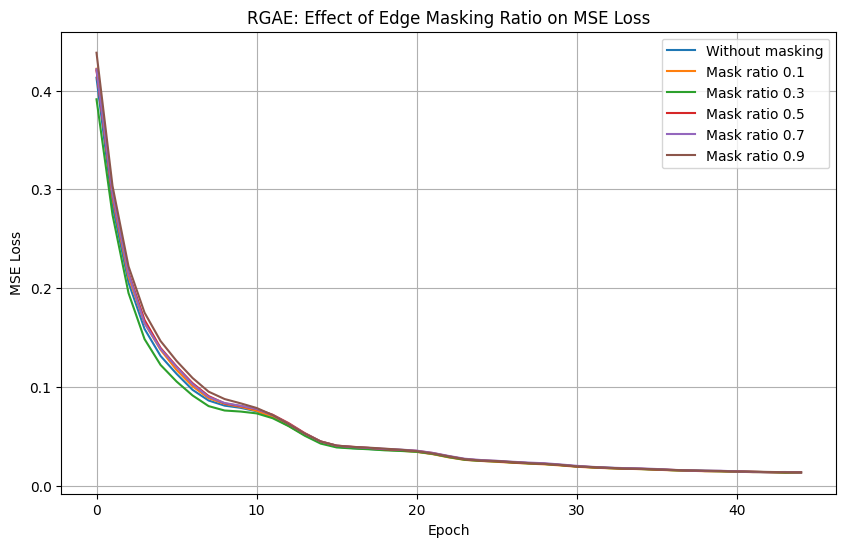

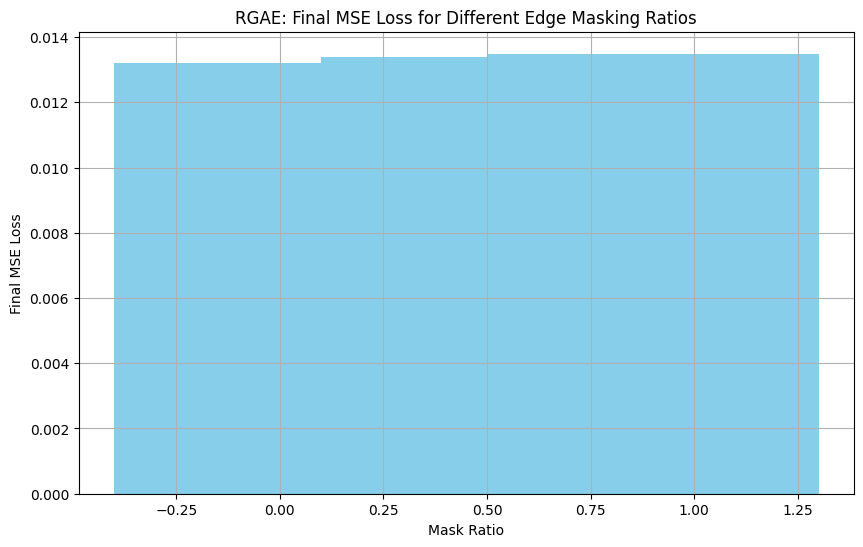

Test Structure Error: 0.003226953325793147, Test Degree Error: 0.003231370821595192
Test Loss: (0.003226953325793147, 0.003231370821595192)
Training with mask ratio: 0.0
Epoch 0, Loss: 0.4261230230331421
Epoch 10, Loss: 0.07780392467975616
Epoch 20, Loss: 0.03494081273674965
Epoch 30, Loss: 0.019728507846593857
Epoch 40, Loss: 0.014490142464637756
Training with mask ratio: 0.1
Epoch 0, Loss: 0.44200414419174194
Epoch 10, Loss: 0.0801750048995018
Epoch 20, Loss: 0.03491600230336189
Epoch 30, Loss: 0.01939304545521736
Epoch 40, Loss: 0.014238281175494194
Training with mask ratio: 0.3
Epoch 0, Loss: 0.39628949761390686
Epoch 10, Loss: 0.07474419474601746
Epoch 20, Loss: 0.03399122506380081
Epoch 30, Loss: 0.019419260323047638
Epoch 40, Loss: 0.014297837391495705
Training with mask ratio: 0.5
Epoch 0, Loss: 0.42107588052749634
Epoch 10, Loss: 0.07625482976436615
Epoch 20, Loss: 0.034200530499219894
Epoch 30, Loss: 0.019245127215981483
Epoch 40, Loss: 0.014079466462135315
Training with mask

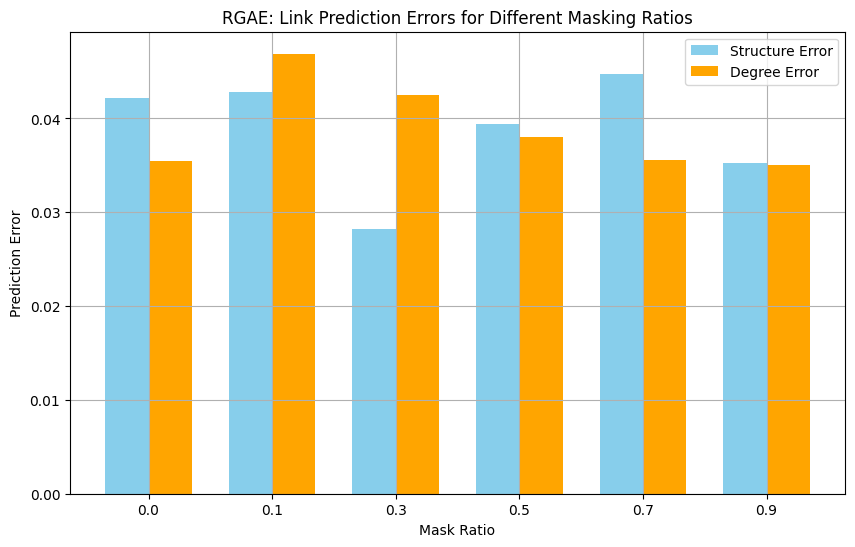

Visualizing encoded features for mask ratio: 0.0


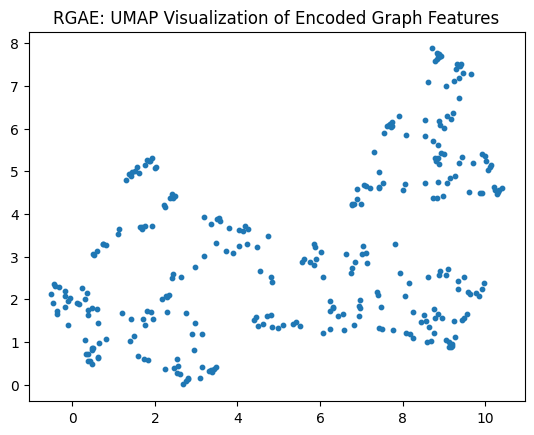

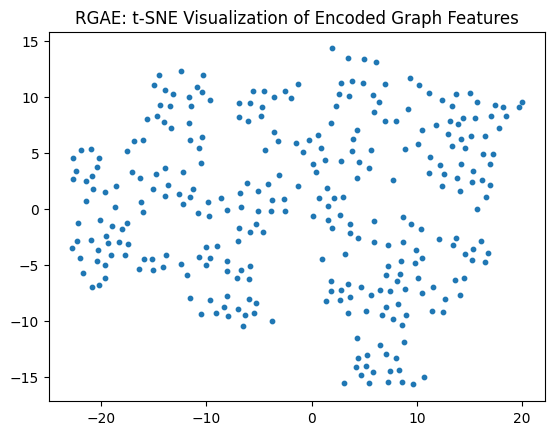

Visualizing encoded features for mask ratio: 0.1


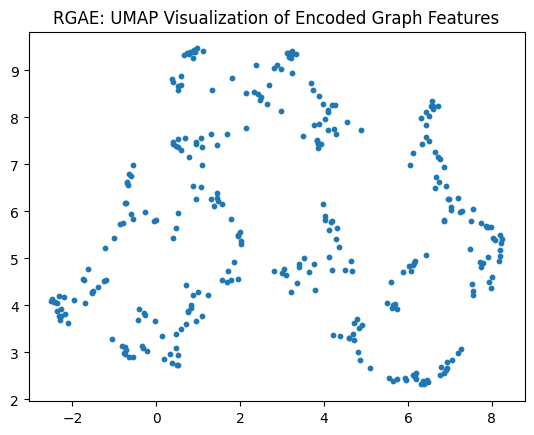

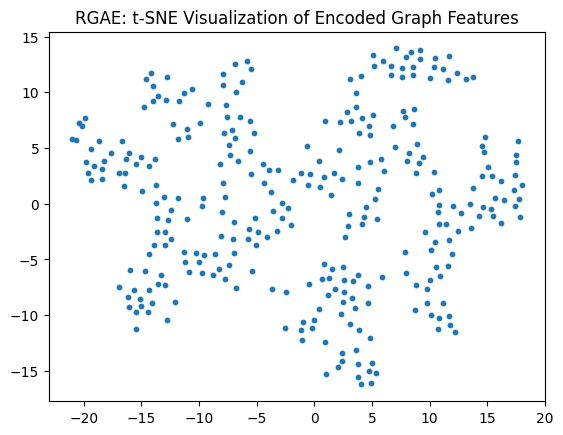

Visualizing encoded features for mask ratio: 0.3


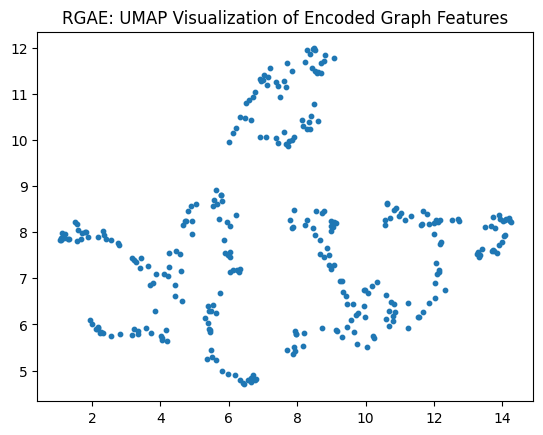

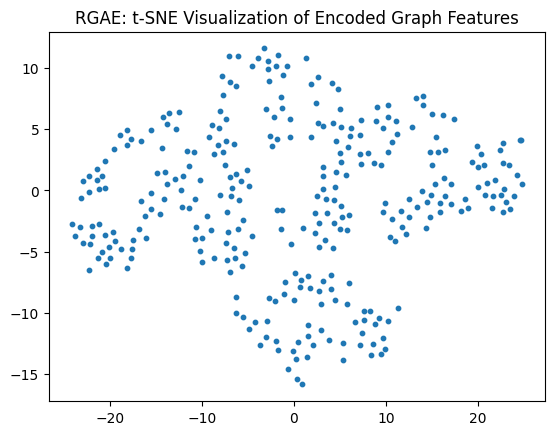

Visualizing encoded features for mask ratio: 0.5


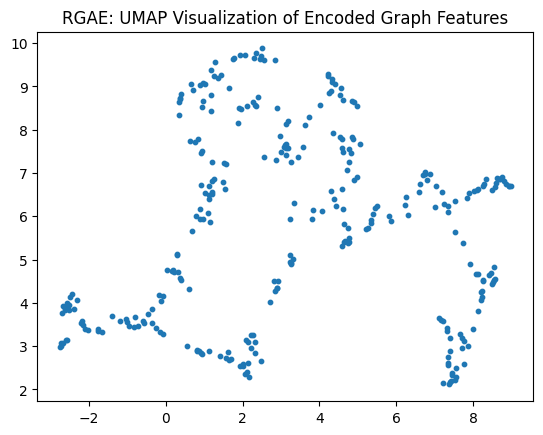

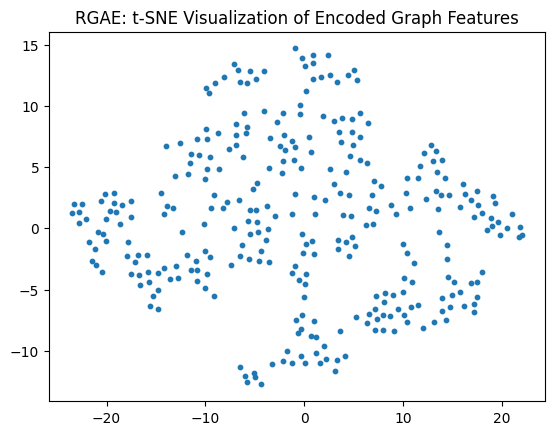

Visualizing encoded features for mask ratio: 0.7


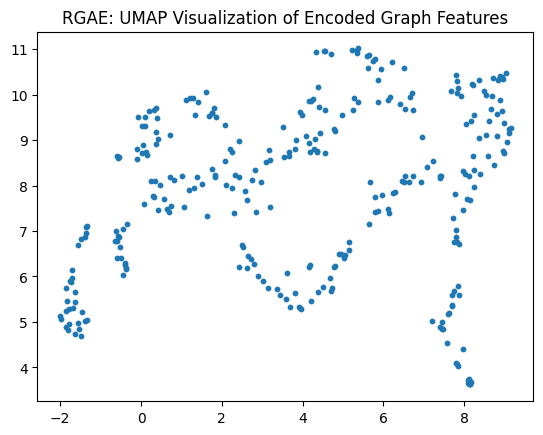

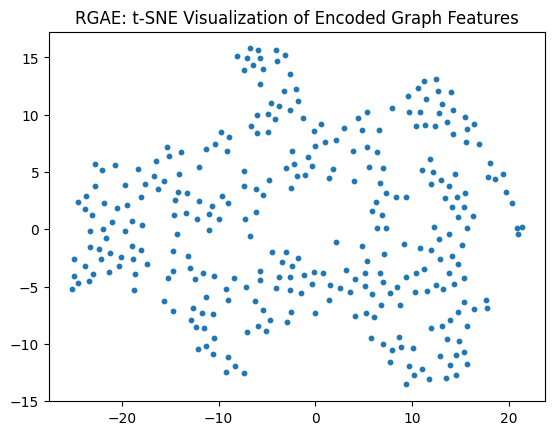

Visualizing encoded features for mask ratio: 0.9


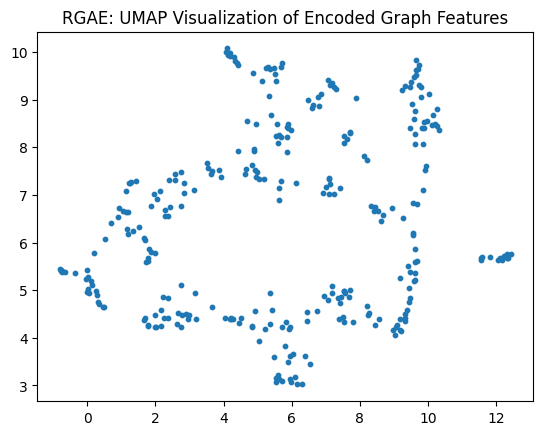

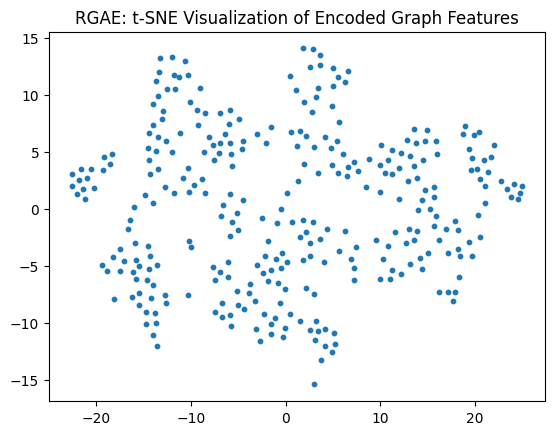

In [ ]:
import torch
import networkx as nx
import numpy as np
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import umap
from sklearn.manifold import TSNE

CUSTOM_EPOCHS = 45

# Generowanie losowego grafu Erdos-Renyi
num_nodes = 312
prob = 0.1
G = nx.erdos_renyi_graph(num_nodes, prob)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
data = Data(x=x, edge_index=edge_index)

## Podział na zbiór treningowy i testowy
def split_edges(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    # Wygenerowanie losowego permutacji indeksów
    perm = torch.randperm(num_edges)
    test_size = int(num_edges * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm[:test_size]]
    train_edge_index = edge_index[:, perm[test_size:]]

    # Utworzenie dwóch obiektów Data: jeden dla treningu, drugi dla testowania
    train_data = Data(x=data.x, edge_index=train_edge_index)
    test_data = Data(x=data.x, edge_index=test_edge_index)

    return train_data, test_data

train_data, test_data = split_edges(data, test_ratio=0.2)

## Implementacja Autoenkodera Grafowego RobustGraphAE
class RobustGraphAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, dropout=0.5):
        super(RobustGraphAE, self).__init__()

        # Enkoder z dwoma warstwami GCN i dodatkową warstwą liniową
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.linear = nn.Linear(hidden_channels, out_channels)

        # Dekoder struktury z dwoma warstwami MLP i dodatkową warstwą Dropout
        self.structure_decoder = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, in_channels)
        )

        # Dekoder stopnia z dwoma warstwami MLP i dodatkową warstwą Dropout
        self.degree_decoder = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, in_channels)
        )

        # Dodatkowa warstwa do generowania perturbacji
        self.perturbation_layer = nn.Linear(in_channels, in_channels)

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.linear(x)

    def decode_structure(self, z):
        return self.structure_decoder(z)

    def decode_degree(self, z):
        return self.degree_decoder(z)

    def generate_perturbation(self, x):
        return torch.tanh(self.perturbation_layer(x))

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        structure_reconstruction = self.decode_structure(z)
        degree_prediction = self.decode_degree(z)

        # Generujemy perturbację wejścia
        perturbation = self.generate_perturbation(x)
        perturbed_x = x + perturbation

        # Przebieg przodu dla danych zakłóconych
        perturbed_z = self.encode(perturbed_x, edge_index)
        perturbed_structure_reconstruction = self.decode_structure(perturbed_z)
        perturbed_degree_prediction = self.decode_degree(perturbed_z)

        return structure_reconstruction, degree_prediction, \
               perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction

# Funkcja straty dla RobustGraphAE
def robust_graph_ae_loss(model, x, edge_index, alpha=0.5, beta=0.3):
    structure_reconstruction, degree_prediction, \
    perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction = model(x, edge_index)

    # Strata rekonstrukcji struktury
    structure_loss = F.mse_loss(structure_reconstruction, x)

    # Strata predykcji stopnia
    degree_loss = F.mse_loss(degree_prediction, x)

    # Strata spójności między rekonstrukcjami zakłóconymi i niezakłóconymi
    consistency_loss = F.mse_loss(perturbed_structure_reconstruction, structure_reconstruction) + \
                       F.mse_loss(perturbed_degree_prediction, degree_prediction)

    # Regularizacja perturbacji
    perturbation_regularization = torch.mean(torch.norm(perturbation, dim=-1))

    total_loss = structure_loss + degree_loss + alpha * consistency_loss + beta * perturbation_regularization

    return total_loss

## Maskowanie krawędzi
def mask_edges(data, mask_ratio):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    mask_indices = random.sample(range(num_edges), num_mask)
    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

## Trening modelu z użyciem zbioru treningowego i ocena na zbiorze testowym
def train_and_evaluate(in_channels, out_channels, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    criterion = robust_graph_ae_loss  # Zaktualizowana funkcja straty

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        # Inicjalizacja nowego modelu dla każdego mask_ratio
        model = RobustGraphAE(in_channels=in_channels, out_channels=out_channels)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            structure_reconstruction, degree_prediction, \
            perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction = model(masked_train_data.x, masked_train_data.edge_index)

            # Zmodyfikowana funkcja straty
            loss = criterion(model, masked_train_data.x, masked_train_data.edge_index)

            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
    return results, model

# Funkcja do oceny modelu na zbiorze testowym
def evaluate_on_test(model, test_data):
    model.eval()
    with torch.no_grad():  # Wyłącz gradienty podczas testowania
        # Przebieg przodu dla danych testowych
        structure_reconstruction, degree_prediction, \
        perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction = model(test_data.x, test_data.edge_index)

        # Obliczenie błędów predykcji dla rekonstrukcji struktury i stopnia wierzchołków
        structure_error = F.mse_loss(structure_reconstruction, test_data.x).item()
        degree_error = F.mse_loss(degree_prediction, test_data.x).item()

        print(f'Test Structure Error: {structure_error}, Test Degree Error: {degree_error}')
        return structure_error, degree_error

## Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('RGAE: Effect of Edge Masking Ratio on MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def final_loss_comparison(results):
    final_losses = {ratio: losses[-1] for ratio, losses in results.items()}
    ratios = list(final_losses.keys())
    losses = list(final_losses.values())

    plt.figure(figsize=(10, 6))
    plt.bar(ratios, losses, color='skyblue')
    plt.xlabel('Mask Ratio')
    plt.ylabel('Final MSE Loss')
    plt.title('RGAE: Final MSE Loss for Different Edge Masking Ratios')
    plt.grid(True)
    plt.show()

def predict(model, data):
    model.eval()
    with torch.no_grad():
        structure_reconstruction, degree_prediction, \
        perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction = model(data.x, data.edge_index)
        return structure_reconstruction, degree_prediction, perturbation

def calculate_prediction_error(pred_structure, pred_degree, data):
    structure_error = torch.nn.functional.mse_loss(pred_structure, data.x).item()
    degree_error = torch.nn.functional.mse_loss(pred_degree, data.x).item()
    return structure_error, degree_error

# Funkcja do wizualizacji UMAP i t-SNE
def visualize_latent_space(z, method='UMAP'):
    if method == 'UMAP':
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
        embedding = reducer.fit_transform(z.detach().cpu().numpy())
        plt.title('RGAE: UMAP Visualization of Encoded Graph Features')
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
        embedding = reducer.fit_transform(z.detach().cpu().numpy())
        plt.title('RGAE: t-SNE Visualization of Encoded Graph Features')

    plt.scatter(embedding[:, 0], embedding[:, 1], s=10)
    plt.show()

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]  # Including 0.0 for no masking
results, trained_model = train_and_evaluate(in_channels=train_data.num_features, out_channels=2, train_data=train_data, test_data=test_data, mask_ratios=mask_ratios, epochs=CUSTOM_EPOCHS)
plot_results(results)
final_loss_comparison(results)

# Ewaluacja na zbiorze testowym
test_loss = evaluate_on_test(trained_model, test_data)
print(f"Test Loss: {test_loss}")

# Predykcja na nieolabelowanych danych
unlabeled_data = test_data  # In real scenario, use a different unlabeled dataset

predictions = {}
errors = {}
encoded_representations = {}
for ratio in mask_ratios:
    model = RobustGraphAE(in_channels=data.num_features, out_channels=2)
    train_and_evaluate(train_data.num_features, 2, train_data, test_data, [ratio], epochs=CUSTOM_EPOCHS)
    pred_structure, pred_degree, perturbation = predict(model, unlabeled_data)
    structure_error, degree_error = calculate_prediction_error(pred_structure, pred_degree, unlabeled_data)
    errors[ratio] = (structure_error, degree_error)
    encoded_representations[ratio] = pred_structure  # Adjusted to reflect encoded representations

# Wizualizacja błędów predykcji
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(errors))
index_shifted = index + bar_width

# Wizualizacja błędów predykcji
plt.bar(index, [e[0] for e in errors.values()], width=bar_width, label='Structure Error', color='skyblue')
plt.bar(index_shifted, [e[1] for e in errors.values()], width=bar_width, label='Degree Error', color='orange')
plt.xlabel('Mask Ratio')
plt.ylabel('Prediction Error')
plt.title('RGAE: Link Prediction Errors for Different Masking Ratios')
plt.xticks(index + bar_width / 2, errors.keys())
plt.legend()
plt.grid(True)
plt.show()

# Wizualizacja zakodowanych reprezentacji z użyciem UMAP i t-SNE
for ratio, z in encoded_representations.items():
    print(f"Visualizing encoded features for mask ratio: {ratio}")

    # UMAP
    visualize_latent_space(z, method='UMAP')

    # t-SNE
    visualize_latent_space(z, method='t-SNE')


## Klasyfikacja społeczności

Training with mask ratio: 0.0
Epoch 0, Loss: 0.640599250793457
Epoch 10, Loss: 0.250884473323822
Epoch 20, Loss: 0.11943145841360092
Epoch 30, Loss: 0.04678111523389816
Epoch 40, Loss: 0.023410482332110405
Epoch 50, Loss: 0.015271585434675217
Training with mask ratio: 0.1
Epoch 0, Loss: 0.6430407762527466
Epoch 10, Loss: 0.2739641070365906
Epoch 20, Loss: 0.17467927932739258
Epoch 30, Loss: 0.114235058426857
Epoch 40, Loss: 0.047425948083400726
Epoch 50, Loss: 0.023236941546201706
Training with mask ratio: 0.3
Epoch 0, Loss: 0.6364485621452332
Epoch 10, Loss: 0.2693325877189636
Epoch 20, Loss: 0.17048028111457825
Epoch 30, Loss: 0.10337382555007935
Epoch 40, Loss: 0.05090200901031494
Epoch 50, Loss: 0.028591230511665344
Training with mask ratio: 0.5
Epoch 0, Loss: 0.6383551359176636
Epoch 10, Loss: 0.26819801330566406
Epoch 20, Loss: 0.14727577567100525
Epoch 30, Loss: 0.057962581515312195
Epoch 40, Loss: 0.04158207029104233
Epoch 50, Loss: 0.030935266986489296
Training with mask ratio

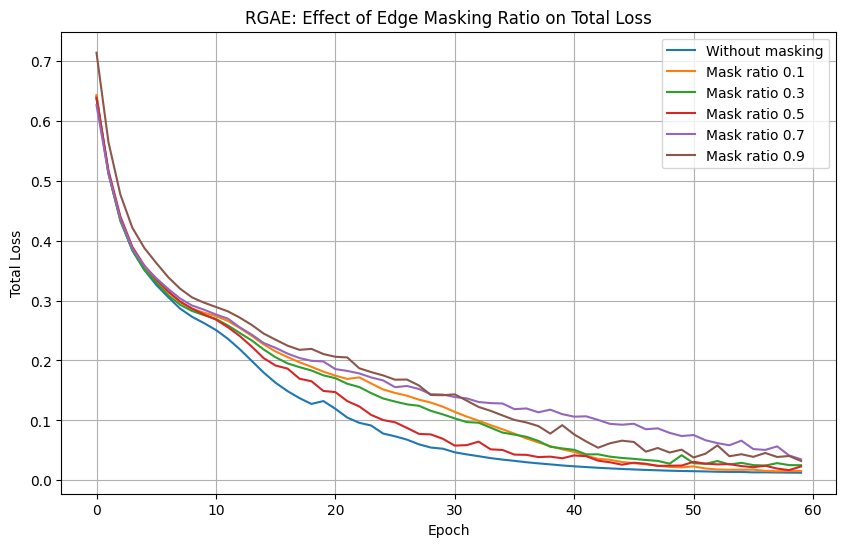

Test Accuracy for Node Classification: 0.6481
Test Loss: 0.007654025452211499
Test Accuracy: 0.6481


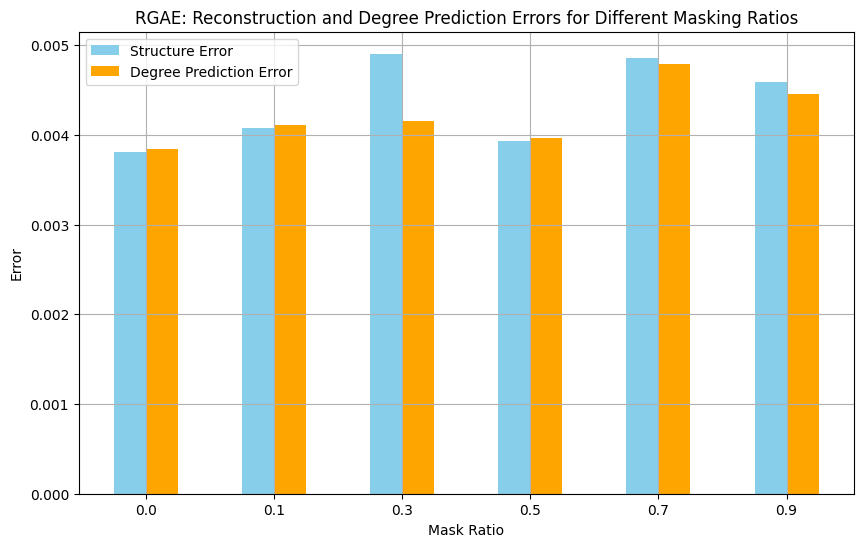

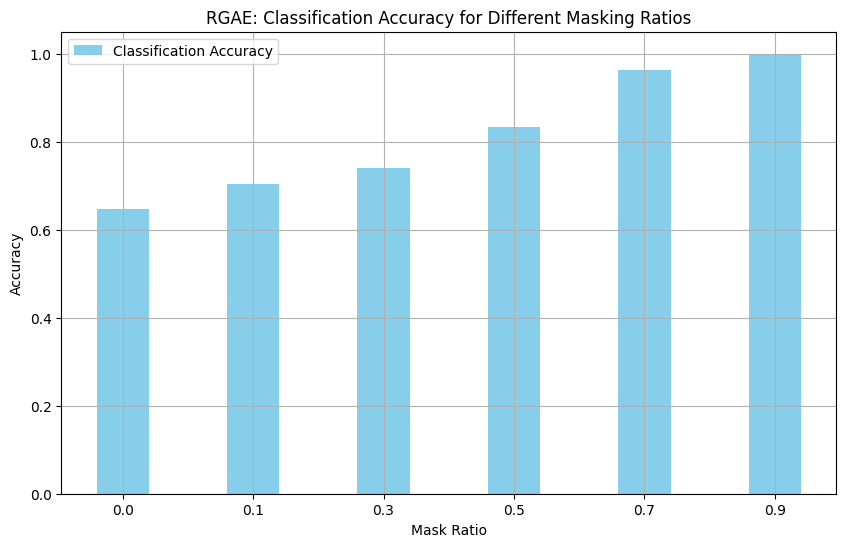

In [ ]:
import torch
import networkx as nx
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import f1_score

CUSTOM_EPOCHS = 60

# Generowanie grafu za pomocą Stochastic Block Model (SBM)
num_nodes = 270
sizes = [90, 90, 90]  # Liczba węzłów w każdej społeczności (bloku)
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.25]]  # Macierz prawdopodobieństw krawędzi między społecznościami
G = nx.stochastic_block_model(sizes, probs)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
labels = torch.zeros(num_nodes, dtype=torch.long)

# Przydzielanie etykiet węzłom na podstawie społeczności
for i, size in enumerate(sizes):
    labels[sum(sizes[:i]):sum(sizes[:i+1])] = i

data = Data(x=x, edge_index=edge_index, y=labels)

# Podział na zbiór treningowy i testowy
def split_edges_and_nodes(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    num_nodes = data.num_nodes

    # Wygenerowanie losowego permutacji indeksów
    perm_edges = torch.randperm(num_edges)
    perm_nodes = torch.randperm(num_nodes)
    test_size_edges = int(num_edges * test_ratio)
    test_size_nodes = int(num_nodes * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm_edges[:test_size_edges]]
    train_edge_index = edge_index[:, perm_edges[test_size_edges:]]
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[perm_nodes[test_size_nodes:]] = True
    test_mask[perm_nodes[:test_size_nodes]] = True

    train_data = Data(x=data.x, edge_index=train_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)
    test_data = Data(x=data.x, edge_index=test_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)

    return train_data, test_data

train_data, test_data = split_edges_and_nodes(data, test_ratio=0.2)

# Implementacja Autoenkodera Grafowego RobustGraphAE
class RobustGraphAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, dropout=0.5, num_classes=3):
        super(RobustGraphAE, self).__init__()

        # Enkoder z dwoma warstwami GCN i dodatkową warstwą liniową
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.linear = nn.Linear(hidden_channels, out_channels)

        # Warstwa klasyfikacyjna
        self.classifier = nn.Linear(out_channels, num_classes)

        # Dekoder struktury
        self.structure_decoder = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, in_channels)
        )

        # Dekoder stopnia
        self.degree_decoder = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, in_channels)
        )

        # Warstwa perturbacji
        self.perturbation_layer = nn.Linear(in_channels, in_channels)

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.linear(x)

    def decode_structure(self, z):
        return self.structure_decoder(z)

    def decode_degree(self, z):
        return self.degree_decoder(z)

    def classify(self, z):
        return self.classifier(z)

    def generate_perturbation(self, x):
        return torch.tanh(self.perturbation_layer(x))

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        structure_reconstruction = self.decode_structure(z)
        degree_prediction = self.decode_degree(z)
        class_logits = self.classify(z)

        # Generujemy perturbację wejścia
        perturbation = self.generate_perturbation(x)
        perturbed_x = x + perturbation

        # Przebieg przodu dla danych zakłóconych
        perturbed_z = self.encode(perturbed_x, edge_index)
        perturbed_structure_reconstruction = self.decode_structure(perturbed_z)
        perturbed_degree_prediction = self.decode_degree(perturbed_z)

        return structure_reconstruction, degree_prediction, class_logits, \
               perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction

# Funkcja straty dla RobustGraphAE
def robust_graph_ae_loss(model, x, edge_index, y, alpha=0.5, beta=0.3, gamma=0.2):
    structure_reconstruction, degree_prediction, class_logits, \
    perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction = model(x, edge_index)

    # Strata rekonstrukcji struktury
    structure_loss = F.mse_loss(structure_reconstruction, x)

    # Strata predykcji stopnia
    degree_loss = F.mse_loss(degree_prediction, x)

    # Strata klasyfikacji węzłów
    classification_loss = F.cross_entropy(class_logits, y)

    # Strata spójności między rekonstrukcjami zakłóconymi i niezakłóconymi
    consistency_loss = F.mse_loss(perturbed_structure_reconstruction, structure_reconstruction) + \
                      F.mse_loss(perturbed_degree_prediction, degree_prediction)

    # Regularizacja perturbacji
    perturbation_regularization = torch.mean(torch.norm(perturbation, dim=-1))

    total_loss = structure_loss + degree_loss + alpha * consistency_loss + beta * perturbation_regularization + gamma * classification_loss

    return total_loss

# Funkcja do maskowania krawędzi (bez zmian)
def mask_edges(data, mask_ratio):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    mask_indices = random.sample(range(num_edges), num_mask)
    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

# Trening modelu z klasyfikacją węzłów
def train_and_evaluate(in_channels, out_channels, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    models = {}  # Store trained models for each mask ratio

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        model = RobustGraphAE(in_channels=in_channels, out_channels=out_channels, num_classes=train_data.y.max().item() + 1)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            loss = robust_graph_ae_loss(model, masked_train_data.x, masked_train_data.edge_index, masked_train_data.y)
            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

        models[ratio] = model  # Save the trained model for this ratio

    return results, models

def evaluate_node_classification(model, data):
    model.eval()
    with torch.no_grad():
        _, _, class_logits, _, _, _ = model(data.x, data.edge_index)
        predictions = class_logits.argmax(dim=1)
        accuracy = (predictions[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return accuracy

def evaluate_on_test(model, test_data):
    model.eval()
    with torch.no_grad():
        structure_out, degree_out, class_logits, _, _, _ = model(test_data.x, test_data.edge_index)
        structure_error, degree_error = calculate_prediction_error(structure_out, degree_out, test_data)
        classification_accuracy = calculate_classification_accuracy(class_logits, test_data)
        total_error = structure_error + degree_error
    return total_error, classification_accuracy

# Funkcja do predykcji
def predict(model, data):
    model.eval()
    with torch.no_grad():
        structure_out, degree_out, _, _, _ = model(data.x, data.edge_index)
        return structure_out, degree_out

# Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('RGAE: Effect of Edge Masking Ratio on Total Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def calculate_prediction_error(pred_structure, pred_degree, data):
    structure_error = F.mse_loss(pred_structure, data.x).item()
    degree_error = F.mse_loss(pred_degree, data.x).item()
    return structure_error, degree_error

def calculate_classification_accuracy(class_logits, data):
    predictions = class_logits.argmax(dim=1)
    correct = (predictions[data.test_mask] == data.y[data.test_mask]).sum().item()
    accuracy = correct / data.test_mask.sum().item()
    return accuracy

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
results, trained_models = train_and_evaluate(
    in_channels=train_data.num_features,
    out_channels=2,
    train_data=train_data,
    test_data=test_data,
    mask_ratios=mask_ratios,
    epochs=CUSTOM_EPOCHS
)

plot_results(results)

test_accuracy = evaluate_node_classification(trained_models[0.0], test_data)
print(f"Test Accuracy for Node Classification: {test_accuracy:.4f}")

# Ewaluacja na zbiorze testowym
test_loss, test_accuracy = evaluate_on_test(trained_models[0.0], test_data)  # Evaluating with model trained without masking
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predykcja na nieolabelowanych danych
unlabeled_data = test_data  # W rzeczywistym scenariuszu użyj innego zbioru danych

predictions = {}
errors = {}
accuracies = {}
encoded_representations = {}

for ratio in mask_ratios:
    model = trained_models[ratio]  # Use the trained model for the specific mask ratio

    # Forward pass to get predictions
    pred_structure, pred_degree, class_logits, _, _, _ = model(unlabeled_data.x, unlabeled_data.edge_index)

    # Calculate errors and accuracy
    structure_error, degree_error = calculate_prediction_error(pred_structure, pred_degree, unlabeled_data)
    classification_accuracy = calculate_classification_accuracy(class_logits, unlabeled_data)

    errors[ratio] = (structure_error, degree_error)
    accuracies[ratio] = classification_accuracy
    encoded_representations[ratio] = pred_structure  # Save encoded representations

# Wizualizacja błędów predykcji i dokładności klasyfikacji
plt.figure(figsize=(10, 6))
bar_width = 0.25
index = np.arange(len(errors))

# Przesunięcie wszystkich słupków do środka
plt.bar(index - bar_width / 2, [e[0] for e in errors.values()], width=bar_width, label='Structure Error', color='skyblue')
plt.bar(index + bar_width / 2, [e[1] for e in errors.values()], width=bar_width, label='Degree Prediction Error', color='orange')

plt.xlabel('Mask Ratio')
plt.ylabel('Error')
plt.title('RGAE: Reconstruction and Degree Prediction Errors for Different Masking Ratios')
plt.xticks(index, [str(ratio) for ratio in errors.keys()])
plt.legend()
plt.grid(True)
plt.show()


# Prepare data for visualization of classification accuracy
plt.figure(figsize=(10, 6))
bar_width = 0.4
index = np.arange(len(accuracies))

# Plot classification accuracy for each mask ratio
plt.bar(index, list(accuracies.values()), width=bar_width, color='skyblue', label='Classification Accuracy')
plt.xlabel('Mask Ratio')
plt.ylabel('Accuracy')
plt.title('RGAE: Classification Accuracy for Different Masking Ratios')
plt.xticks(index, [str(ratio) for ratio in accuracies.keys()])
plt.legend()
plt.grid(True)
plt.show()

## 500 węzłów - Przewidywanie połaczeń

Training with mask ratio: 0.0
Epoch 0, Loss: 0.43207305669784546
Epoch 10, Loss: 0.06763045489788055
Epoch 20, Loss: 0.027423158288002014
Epoch 30, Loss: 0.017096638679504395
Epoch 40, Loss: 0.011984585784375668
Training with mask ratio: 0.1
Epoch 0, Loss: 0.4127177298069
Epoch 10, Loss: 0.06788858771324158
Epoch 20, Loss: 0.026816237717866898
Epoch 30, Loss: 0.016824083402752876
Epoch 40, Loss: 0.012097269296646118
Training with mask ratio: 0.3
Epoch 0, Loss: 0.40064477920532227
Epoch 10, Loss: 0.06583239138126373
Epoch 20, Loss: 0.02695898711681366
Epoch 30, Loss: 0.0167594812810421
Epoch 40, Loss: 0.012087837792932987
Training with mask ratio: 0.5
Epoch 0, Loss: 0.4393570125102997
Epoch 10, Loss: 0.0720907673239708
Epoch 20, Loss: 0.028315946459770203
Epoch 30, Loss: 0.017648953944444656
Epoch 40, Loss: 0.012453972361981869
Training with mask ratio: 0.7
Epoch 0, Loss: 0.4097408652305603
Epoch 10, Loss: 0.06516443192958832
Epoch 20, Loss: 0.026721728965640068
Epoch 30, Loss: 0.016808

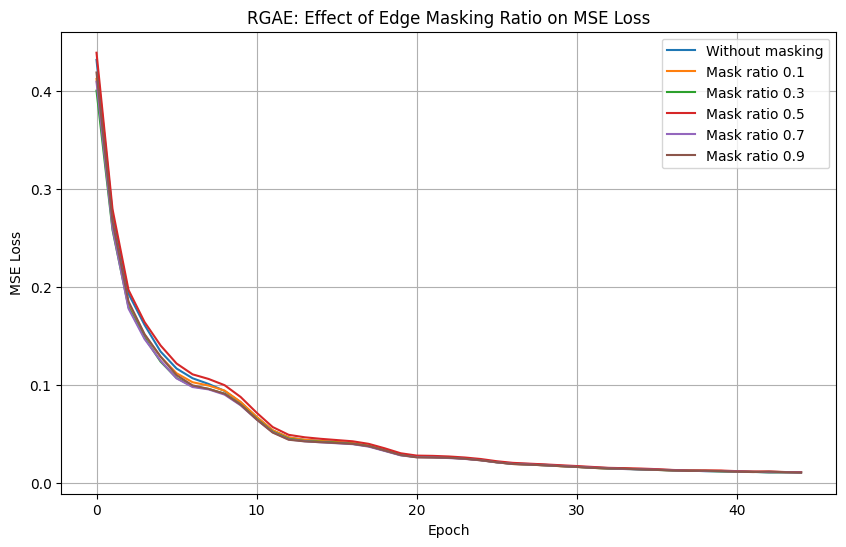

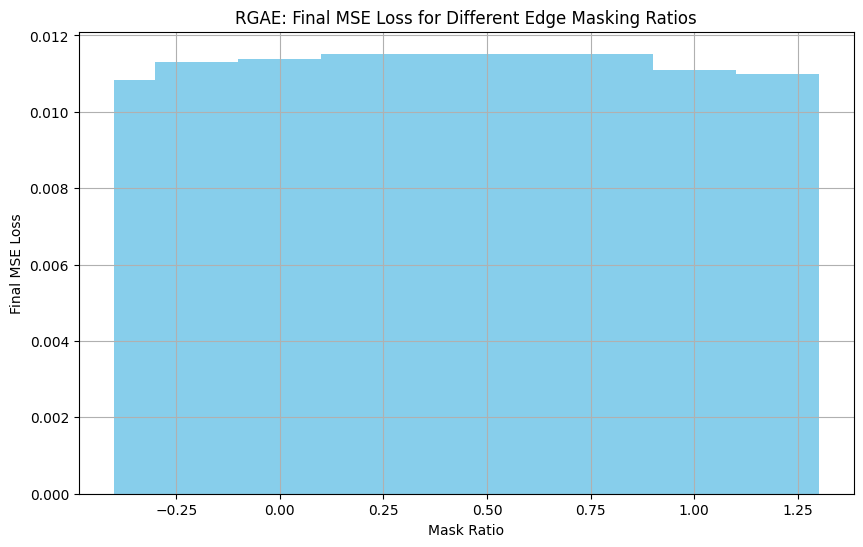

Test Structure Error: 0.0016257580136880279, Test Degree Error: 0.001618304057046771
Test Loss: (0.0016257580136880279, 0.001618304057046771)
Training with mask ratio: 0.0
Epoch 0, Loss: 0.417667031288147
Epoch 10, Loss: 0.06795913726091385
Epoch 20, Loss: 0.02752329222857952
Epoch 30, Loss: 0.017059726640582085
Epoch 40, Loss: 0.012073911726474762
Training with mask ratio: 0.1
Epoch 0, Loss: 0.43081021308898926
Epoch 10, Loss: 0.06899218261241913
Epoch 20, Loss: 0.027614165097475052
Epoch 30, Loss: 0.016991540789604187
Epoch 40, Loss: 0.012051410973072052
Training with mask ratio: 0.3
Epoch 0, Loss: 0.42113006114959717
Epoch 10, Loss: 0.06934435665607452
Epoch 20, Loss: 0.027499878779053688
Epoch 30, Loss: 0.017266197130084038
Epoch 40, Loss: 0.012032655067741871
Training with mask ratio: 0.5
Epoch 0, Loss: 0.38984930515289307
Epoch 10, Loss: 0.06251589953899384
Epoch 20, Loss: 0.02594013325870037
Epoch 30, Loss: 0.016461990773677826
Epoch 40, Loss: 0.011750134639441967
Training with 

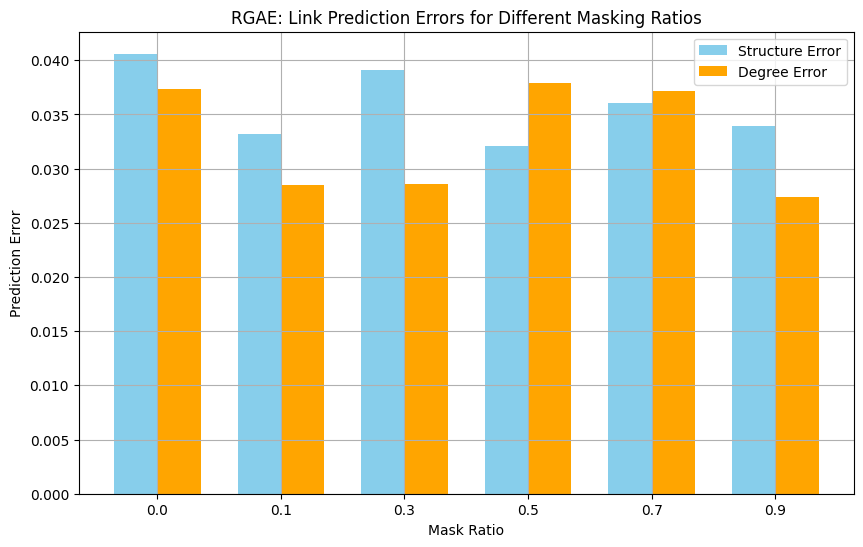

Visualizing encoded features for mask ratio: 0.0


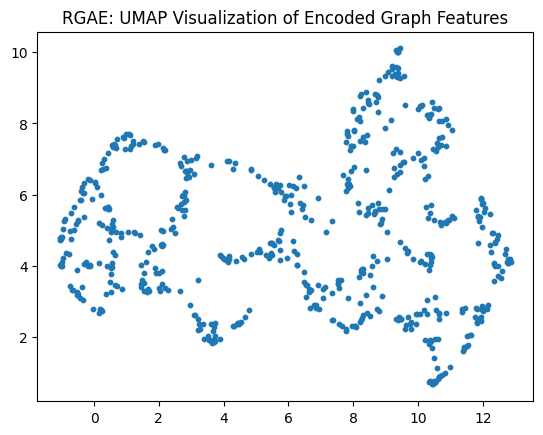

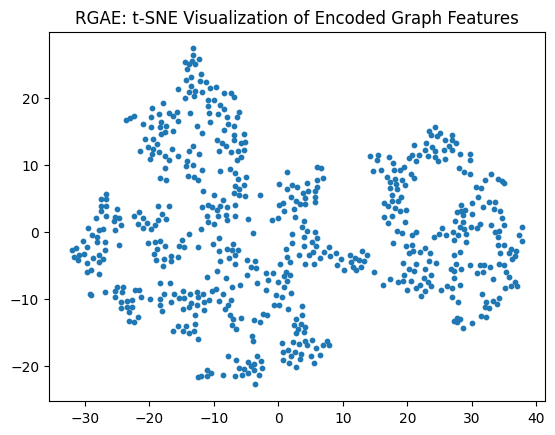

Visualizing encoded features for mask ratio: 0.1


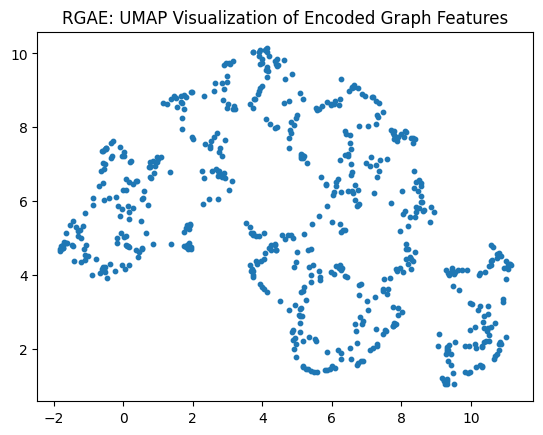

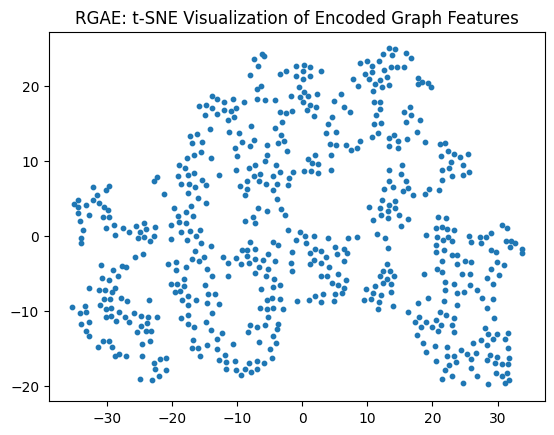

Visualizing encoded features for mask ratio: 0.3


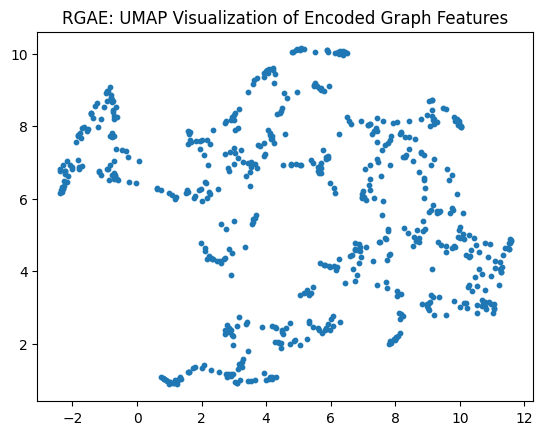

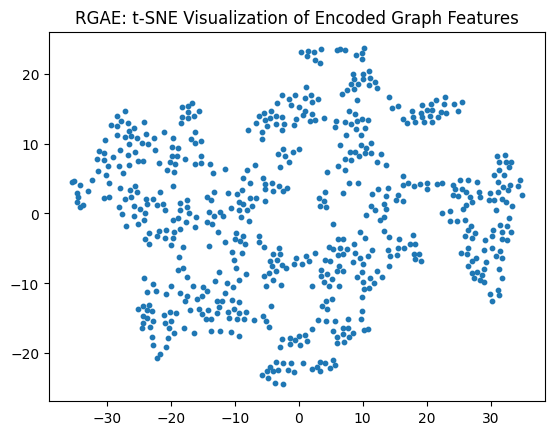

Visualizing encoded features for mask ratio: 0.5


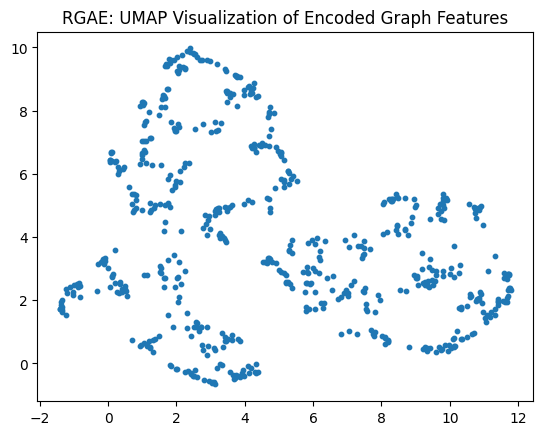

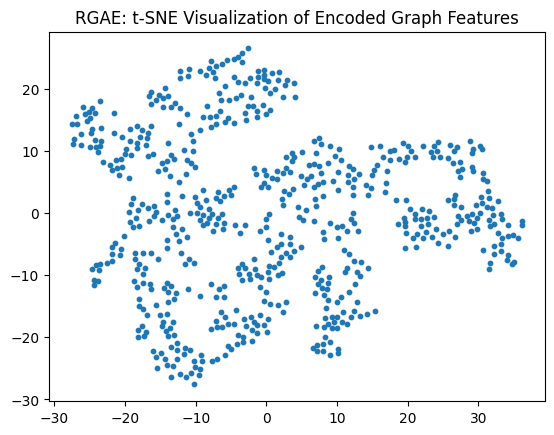

Visualizing encoded features for mask ratio: 0.7


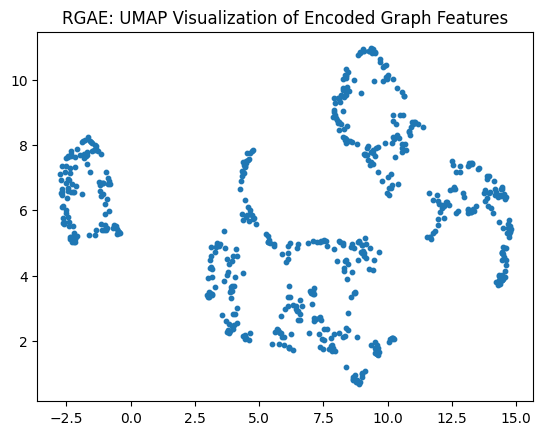

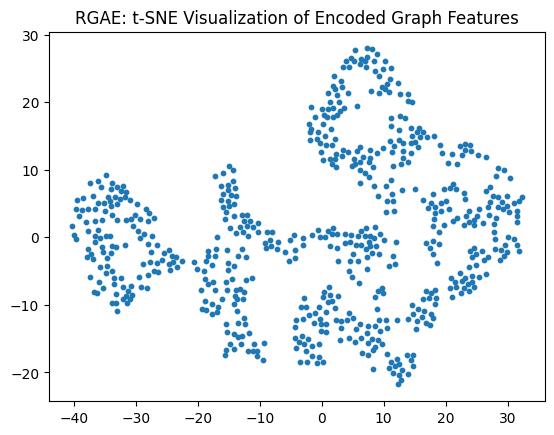

Visualizing encoded features for mask ratio: 0.9


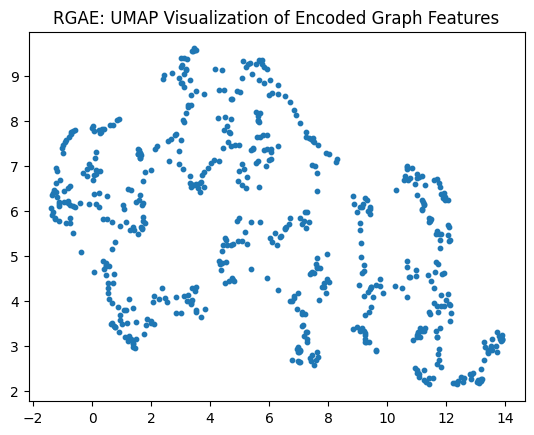

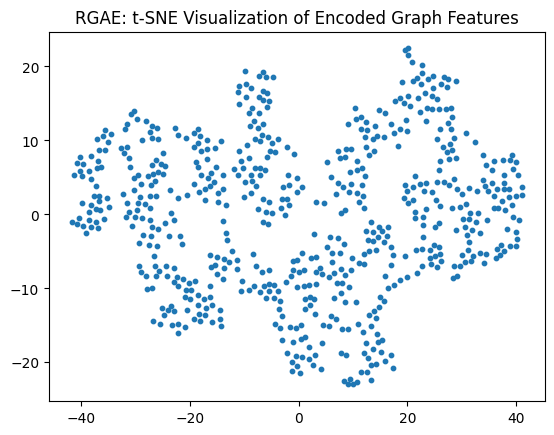

In [ ]:
import torch
import networkx as nx
import numpy as np
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import umap
from sklearn.manifold import TSNE

CUSTOM_EPOCHS = 45

# Generowanie losowego grafu Erdos-Renyi
num_nodes = 625
prob = 0.1
G = nx.erdos_renyi_graph(num_nodes, prob)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
data = Data(x=x, edge_index=edge_index)

## Podział na zbiór treningowy i testowy
def split_edges(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    # Wygenerowanie losowego permutacji indeksów
    perm = torch.randperm(num_edges)
    test_size = int(num_edges * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm[:test_size]]
    train_edge_index = edge_index[:, perm[test_size:]]

    # Utworzenie dwóch obiektów Data: jeden dla treningu, drugi dla testowania
    train_data = Data(x=data.x, edge_index=train_edge_index)
    test_data = Data(x=data.x, edge_index=test_edge_index)

    return train_data, test_data

train_data, test_data = split_edges(data, test_ratio=0.2)

## Implementacja Autoenkodera Grafowego RobustGraphAE
class RobustGraphAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, dropout=0.5):
        super(RobustGraphAE, self).__init__()

        # Enkoder z dwoma warstwami GCN i dodatkową warstwą liniową
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.linear = nn.Linear(hidden_channels, out_channels)

        # Dekoder struktury z dwoma warstwami MLP i dodatkową warstwą Dropout
        self.structure_decoder = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, in_channels)
        )

        # Dekoder stopnia z dwoma warstwami MLP i dodatkową warstwą Dropout
        self.degree_decoder = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, in_channels)
        )

        # Dodatkowa warstwa do generowania perturbacji
        self.perturbation_layer = nn.Linear(in_channels, in_channels)

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.linear(x)

    def decode_structure(self, z):
        return self.structure_decoder(z)

    def decode_degree(self, z):
        return self.degree_decoder(z)

    def generate_perturbation(self, x):
        return torch.tanh(self.perturbation_layer(x))

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        structure_reconstruction = self.decode_structure(z)
        degree_prediction = self.decode_degree(z)

        # Generujemy perturbację wejścia
        perturbation = self.generate_perturbation(x)
        perturbed_x = x + perturbation

        # Przebieg przodu dla danych zakłóconych
        perturbed_z = self.encode(perturbed_x, edge_index)
        perturbed_structure_reconstruction = self.decode_structure(perturbed_z)
        perturbed_degree_prediction = self.decode_degree(perturbed_z)

        return structure_reconstruction, degree_prediction, \
               perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction

# Funkcja straty dla RobustGraphAE
def robust_graph_ae_loss(model, x, edge_index, alpha=0.5, beta=0.3):
    structure_reconstruction, degree_prediction, \
    perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction = model(x, edge_index)

    # Strata rekonstrukcji struktury
    structure_loss = F.mse_loss(structure_reconstruction, x)

    # Strata predykcji stopnia
    degree_loss = F.mse_loss(degree_prediction, x)

    # Strata spójności między rekonstrukcjami zakłóconymi i niezakłóconymi
    consistency_loss = F.mse_loss(perturbed_structure_reconstruction, structure_reconstruction) + \
                       F.mse_loss(perturbed_degree_prediction, degree_prediction)

    # Regularizacja perturbacji
    perturbation_regularization = torch.mean(torch.norm(perturbation, dim=-1))

    total_loss = structure_loss + degree_loss + alpha * consistency_loss + beta * perturbation_regularization

    return total_loss

## Maskowanie krawędzi
def mask_edges(data, mask_ratio):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    mask_indices = random.sample(range(num_edges), num_mask)
    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

## Trening modelu z użyciem zbioru treningowego i ocena na zbiorze testowym
def train_and_evaluate(in_channels, out_channels, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    criterion = robust_graph_ae_loss  # Zaktualizowana funkcja straty

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        # Inicjalizacja nowego modelu dla każdego mask_ratio
        model = RobustGraphAE(in_channels=in_channels, out_channels=out_channels)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            structure_reconstruction, degree_prediction, \
            perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction = model(masked_train_data.x, masked_train_data.edge_index)

            # Zmodyfikowana funkcja straty
            loss = criterion(model, masked_train_data.x, masked_train_data.edge_index)

            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
    return results, model

# Funkcja do oceny modelu na zbiorze testowym
def evaluate_on_test(model, test_data):
    model.eval()
    with torch.no_grad():  # Wyłącz gradienty podczas testowania
        # Przebieg przodu dla danych testowych
        structure_reconstruction, degree_prediction, \
        perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction = model(test_data.x, test_data.edge_index)

        # Obliczenie błędów predykcji dla rekonstrukcji struktury i stopnia wierzchołków
        structure_error = F.mse_loss(structure_reconstruction, test_data.x).item()
        degree_error = F.mse_loss(degree_prediction, test_data.x).item()

        print(f'Test Structure Error: {structure_error}, Test Degree Error: {degree_error}')
        return structure_error, degree_error

## Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('RGAE: Effect of Edge Masking Ratio on MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def final_loss_comparison(results):
    final_losses = {ratio: losses[-1] for ratio, losses in results.items()}
    ratios = list(final_losses.keys())
    losses = list(final_losses.values())

    plt.figure(figsize=(10, 6))
    plt.bar(ratios, losses, color='skyblue')
    plt.xlabel('Mask Ratio')
    plt.ylabel('Final MSE Loss')
    plt.title('RGAE: Final MSE Loss for Different Edge Masking Ratios')
    plt.grid(True)
    plt.show()

def predict(model, data):
    model.eval()
    with torch.no_grad():
        structure_reconstruction, degree_prediction, \
        perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction = model(data.x, data.edge_index)
        return structure_reconstruction, degree_prediction, perturbation

def calculate_prediction_error(pred_structure, pred_degree, data):
    structure_error = torch.nn.functional.mse_loss(pred_structure, data.x).item()
    degree_error = torch.nn.functional.mse_loss(pred_degree, data.x).item()
    return structure_error, degree_error

# Funkcja do wizualizacji UMAP i t-SNE
def visualize_latent_space(z, method='UMAP'):
    if method == 'UMAP':
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
        embedding = reducer.fit_transform(z.detach().cpu().numpy())
        plt.title('RGAE: UMAP Visualization of Encoded Graph Features')
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000)
        embedding = reducer.fit_transform(z.detach().cpu().numpy())
        plt.title('RGAE: t-SNE Visualization of Encoded Graph Features')

    plt.scatter(embedding[:, 0], embedding[:, 1], s=10)
    plt.show()

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]  # Including 0.0 for no masking
results, trained_model = train_and_evaluate(in_channels=train_data.num_features, out_channels=2, train_data=train_data, test_data=test_data, mask_ratios=mask_ratios, epochs=CUSTOM_EPOCHS)
plot_results(results)
final_loss_comparison(results)

# Ewaluacja na zbiorze testowym
test_loss = evaluate_on_test(trained_model, test_data)
print(f"Test Loss: {test_loss}")

# Predykcja na nieolabelowanych danych
unlabeled_data = test_data  # In real scenario, use a different unlabeled dataset

predictions = {}
errors = {}
encoded_representations = {}
for ratio in mask_ratios:
    model = RobustGraphAE(in_channels=data.num_features, out_channels=2)
    train_and_evaluate(train_data.num_features, 2, train_data, test_data, [ratio], epochs=CUSTOM_EPOCHS)
    pred_structure, pred_degree, perturbation = predict(model, unlabeled_data)
    structure_error, degree_error = calculate_prediction_error(pred_structure, pred_degree, unlabeled_data)
    errors[ratio] = (structure_error, degree_error)
    encoded_representations[ratio] = pred_structure  # Adjusted to reflect encoded representations

# Wizualizacja błędów predykcji
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(errors))
index_shifted = index + bar_width

# Wizualizacja błędów predykcji
plt.bar(index, [e[0] for e in errors.values()], width=bar_width, label='Structure Error', color='skyblue')
plt.bar(index_shifted, [e[1] for e in errors.values()], width=bar_width, label='Degree Error', color='orange')
plt.xlabel('Mask Ratio')
plt.ylabel('Prediction Error')
plt.title('RGAE: Link Prediction Errors for Different Masking Ratios')
plt.xticks(index + bar_width / 2, errors.keys())
plt.legend()
plt.grid(True)
plt.show()

# Wizualizacja zakodowanych reprezentacji z użyciem UMAP i t-SNE
for ratio, z in encoded_representations.items():
    print(f"Visualizing encoded features for mask ratio: {ratio}")

    # UMAP
    visualize_latent_space(z, method='UMAP')

    # t-SNE
    visualize_latent_space(z, method='t-SNE')


## Klasyfikacja społeczności

Training with mask ratio: 0.0
Epoch 0, Loss: 0.669500470161438
Epoch 10, Loss: 0.2761160731315613
Epoch 20, Loss: 0.1774635910987854
Epoch 30, Loss: 0.11277136206626892
Epoch 40, Loss: 0.04784606397151947
Epoch 50, Loss: 0.020002301782369614
Training with mask ratio: 0.1
Epoch 0, Loss: 0.6389477252960205
Epoch 10, Loss: 0.27255475521087646
Epoch 20, Loss: 0.16536839306354523
Epoch 30, Loss: 0.09041491150856018
Epoch 40, Loss: 0.038154926151037216
Epoch 50, Loss: 0.020265422761440277
Training with mask ratio: 0.3
Epoch 0, Loss: 0.6796206831932068
Epoch 10, Loss: 0.24839577078819275
Epoch 20, Loss: 0.15424653887748718
Epoch 30, Loss: 0.11874095350503922
Epoch 40, Loss: 0.1082940623164177
Epoch 50, Loss: 0.10355478525161743
Training with mask ratio: 0.5
Epoch 0, Loss: 0.69106125831604
Epoch 10, Loss: 0.26325419545173645
Epoch 20, Loss: 0.15211910009384155
Epoch 30, Loss: 0.1097506582736969
Epoch 40, Loss: 0.09179936349391937
Epoch 50, Loss: 0.07664240896701813
Training with mask ratio: 0.

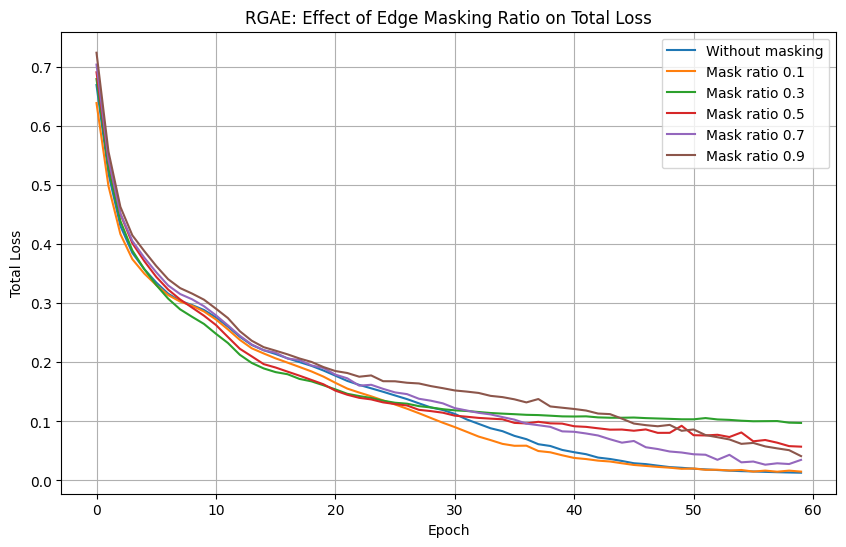

Test Accuracy for Node Classification: 0.7143
Test Loss: 0.005197666119784117
Test Accuracy: 0.7143


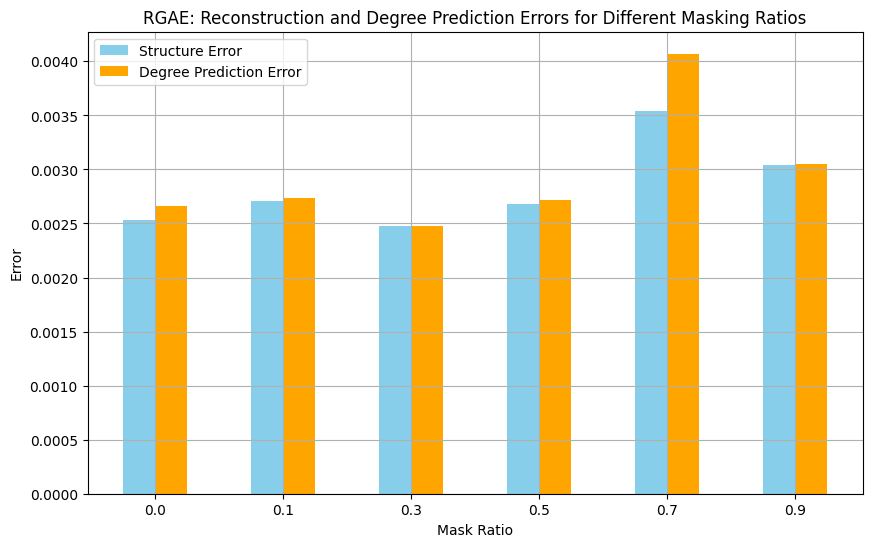

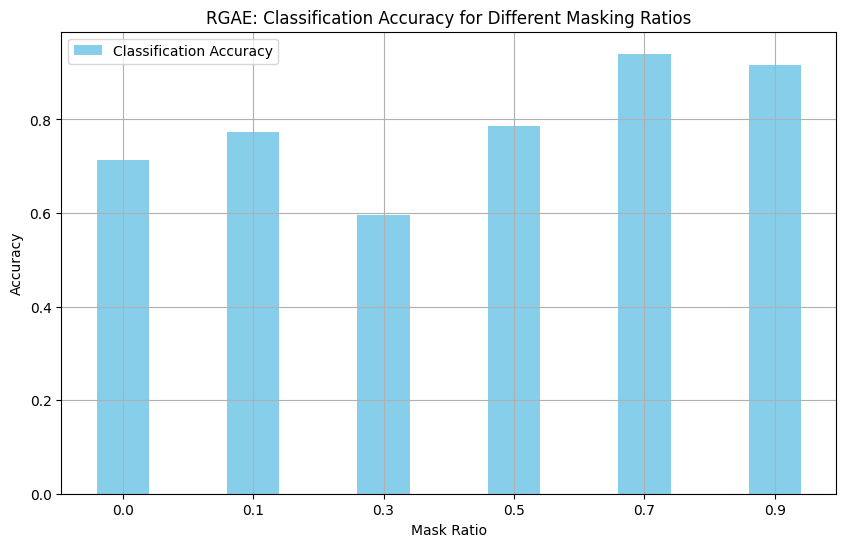

In [ ]:
import torch
import networkx as nx
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import f1_score

CUSTOM_EPOCHS = 60

# Generowanie grafu za pomocą Stochastic Block Model (SBM)
num_nodes = 423
sizes = [141, 141, 141]  # Liczba węzłów w każdej społeczności (bloku)
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.25]]  # Macierz prawdopodobieństw krawędzi między społecznościami
G = nx.stochastic_block_model(sizes, probs)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
labels = torch.zeros(num_nodes, dtype=torch.long)

# Przydzielanie etykiet węzłom na podstawie społeczności
for i, size in enumerate(sizes):
    labels[sum(sizes[:i]):sum(sizes[:i+1])] = i

data = Data(x=x, edge_index=edge_index, y=labels)

# Podział na zbiór treningowy i testowy
def split_edges_and_nodes(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    num_nodes = data.num_nodes

    # Wygenerowanie losowego permutacji indeksów
    perm_edges = torch.randperm(num_edges)
    perm_nodes = torch.randperm(num_nodes)
    test_size_edges = int(num_edges * test_ratio)
    test_size_nodes = int(num_nodes * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm_edges[:test_size_edges]]
    train_edge_index = edge_index[:, perm_edges[test_size_edges:]]
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[perm_nodes[test_size_nodes:]] = True
    test_mask[perm_nodes[:test_size_nodes]] = True

    train_data = Data(x=data.x, edge_index=train_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)
    test_data = Data(x=data.x, edge_index=test_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)

    return train_data, test_data

train_data, test_data = split_edges_and_nodes(data, test_ratio=0.2)

# Implementacja Autoenkodera Grafowego RobustGraphAE
class RobustGraphAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, dropout=0.5, num_classes=3):
        super(RobustGraphAE, self).__init__()

        # Enkoder z dwoma warstwami GCN i dodatkową warstwą liniową
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.linear = nn.Linear(hidden_channels, out_channels)

        # Warstwa klasyfikacyjna
        self.classifier = nn.Linear(out_channels, num_classes)

        # Dekoder struktury
        self.structure_decoder = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, in_channels)
        )

        # Dekoder stopnia
        self.degree_decoder = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, in_channels)
        )

        # Warstwa perturbacji
        self.perturbation_layer = nn.Linear(in_channels, in_channels)

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.linear(x)

    def decode_structure(self, z):
        return self.structure_decoder(z)

    def decode_degree(self, z):
        return self.degree_decoder(z)

    def classify(self, z):
        return self.classifier(z)

    def generate_perturbation(self, x):
        return torch.tanh(self.perturbation_layer(x))

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        structure_reconstruction = self.decode_structure(z)
        degree_prediction = self.decode_degree(z)
        class_logits = self.classify(z)

        # Generujemy perturbację wejścia
        perturbation = self.generate_perturbation(x)
        perturbed_x = x + perturbation

        # Przebieg przodu dla danych zakłóconych
        perturbed_z = self.encode(perturbed_x, edge_index)
        perturbed_structure_reconstruction = self.decode_structure(perturbed_z)
        perturbed_degree_prediction = self.decode_degree(perturbed_z)

        return structure_reconstruction, degree_prediction, class_logits, \
               perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction

# Funkcja straty dla RobustGraphAE
def robust_graph_ae_loss(model, x, edge_index, y, alpha=0.5, beta=0.3, gamma=0.2):
    structure_reconstruction, degree_prediction, class_logits, \
    perturbation, perturbed_structure_reconstruction, perturbed_degree_prediction = model(x, edge_index)

    # Strata rekonstrukcji struktury
    structure_loss = F.mse_loss(structure_reconstruction, x)

    # Strata predykcji stopnia
    degree_loss = F.mse_loss(degree_prediction, x)

    # Strata klasyfikacji węzłów
    classification_loss = F.cross_entropy(class_logits, y)

    # Strata spójności między rekonstrukcjami zakłóconymi i niezakłóconymi
    consistency_loss = F.mse_loss(perturbed_structure_reconstruction, structure_reconstruction) + \
                      F.mse_loss(perturbed_degree_prediction, degree_prediction)

    # Regularizacja perturbacji
    perturbation_regularization = torch.mean(torch.norm(perturbation, dim=-1))

    total_loss = structure_loss + degree_loss + alpha * consistency_loss + beta * perturbation_regularization + gamma * classification_loss

    return total_loss

# Funkcja do maskowania krawędzi (bez zmian)
def mask_edges(data, mask_ratio):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    mask_indices = random.sample(range(num_edges), num_mask)
    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

# Trening modelu z klasyfikacją węzłów
def train_and_evaluate(in_channels, out_channels, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    models = {}  # Store trained models for each mask ratio

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        model = RobustGraphAE(in_channels=in_channels, out_channels=out_channels, num_classes=train_data.y.max().item() + 1)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            loss = robust_graph_ae_loss(model, masked_train_data.x, masked_train_data.edge_index, masked_train_data.y)
            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

        models[ratio] = model  # Save the trained model for this ratio

    return results, models

def evaluate_node_classification(model, data):
    model.eval()
    with torch.no_grad():
        _, _, class_logits, _, _, _ = model(data.x, data.edge_index)
        predictions = class_logits.argmax(dim=1)
        accuracy = (predictions[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return accuracy

def evaluate_on_test(model, test_data):
    model.eval()
    with torch.no_grad():
        structure_out, degree_out, class_logits, _, _, _ = model(test_data.x, test_data.edge_index)
        structure_error, degree_error = calculate_prediction_error(structure_out, degree_out, test_data)
        classification_accuracy = calculate_classification_accuracy(class_logits, test_data)
        total_error = structure_error + degree_error
    return total_error, classification_accuracy

# Funkcja do predykcji
def predict(model, data):
    model.eval()
    with torch.no_grad():
        structure_out, degree_out, _, _, _ = model(data.x, data.edge_index)
        return structure_out, degree_out

# Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('RGAE: Effect of Edge Masking Ratio on Total Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def calculate_prediction_error(pred_structure, pred_degree, data):
    structure_error = F.mse_loss(pred_structure, data.x).item()
    degree_error = F.mse_loss(pred_degree, data.x).item()
    return structure_error, degree_error

def calculate_classification_accuracy(class_logits, data):
    predictions = class_logits.argmax(dim=1)
    correct = (predictions[data.test_mask] == data.y[data.test_mask]).sum().item()
    accuracy = correct / data.test_mask.sum().item()
    return accuracy

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
results, trained_models = train_and_evaluate(
    in_channels=train_data.num_features,
    out_channels=2,
    train_data=train_data,
    test_data=test_data,
    mask_ratios=mask_ratios,
    epochs=CUSTOM_EPOCHS
)

plot_results(results)

test_accuracy = evaluate_node_classification(trained_models[0.0], test_data)
print(f"Test Accuracy for Node Classification: {test_accuracy:.4f}")

# Ewaluacja na zbiorze testowym
test_loss, test_accuracy = evaluate_on_test(trained_models[0.0], test_data)  # Evaluating with model trained without masking
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predykcja na nieolabelowanych danych
unlabeled_data = test_data  # W rzeczywistym scenariuszu użyj innego zbioru danych

predictions = {}
errors = {}
accuracies = {}
encoded_representations = {}

for ratio in mask_ratios:
    model = trained_models[ratio]  # Use the trained model for the specific mask ratio

    # Forward pass to get predictions
    pred_structure, pred_degree, class_logits, _, _, _ = model(unlabeled_data.x, unlabeled_data.edge_index)

    # Calculate errors and accuracy
    structure_error, degree_error = calculate_prediction_error(pred_structure, pred_degree, unlabeled_data)
    classification_accuracy = calculate_classification_accuracy(class_logits, unlabeled_data)

    errors[ratio] = (structure_error, degree_error)
    accuracies[ratio] = classification_accuracy
    encoded_representations[ratio] = pred_structure  # Save encoded representations

# Wizualizacja błędów predykcji i dokładności klasyfikacji
plt.figure(figsize=(10, 6))
bar_width = 0.25
index = np.arange(len(errors))

# Przesunięcie wszystkich słupków do środka
plt.bar(index - bar_width / 2, [e[0] for e in errors.values()], width=bar_width, label='Structure Error', color='skyblue')
plt.bar(index + bar_width / 2, [e[1] for e in errors.values()], width=bar_width, label='Degree Prediction Error', color='orange')

plt.xlabel('Mask Ratio')
plt.ylabel('Error')
plt.title('RGAE: Reconstruction and Degree Prediction Errors for Different Masking Ratios')
plt.xticks(index, [str(ratio) for ratio in errors.keys()])
plt.legend()
plt.grid(True)
plt.show()


# Prepare data for visualization of classification accuracy
plt.figure(figsize=(10, 6))
bar_width = 0.4
index = np.arange(len(accuracies))

# Plot classification accuracy for each mask ratio
plt.bar(index, list(accuracies.values()), width=bar_width, color='skyblue', label='Classification Accuracy')
plt.xlabel('Mask Ratio')
plt.ylabel('Accuracy')
plt.title('RGAE: Classification Accuracy for Different Masking Ratios')
plt.xticks(index, [str(ratio) for ratio in accuracies.keys()])
plt.legend()
plt.grid(True)
plt.show()

# Graf losowy syntetyczny - S2GAE

## 250 węzłów - Przewidywanie połaczeń

Training with mask ratio: 0.0
Epoch 0, Loss: 0.8281621932983398
Epoch 10, Loss: 0.5901091694831848
Epoch 20, Loss: 0.19898641109466553
Epoch 30, Loss: 0.010760984383523464
Epoch 40, Loss: 0.0006836215616203845
Training with mask ratio: 0.1
Epoch 0, Loss: 0.456371933221817
Epoch 10, Loss: 0.28705334663391113
Epoch 20, Loss: 0.04305921494960785
Epoch 30, Loss: 0.0009514631237834692
Epoch 40, Loss: 7.368543447228149e-05
Training with mask ratio: 0.3
Epoch 0, Loss: 0.9621808528900146
Epoch 10, Loss: 0.8288958072662354
Epoch 20, Loss: 0.5593927502632141
Epoch 30, Loss: 0.1103920266032219
Epoch 40, Loss: 0.00238789152354002
Training with mask ratio: 0.5
Epoch 0, Loss: 0.8099058270454407
Epoch 10, Loss: 0.6699618697166443
Epoch 20, Loss: 0.3041650950908661
Epoch 30, Loss: 0.016617314890027046
Epoch 40, Loss: 0.0004306417831685394
Training with mask ratio: 0.7
Epoch 0, Loss: 0.7989653944969177
Epoch 10, Loss: 0.609085738658905
Epoch 20, Loss: 0.3462989330291748
Epoch 30, Loss: 0.05122939497232

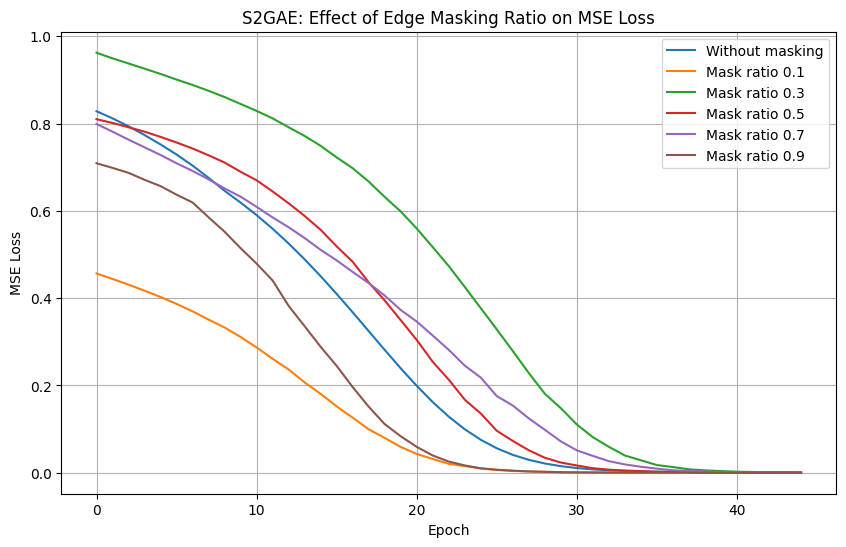

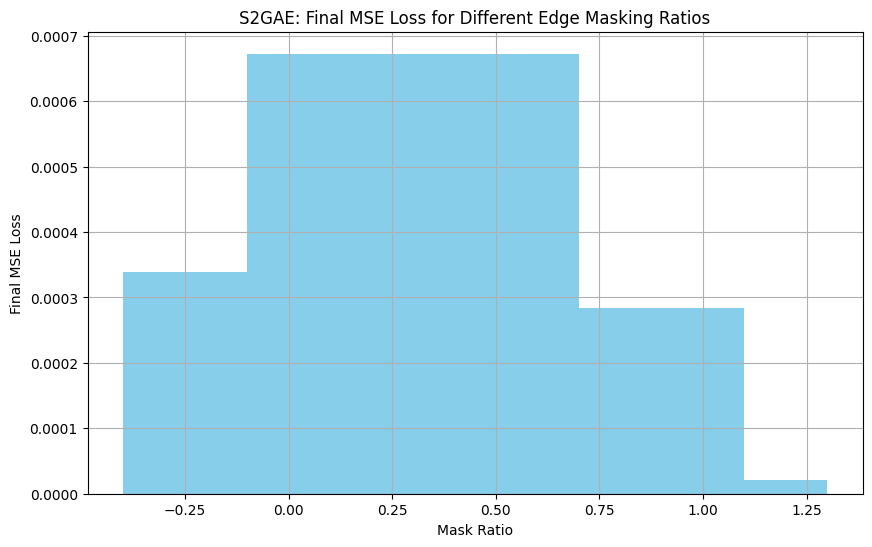

Test Edge Reconstruction Error: 5.873329428141005e-06
Test Loss: 5.873329428141005e-06
Predicting for mask ratio: 0.0
Training with mask ratio: 0.0
Epoch 0, Loss: 0.8072843551635742
Epoch 10, Loss: 0.697113037109375
Epoch 20, Loss: 0.5798028707504272
Epoch 30, Loss: 0.31314119696617126
Epoch 40, Loss: 0.011925198137760162
Predicting for mask ratio: 0.1
Training with mask ratio: 0.1
Epoch 0, Loss: 0.931836724281311
Epoch 10, Loss: 0.7541309595108032
Epoch 20, Loss: 0.260619580745697
Epoch 30, Loss: 0.004279694054275751
Epoch 40, Loss: 7.155143248382956e-05
Predicting for mask ratio: 0.3
Training with mask ratio: 0.3
Epoch 0, Loss: 0.425650030374527
Epoch 10, Loss: 0.30219170451164246
Epoch 20, Loss: 0.08094345778226852
Epoch 30, Loss: 0.0028504440560936928
Epoch 40, Loss: 0.00010676459351088852
Predicting for mask ratio: 0.5
Training with mask ratio: 0.5
Epoch 0, Loss: 0.8225591778755188
Epoch 10, Loss: 0.6536094546318054
Epoch 20, Loss: 0.36481890082359314
Epoch 30, Loss: 0.06895127892

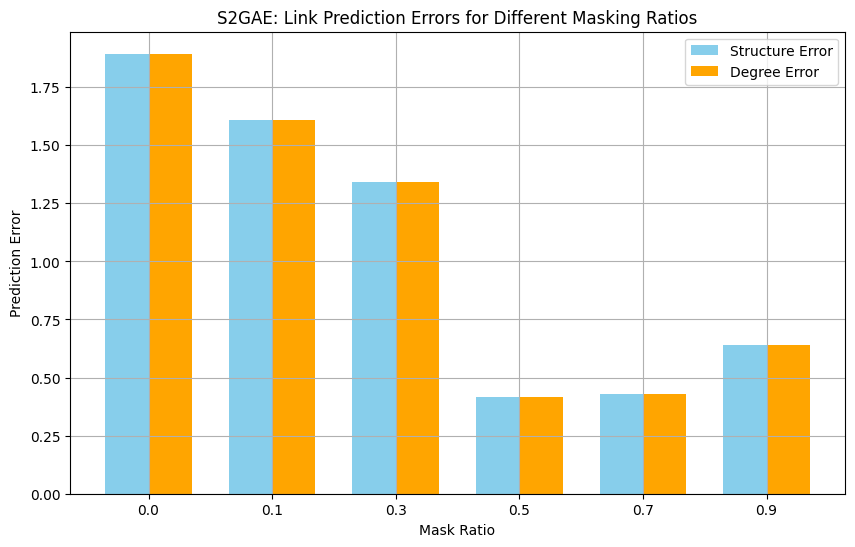

Visualizing encoded features for mask ratio: 0.0


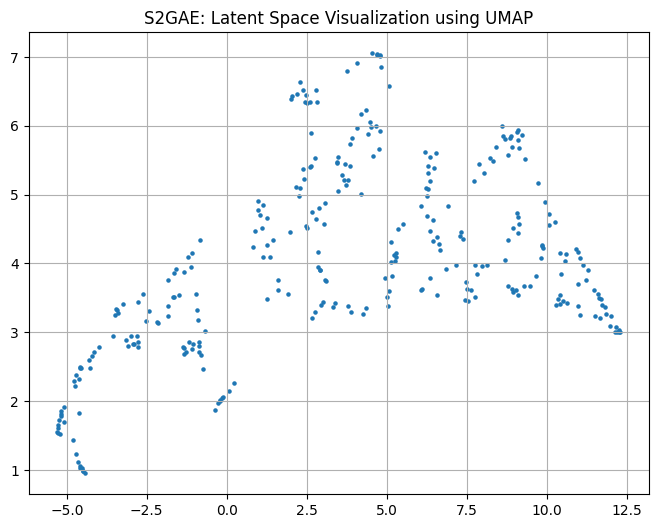

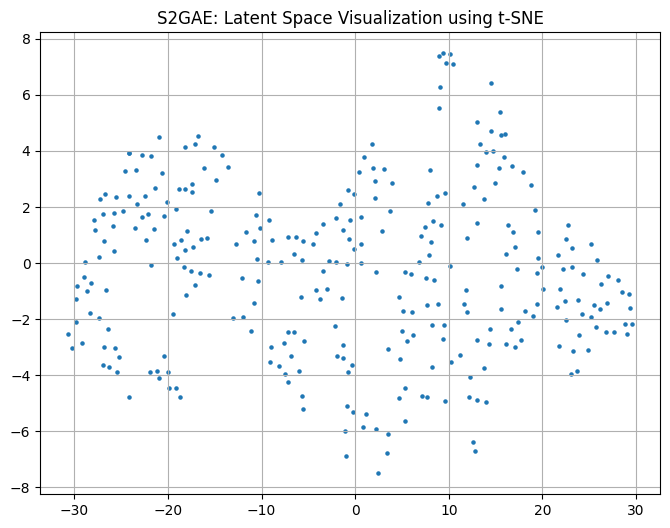

Visualizing encoded features for mask ratio: 0.1


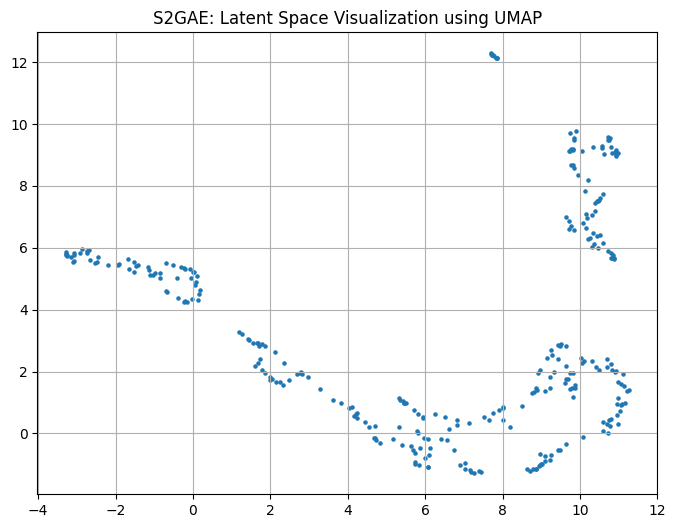

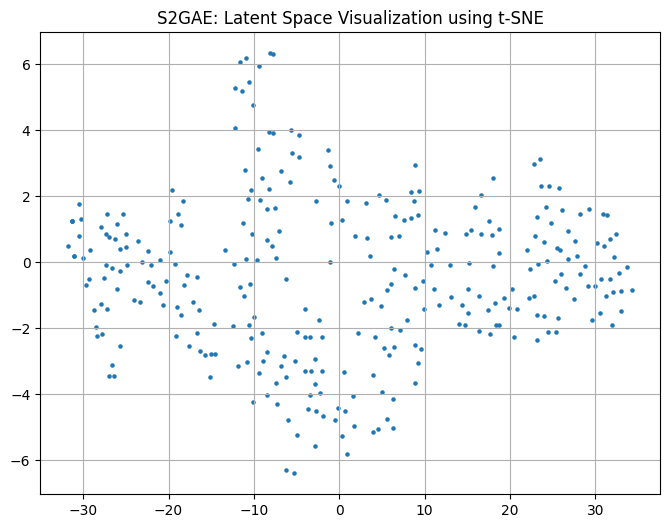

Visualizing encoded features for mask ratio: 0.3


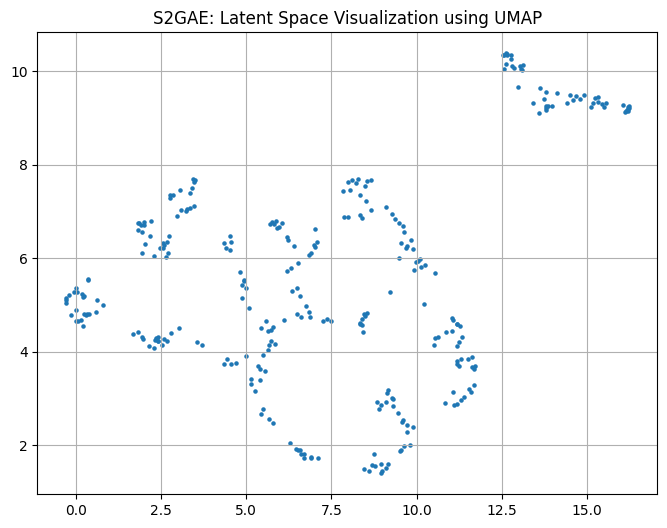

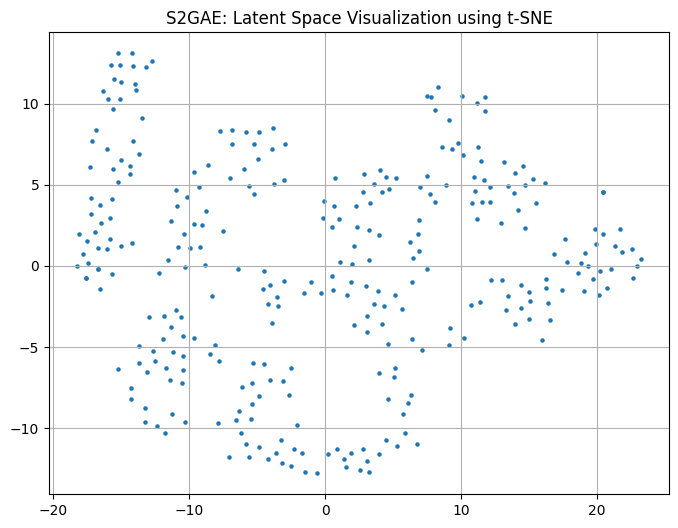

Visualizing encoded features for mask ratio: 0.5


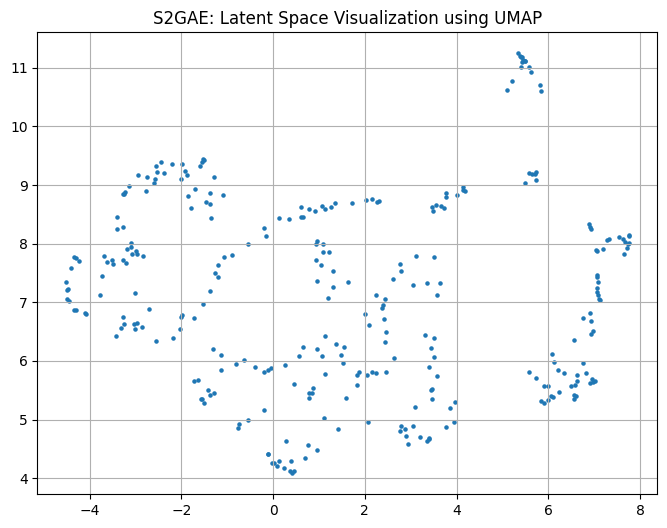

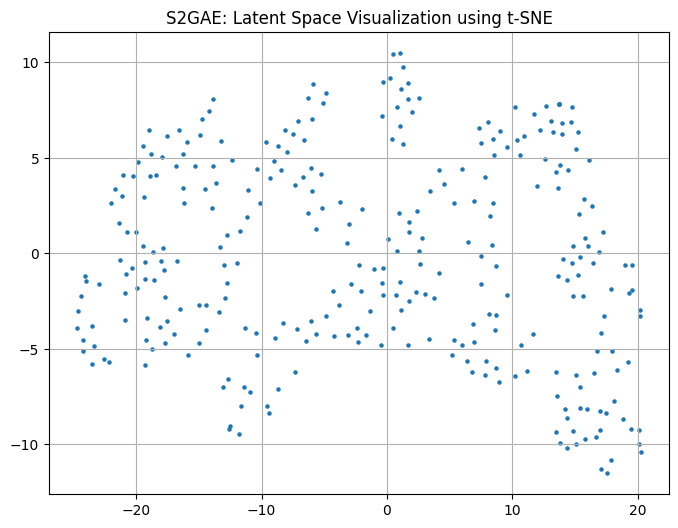

Visualizing encoded features for mask ratio: 0.7


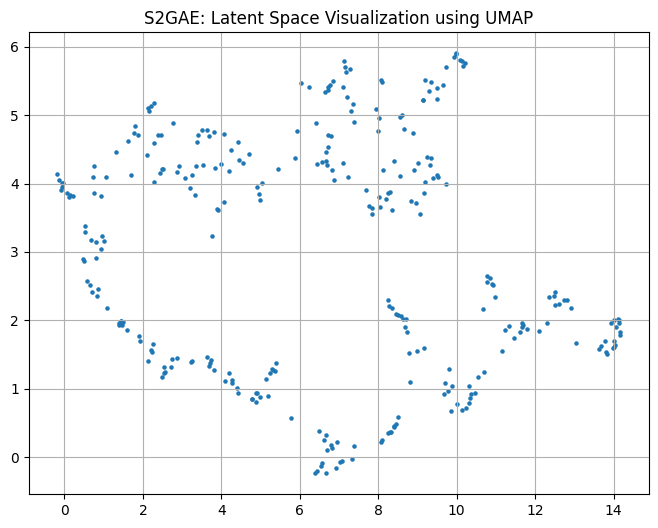

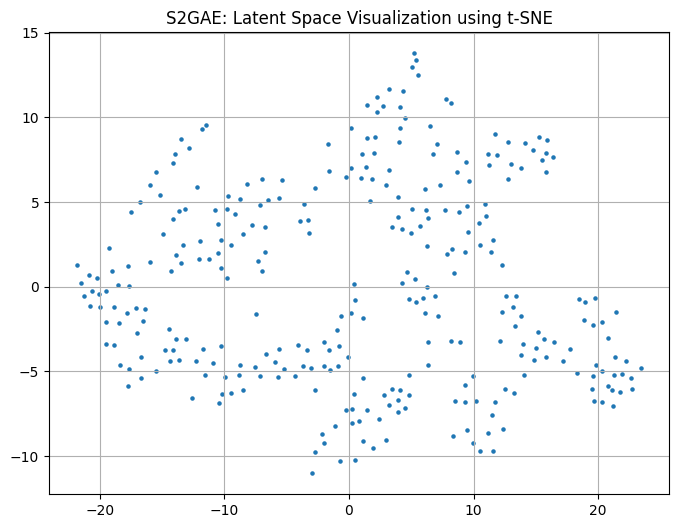

Visualizing encoded features for mask ratio: 0.9


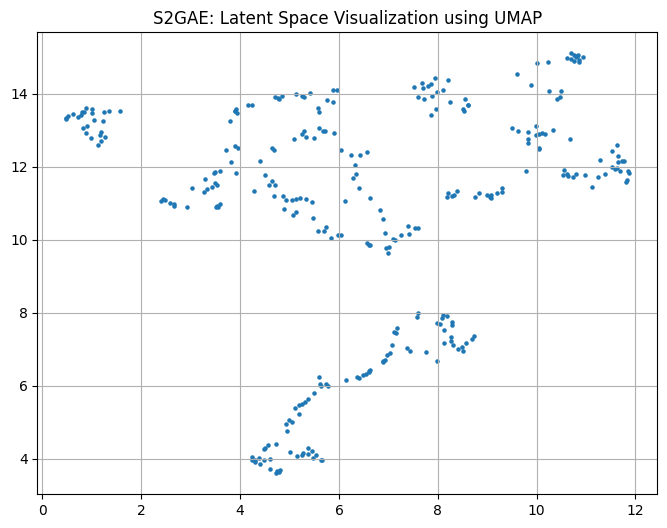

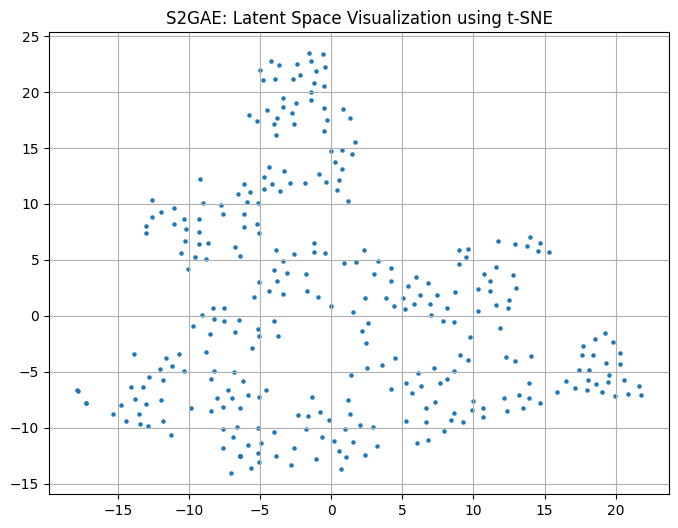

In [ ]:
import torch
import networkx as nx
import numpy as np
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import umap
from sklearn.manifold import TSNE

CUSTOM_EPOCHS = 45

# Generowanie losowego grafu Erdos-Renyi
num_nodes = 312
prob = 0.1
G = nx.erdos_renyi_graph(num_nodes, prob)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
data = Data(x=x, edge_index=edge_index)

## Podział na zbiór treningowy i testowy
def split_edges(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    # Wygenerowanie losowego permutacji indeksów
    perm = torch.randperm(num_edges)
    test_size = int(num_edges * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm[:test_size]]
    train_edge_index = edge_index[:, perm[test_size:]]

    # Utworzenie dwóch obiektów Data: jeden dla treningu, drugi dla testowania
    train_data = Data(x=data.x, edge_index=train_edge_index)
    test_data = Data(x=data.x, edge_index=test_edge_index)

    return train_data, test_data

train_data, test_data = split_edges(data, test_ratio=0.2)

## Implementacja Autoenkodera Grafowego S2GAE
class S2GAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(S2GAE, self).__init__()

        # Enkoder z dwoma warstwami GCN
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

        # Dekoder z korelacją krzyżową do rekonstrukcji krawędzi
        self.cross_correlation_decoder = nn.Sequential(
            nn.Linear(out_channels * 3, out_channels * 2),  # Update input size to match actual concatenated size
            nn.ReLU(),
            nn.Linear(out_channels * 2, 1)  # Output size of 1 to predict edge existence
        )

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

    def decode(self, z, edge_index):
        row, col = edge_index
        # Combine node embeddings from both endpoints of edges
        h_e = torch.cat([z[row] * z[col], z[row], z[col]], dim=1)  # Ensure concatenation results in the expected size
        return self.cross_correlation_decoder(h_e).squeeze()

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        edge_reconstruction = self.decode(z, edge_index)
        return edge_reconstruction

## Funkcja do maskowania krawędzi w trybie direction-aware
def mask_edges(data, mask_ratio, directed=False):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    if directed:
        # Maskowanie krawędzi w sposób skierowany
        mask_indices = random.sample(range(num_edges), num_mask)
    else:
        # Maskowanie krawędzi w sposób nieskierowany
        mask_indices = random.sample(range(num_edges // 2), num_mask // 2)
        mask_indices = mask_indices + mask_indices

    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

## Trening modelu z użyciem zbioru treningowego i ocena na zbiorze testowym
def train_and_evaluate(in_channels, out_channels, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross Entropy for link prediction

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        # Inicjalizacja nowego modelu dla każdego mask_ratio
        model = S2GAE(in_channels=in_channels, out_channels=out_channels)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio, directed=True) if ratio > 0 else train_data
            edge_reconstruction = model(masked_train_data.x, masked_train_data.edge_index)

            # Przygotowanie prawdziwych etykiet dla krawędzi
            edge_labels = torch.ones(masked_train_data.edge_index.size(1))

            # Funkcja straty: rekonstrukcja krawędzi
            loss = criterion(edge_reconstruction, edge_labels)

            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())
            # print(f'Epoch {epoch}, Loss: {loss.item()}')
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
    return results, model

# Funkcja do oceny modelu na zbiorze testowym
def evaluate_on_test(model, test_data):
    model.eval()  # Przełącz model na tryb ewaluacji
    with torch.no_grad():  # Wyłącz gradienty podczas testowania
        # Zakoduj dane testowe
        z = model.encode(test_data.x, test_data.edge_index)

        # Dekodowanie krawędzi
        edge_reconstruction = model.decode(z, test_data.edge_index)

        # Obliczenie błędu predykcji dla rekonstrukcji krawędzi
        edge_labels = torch.ones(test_data.edge_index.size(1))
        error = torch.nn.functional.binary_cross_entropy_with_logits(edge_reconstruction, edge_labels).item()

        print(f'Test Edge Reconstruction Error: {error}')
        return error

## Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('S2GAE: Effect of Edge Masking Ratio on MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def final_loss_comparison(results):
    final_losses = {ratio: losses[-1] for ratio, losses in results.items()}
    ratios = list(final_losses.keys())
    losses = list(final_losses.values())

    plt.figure(figsize=(10, 6))
    plt.bar(ratios, losses, color='skyblue')
    plt.xlabel('Mask Ratio')
    plt.ylabel('Final MSE Loss')
    plt.title('S2GAE: Final MSE Loss for Different Edge Masking Ratios')
    plt.grid(True)
    plt.show()

def predict(model, data):
    model.eval()  # Przełącz model na tryb ewaluacji
    with torch.no_grad():
        # Zakodowanie cech węzłów
        z = model.encode(data.x, data.edge_index)

        # Dekodowanie krawędzi
        pred_structure = model.decode(z, data.edge_index)  # Predykcja krawędzi

        # W tej wersji nie rekonstruujemy pełnej macierzy sąsiedztwa, tylko pracujemy na krawędziach
        pred_degree = pred_structure  # Tutaj predykcja dla struktury i stopni jest taka sama

        return pred_structure, pred_degree, z

def calculate_prediction_error(pred_structure, pred_degree, data):
    # Zakładamy, że pred_structure i pred_degree mają teraz rozmiar (num_edges,)
    num_edges = data.edge_index.size(1)

    # Upewnij się, że rozmiary są zgodne
    if pred_structure.size(0) != num_edges:
        print(f"Expected {num_edges} edges, but got {pred_structure.size(0)} predictions.")
        raise ValueError("Mismatch in the number of edge predictions.")

    if pred_degree.size(0) != num_edges:
        print(f"Expected {num_edges} edges, but got {pred_degree.size(0)} predictions.")
        raise ValueError("Mismatch in the number of edge predictions.")

    # Tworzymy prawdziwe etykiety krawędzi (1 dla obecności krawędzi)
    edge_labels = torch.ones(num_edges)  # Zakładamy, że wszystkie krawędzie są obecne

    # Obliczamy błąd rekonstrukcji krawędzi
    structure_error = torch.nn.functional.mse_loss(pred_structure, edge_labels).item()
    degree_error = torch.nn.functional.mse_loss(pred_degree, edge_labels).item()

    return structure_error, degree_error

def visualize_latent_space(z, method='UMAP'):
    if method == 'UMAP':
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(z.numpy())
    elif method == 't-SNE':
        tsne = TSNE(n_components=2)
        embedding = tsne.fit_transform(z.numpy())

    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
    plt.title(f'S2GAE: Latent Space Visualization using {method}')
    plt.grid(True)
    plt.show()

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]  # Including 0.0 for no masking
results, trained_model = train_and_evaluate(
    in_channels=train_data.num_features,
    out_channels=2,
    train_data=train_data,
    test_data=test_data,
    mask_ratios=mask_ratios,
    epochs=CUSTOM_EPOCHS
)

# Wizualizacja wyników treningu
plot_results(results)
final_loss_comparison(results)

# Ewaluacja na zbiorze testowym
test_loss = evaluate_on_test(trained_model, test_data)
print(f"Test Loss: {test_loss}")

# Predykcja na nieolabelowanych danych
unlabeled_data = test_data  # W rzeczywistości użyj innego zestawu nieolabelowanych danych

predictions = {}
errors = {}
encoded_representations = {}

# Iteracja po różnych współczynnikach maskowania
for ratio in mask_ratios:
    print(f'Predicting for mask ratio: {ratio}')

    # Inicjalizacja modelu
    model = S2GAE(in_channels=data.num_features, out_channels=2)

    # Trening modelu na danych treningowych
    train_and_evaluate(train_data.num_features, 2, train_data, test_data, [ratio], epochs=CUSTOM_EPOCHS)

    # Predykcja na danych nieolabelowanych
    pred_structure, pred_degree, encoded_rep = predict(model, unlabeled_data)

    # Obliczanie błędów predykcji
    structure_error, degree_error = calculate_prediction_error(pred_structure, pred_degree, unlabeled_data)
    errors[ratio] = (structure_error, degree_error)

    # Zapisywanie zakodowanych reprezentacji
    encoded_representations[ratio] = encoded_rep

# Wizualizacja błędów predykcji
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(errors))
index_shifted = index + bar_width

plt.bar(index, [e[0] for e in errors.values()], width=bar_width, label='Structure Error', color='skyblue')
plt.bar(index_shifted, [e[1] for e in errors.values()], width=bar_width, label='Degree Error', color='orange')
plt.xlabel('Mask Ratio')
plt.ylabel('Prediction Error')
plt.title('S2GAE: Link Prediction Errors for Different Masking Ratios')
plt.xticks(index + bar_width / 2, [str(r) for r in errors.keys()])
plt.legend()
plt.grid(True)
plt.show()

# Wizualizacja zakodowanych reprezentacji z użyciem UMAP i t-SNE
for ratio, z in encoded_representations.items():
    print(f"Visualizing encoded features for mask ratio: {ratio}")

    # Wizualizacja UMAP
    visualize_latent_space(z, method='UMAP')

    # Wizualizacja t-SNE
    visualize_latent_space(z, method='t-SNE')


## Klasyfikacja społeczności

Training with mask ratio: 0.0
Epoch 0, Loss: 1.167097568511963
Epoch 10, Loss: 1.062778115272522
Epoch 20, Loss: 0.9730777144432068
Epoch 30, Loss: 0.8357311487197876
Epoch 40, Loss: 0.6149006485939026
Epoch 50, Loss: 0.3827492296695709
Epoch 60, Loss: 0.22249087691307068
Epoch 70, Loss: 0.13638927042484283
Epoch 80, Loss: 0.09140391647815704
Epoch 90, Loss: 0.06582068651914597
Epoch 100, Loss: 0.04979812353849411
Epoch 110, Loss: 0.03904255852103233
Epoch 120, Loss: 0.031434789299964905
Epoch 130, Loss: 0.02583402767777443
Epoch 140, Loss: 0.021570276468992233
Training with mask ratio: 0.1
Epoch 0, Loss: 1.1376066207885742
Epoch 10, Loss: 1.0604480504989624
Epoch 20, Loss: 0.9344136714935303
Epoch 30, Loss: 0.7570354342460632
Epoch 40, Loss: 0.5785783529281616
Epoch 50, Loss: 0.4845840334892273
Epoch 60, Loss: 0.4125328063964844
Epoch 70, Loss: 0.31820353865623474
Epoch 80, Loss: 0.2195414900779724
Epoch 90, Loss: 0.1378803849220276
Epoch 100, Loss: 0.0946822538971901
Epoch 110, Loss:

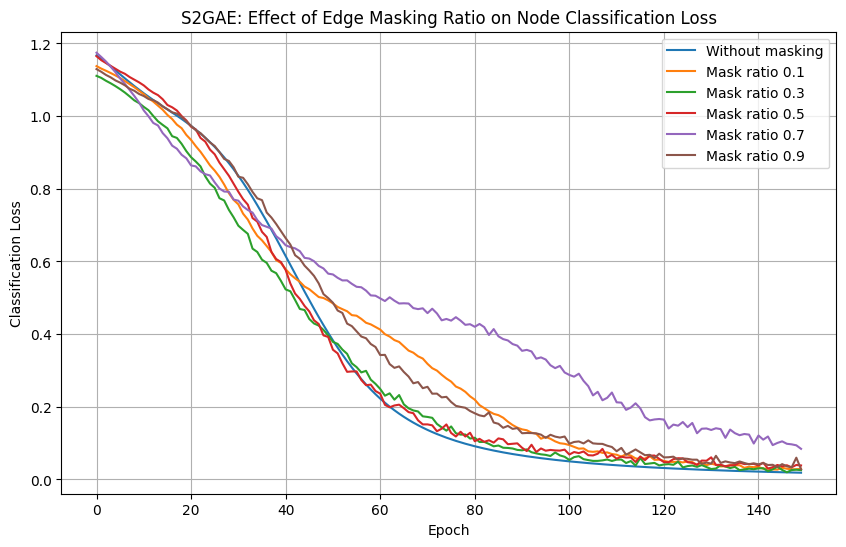

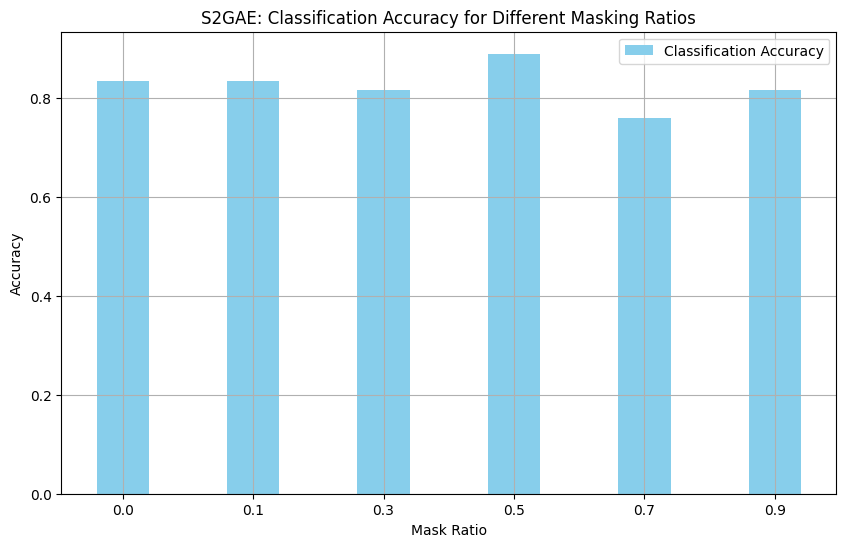

In [ ]:
import torch
import networkx as nx
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import numpy as np

CUSTOM_EPOCHS = 150

# Generowanie grafu za pomocą Stochastic Block Model (SBM)
num_nodes = 270
sizes = [90, 90, 90]  # Liczba węzłów w każdej społeczności (bloku)
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.25]]  # Macierz prawdopodobieństw krawędzi między społecznościami
G = nx.stochastic_block_model(sizes, probs)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
labels = torch.zeros(num_nodes, dtype=torch.long)

# Przydzielanie etykiet węzłom na podstawie społeczności
for i, size in enumerate(sizes):
    labels[sum(sizes[:i]):sum(sizes[:i+1])] = i

data = Data(x=x, edge_index=edge_index, y=labels)

# Podział na zbiór treningowy i testowy
def split_edges_and_nodes(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    num_nodes = data.num_nodes

    # Wygenerowanie losowego permutacji indeksów
    perm_edges = torch.randperm(num_edges)
    perm_nodes = torch.randperm(num_nodes)
    test_size_edges = int(num_edges * test_ratio)
    test_size_nodes = int(num_nodes * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm_edges[:test_size_edges]]
    train_edge_index = edge_index[:, perm_edges[test_size_edges:]]
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[perm_nodes[test_size_nodes:]] = True
    test_mask[perm_nodes[:test_size_nodes]] = True

    train_data = Data(x=data.x, edge_index=train_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)
    test_data = Data(x=data.x, edge_index=test_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)

    return train_data, test_data

train_data, test_data = split_edges_and_nodes(data, test_ratio=0.2)

# Implementacja Autoenkodera Grafowego S2GAE
class S2GAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(S2GAE, self).__init__()

        # Enkoder z dwoma warstwami GCN
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

        # Dekoder z korelacją krzyżową do rekonstrukcji krawędzi
        self.cross_correlation_decoder = nn.Sequential(
            nn.Linear(out_channels * 3, out_channels * 2),  # Update input size to match actual concatenated size
            nn.ReLU(),
            nn.Linear(out_channels * 2, 1)  # Output size of 1 to predict edge existence
        )

        # Dekoder do klasyfikacji węzłów
        self.node_classifier = nn.Linear(out_channels, 3)  # Assuming 3 classes for node classification

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

    def decode(self, z, edge_index):
        row, col = edge_index
        # Combine node embeddings from both endpoints of edges
        h_e = torch.cat([z[row] * z[col], z[row], z[col]], dim=1)  # Ensure concatenation results in the expected size
        return self.cross_correlation_decoder(h_e).squeeze()

    def classify(self, z):
        return self.node_classifier(z)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        node_classification = self.classify(z)
        return node_classification

# Trening i ocena modelu
def train_and_evaluate_s2gae(in_channels, out_channels, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    criterion = torch.nn.CrossEntropyLoss()
    models = {}  # Store trained models for each mask ratio

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        model = S2GAE(in_channels=in_channels, out_channels=out_channels)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            node_classification = model(masked_train_data.x, masked_train_data.edge_index)

            loss = criterion(node_classification[masked_train_data.train_mask], masked_train_data.y[masked_train_data.train_mask])
            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

        models[ratio] = model  # Save the trained model for this ratio

    return results, models

def predict(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        node_classification = model.classify(z)
        return node_classification, z

def evaluate_on_test(model, test_data):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        node_classification, z = predict(model, test_data)
        test_loss = criterion(node_classification[test_data.test_mask], test_data.y[test_data.test_mask]).item()

        # Obliczanie dokładności
        _, pred = node_classification[test_data.test_mask].max(dim=1)
        correct = pred.eq(test_data.y[test_data.test_mask]).sum().item()
        accuracy = correct / test_data.test_mask.sum().item()

        print(f'Test Loss: {test_loss}')
        print(f'Test Accuracy: {accuracy:.4f}')

    return test_loss, accuracy

def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('Classification Loss')
    plt.title('S2GAE: Effect of Edge Masking Ratio on Node Classification Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Funkcja obliczająca błąd predykcji (przykładowa)
def calculate_prediction_error(pred, data):
    _, predicted_classes = pred.max(dim=1)
    correct = predicted_classes.eq(data.y).sum().item()
    accuracy = correct / data.y.size(0)
    error = 1 - accuracy  # Przykład błędu jako 1 - accuracy
    return error

def calculate_classification_accuracy(pred_logits, data):
    # Get the predicted classes by selecting the index of the highest logit value
    _, predicted_classes = pred_logits.max(dim=1)

    # Compare predicted classes to true labels
    correct = predicted_classes[data.test_mask].eq(data.y[data.test_mask]).sum().item()

    # Calculate accuracy
    accuracy = correct / data.test_mask.sum().item()

    return accuracy


# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
results, trained_models = train_and_evaluate_s2gae(
    in_channels=train_data.num_features,
    out_channels=2,
    train_data=train_data,
    test_data=test_data,
    mask_ratios=mask_ratios,
    epochs=CUSTOM_EPOCHS
)

plot_results(results)

# Predykcja na nieolabelowanych danych
unlabeled_data = test_data  # W rzeczywistym scenariuszu użyj innego zbioru danych

accuracies = {}
for ratio in mask_ratios:
    model = trained_models[ratio]  # Use the trained model for the specific mask ratio

    # Forward pass to get predictions
    node_classification = model(unlabeled_data.x, unlabeled_data.edge_index)

    # Calculate classification accuracy
    classification_accuracy = calculate_classification_accuracy(node_classification, unlabeled_data)

    accuracies[ratio] = classification_accuracy

# Prepare data for visualization of classification accuracy
plt.figure(figsize=(10, 6))
bar_width = 0.4
index = np.arange(len(accuracies))

# Plot classification accuracy for each mask ratio
plt.bar(index, list(accuracies.values()), width=bar_width, color='skyblue', label='Classification Accuracy')
plt.xlabel('Mask Ratio')
plt.ylabel('Accuracy')
plt.title('S2GAE: Classification Accuracy for Different Masking Ratios')
plt.xticks(index, [str(ratio) for ratio in accuracies.keys()])
plt.legend()
plt.grid(True)
plt.show()

## 500 węzłów - Przewidywanie połaczeń

Training with mask ratio: 0.0
Epoch 0, Loss: 0.5746141076087952
Epoch 10, Loss: 0.45778024196624756
Epoch 20, Loss: 0.2655424177646637
Epoch 30, Loss: 0.03548197075724602
Epoch 40, Loss: 0.0006634190795011818
Training with mask ratio: 0.1
Epoch 0, Loss: 0.6197630167007446
Epoch 10, Loss: 0.40761297941207886
Epoch 20, Loss: 0.107319675385952
Epoch 30, Loss: 0.004219295457005501
Epoch 40, Loss: 0.00026949934544973075
Training with mask ratio: 0.3
Epoch 0, Loss: 0.8104802370071411
Epoch 10, Loss: 0.6111502647399902
Epoch 20, Loss: 0.1502266675233841
Epoch 30, Loss: 0.00430548470467329
Epoch 40, Loss: 0.00021879078121855855
Training with mask ratio: 0.5
Epoch 0, Loss: 0.5131980776786804
Epoch 10, Loss: 0.4743252396583557
Epoch 20, Loss: 0.43817952275276184
Epoch 30, Loss: 0.40491530299186707
Epoch 40, Loss: 0.3745225965976715
Training with mask ratio: 0.7
Epoch 0, Loss: 0.5711390376091003
Epoch 10, Loss: 0.4523667097091675
Epoch 20, Loss: 0.3005329966545105
Epoch 30, Loss: 0.06194566562771

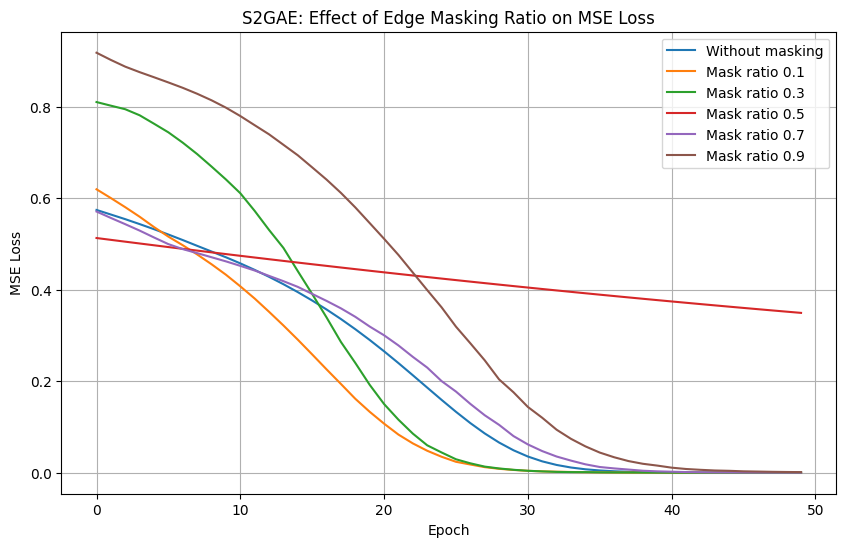

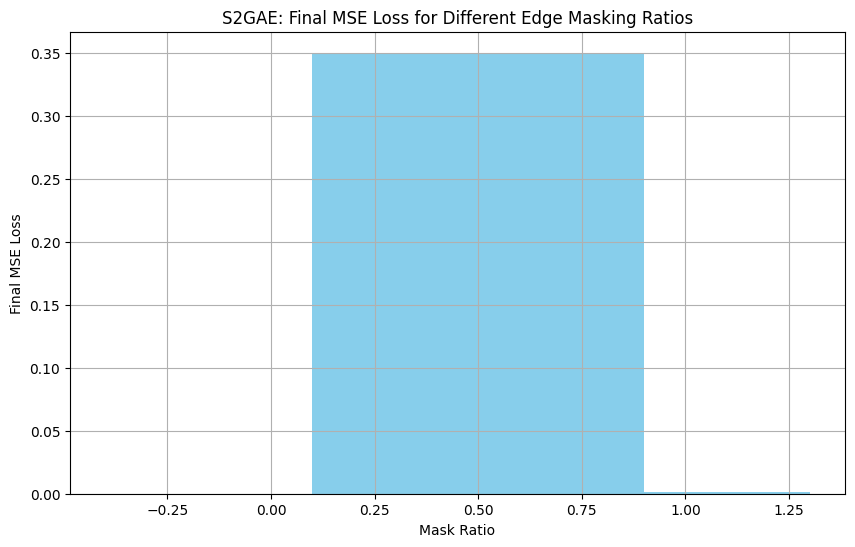

Test Edge Reconstruction Error: 0.0006046099006198347
Test Loss: 0.0006046099006198347
Predicting for mask ratio: 0.0
Training with mask ratio: 0.0
Epoch 0, Loss: 0.8717079162597656
Epoch 10, Loss: 0.5695542097091675
Epoch 20, Loss: 0.05773978680372238
Epoch 30, Loss: 0.0006708693690598011
Epoch 40, Loss: 4.259965498931706e-05
Predicting for mask ratio: 0.1
Training with mask ratio: 0.1
Epoch 0, Loss: 0.7764817476272583
Epoch 10, Loss: 0.6960377097129822
Epoch 20, Loss: 0.5846958756446838
Epoch 30, Loss: 0.37994077801704407
Epoch 40, Loss: 0.06789302825927734
Predicting for mask ratio: 0.3
Training with mask ratio: 0.3
Epoch 0, Loss: 0.46712034940719604
Epoch 10, Loss: 0.33154943585395813
Epoch 20, Loss: 0.16153916716575623
Epoch 30, Loss: 0.029960155487060547
Epoch 40, Loss: 0.0024571691174060106
Predicting for mask ratio: 0.5
Training with mask ratio: 0.5
Epoch 0, Loss: 0.9143627285957336
Epoch 10, Loss: 0.638131856918335
Epoch 20, Loss: 0.05721435695886612
Epoch 30, Loss: 0.00046258

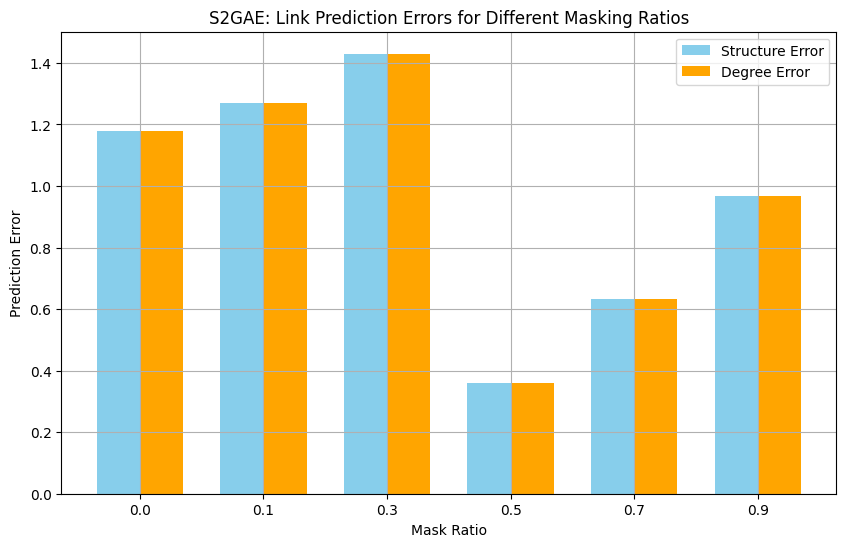

Visualizing encoded features for mask ratio: 0.0


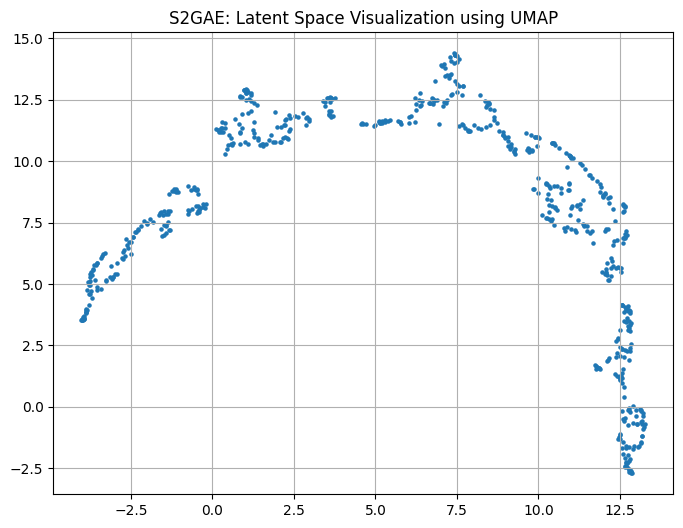

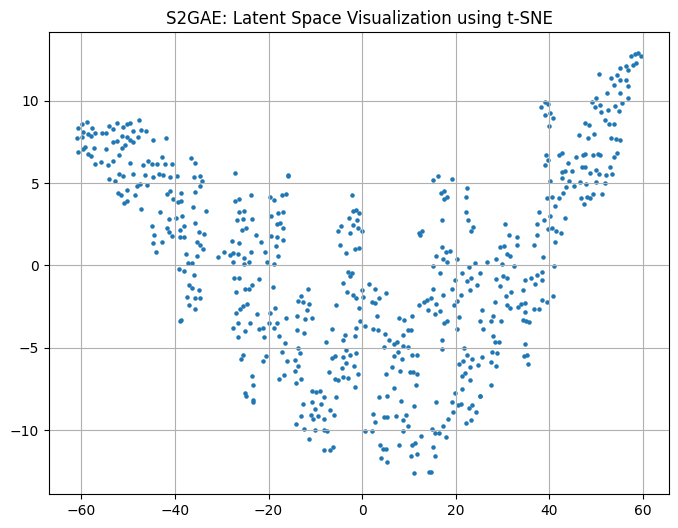

Visualizing encoded features for mask ratio: 0.1


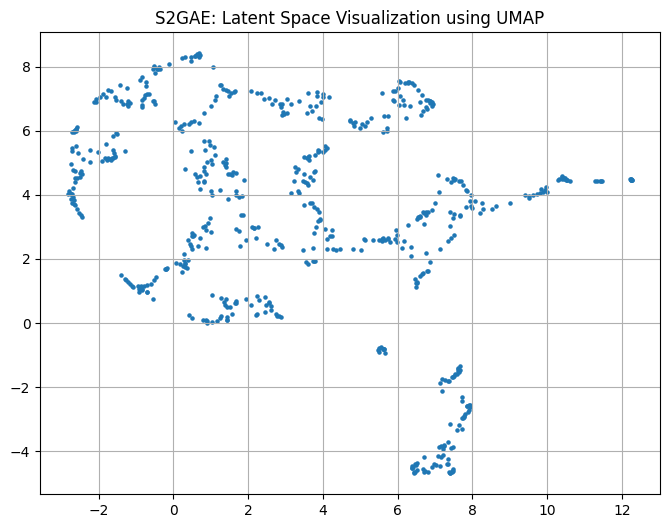

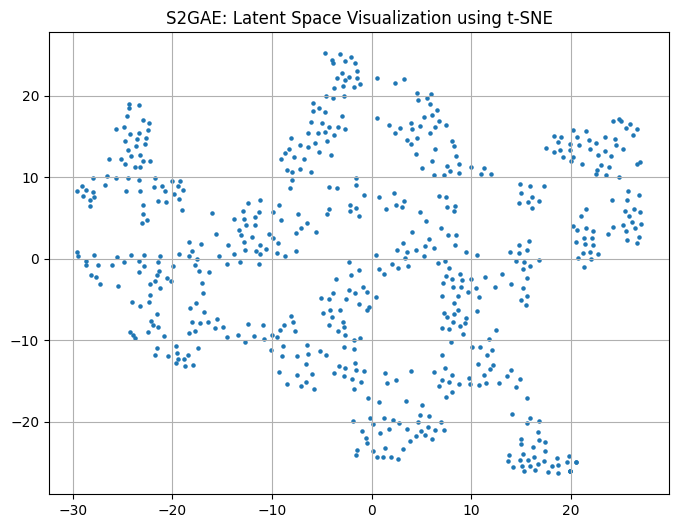

Visualizing encoded features for mask ratio: 0.3


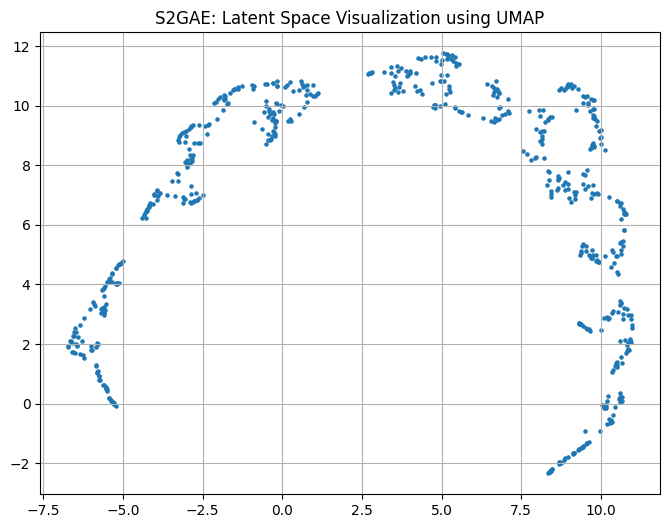

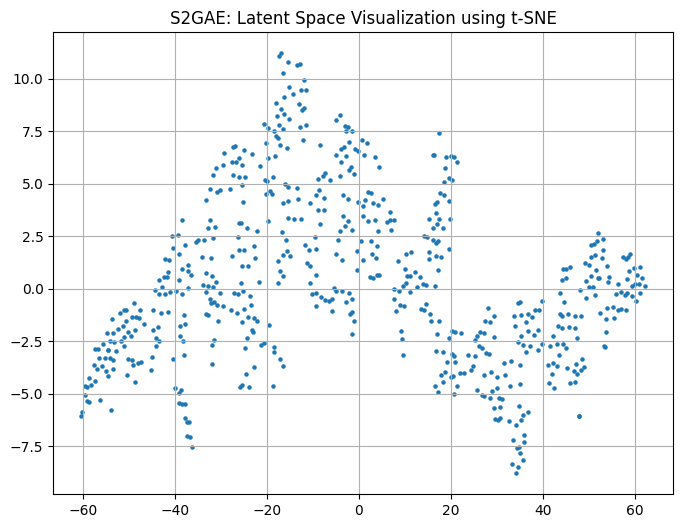

Visualizing encoded features for mask ratio: 0.5


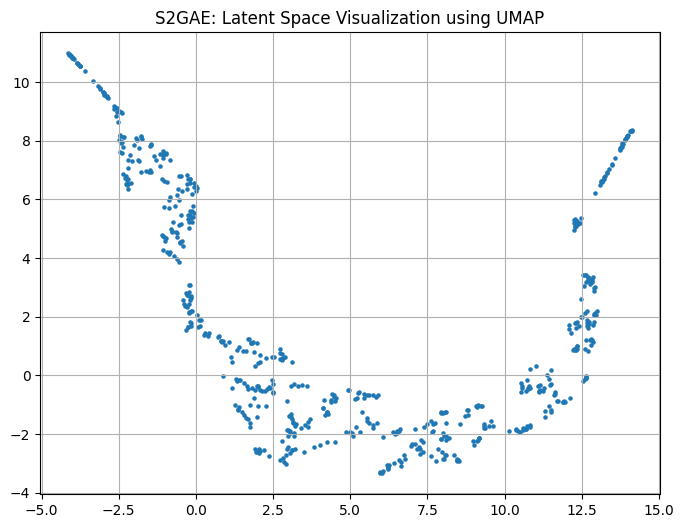

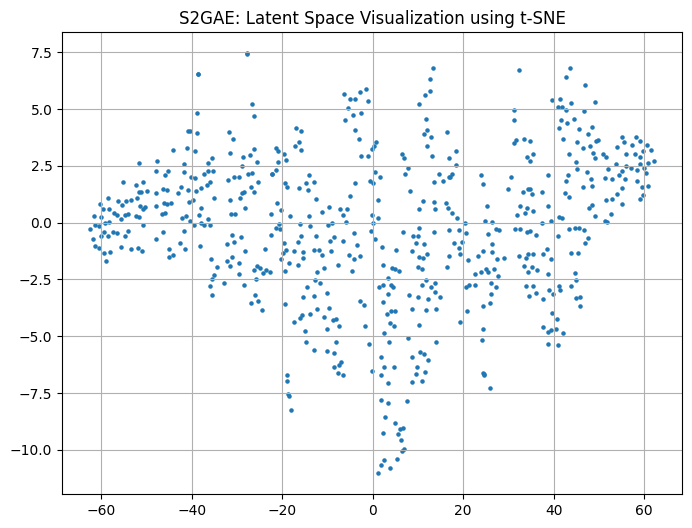

Visualizing encoded features for mask ratio: 0.7


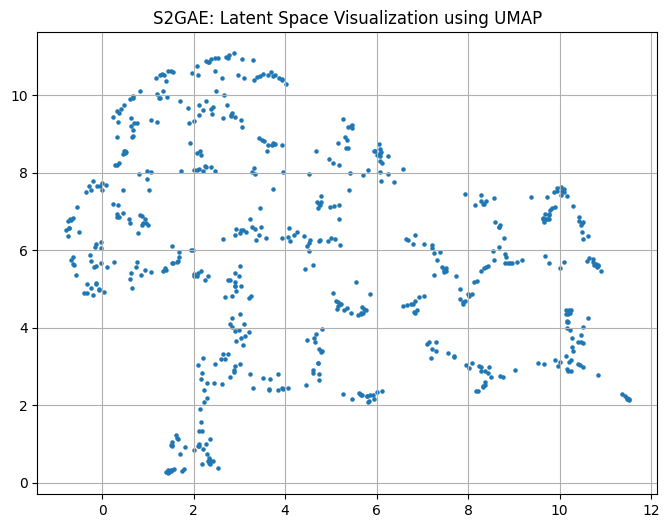

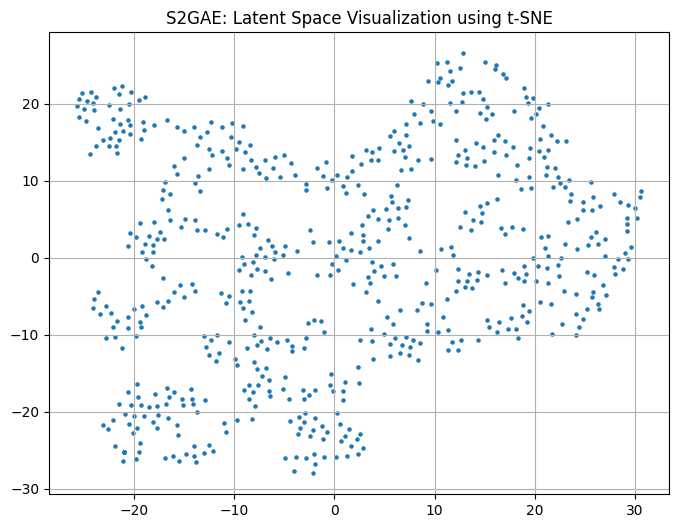

Visualizing encoded features for mask ratio: 0.9


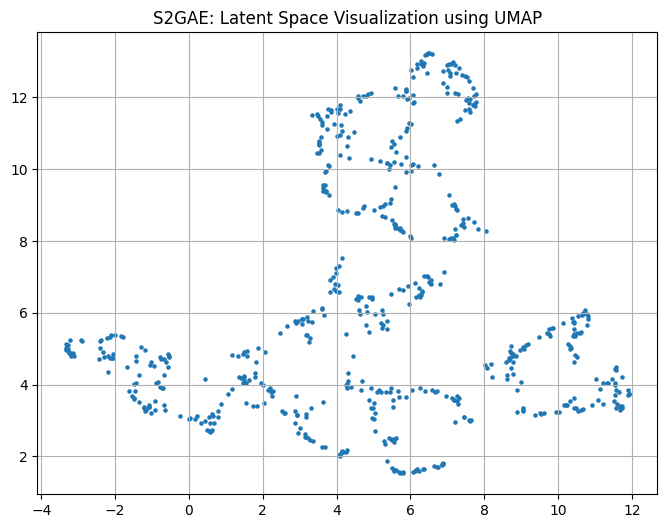

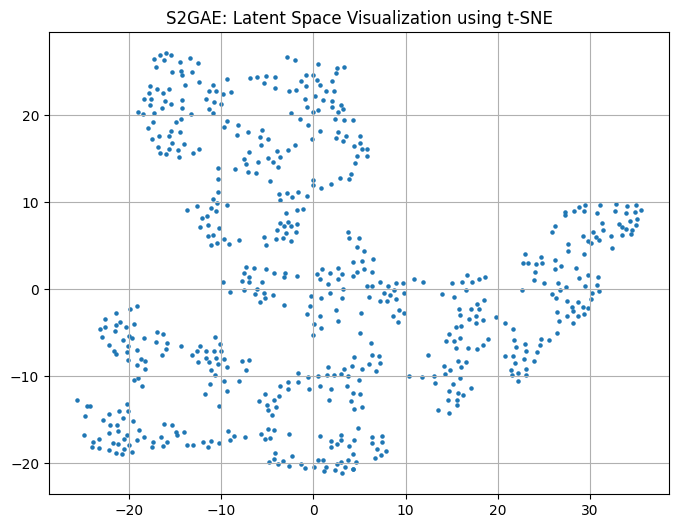

In [ ]:
import torch
import networkx as nx
import numpy as np
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import umap
from sklearn.manifold import TSNE

CUSTOM_EPOCHS = 50

# Generowanie losowego grafu Erdos-Renyi
num_nodes = 625
prob = 0.1
G = nx.erdos_renyi_graph(num_nodes, prob)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
data = Data(x=x, edge_index=edge_index)

## Podział na zbiór treningowy i testowy
def split_edges(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    # Wygenerowanie losowego permutacji indeksów
    perm = torch.randperm(num_edges)
    test_size = int(num_edges * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm[:test_size]]
    train_edge_index = edge_index[:, perm[test_size:]]

    # Utworzenie dwóch obiektów Data: jeden dla treningu, drugi dla testowania
    train_data = Data(x=data.x, edge_index=train_edge_index)
    test_data = Data(x=data.x, edge_index=test_edge_index)

    return train_data, test_data

train_data, test_data = split_edges(data, test_ratio=0.2)

## Implementacja Autoenkodera Grafowego S2GAE
class S2GAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(S2GAE, self).__init__()

        # Enkoder z dwoma warstwami GCN
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

        # Dekoder z korelacją krzyżową do rekonstrukcji krawędzi
        self.cross_correlation_decoder = nn.Sequential(
            nn.Linear(out_channels * 3, out_channels * 2),  # Update input size to match actual concatenated size
            nn.ReLU(),
            nn.Linear(out_channels * 2, 1)  # Output size of 1 to predict edge existence
        )

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

    def decode(self, z, edge_index):
        row, col = edge_index
        # Combine node embeddings from both endpoints of edges
        h_e = torch.cat([z[row] * z[col], z[row], z[col]], dim=1)  # Ensure concatenation results in the expected size
        return self.cross_correlation_decoder(h_e).squeeze()

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        edge_reconstruction = self.decode(z, edge_index)
        return edge_reconstruction

## Funkcja do maskowania krawędzi w trybie direction-aware
def mask_edges(data, mask_ratio, directed=False):
    edge_index = data.edge_index.t().tolist()
    num_edges = len(edge_index)
    num_mask = int(num_edges * mask_ratio)

    if directed:
        # Maskowanie krawędzi w sposób skierowany
        mask_indices = random.sample(range(num_edges), num_mask)
    else:
        # Maskowanie krawędzi w sposób nieskierowany
        mask_indices = random.sample(range(num_edges // 2), num_mask // 2)
        mask_indices = mask_indices + mask_indices

    mask_indices = torch.tensor(mask_indices, dtype=torch.long)

    masked_edges = [edge for i, edge in enumerate(edge_index) if i not in mask_indices]
    masked_edge_index = torch.tensor(masked_edges, dtype=torch.long).t().contiguous()

    data.edge_index = masked_edge_index
    return data

## Trening modelu z użyciem zbioru treningowego i ocena na zbiorze testowym
def train_and_evaluate(in_channels, out_channels, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross Entropy for link prediction

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        # Inicjalizacja nowego modelu dla każdego mask_ratio
        model = S2GAE(in_channels=in_channels, out_channels=out_channels)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio, directed=True) if ratio > 0 else train_data
            edge_reconstruction = model(masked_train_data.x, masked_train_data.edge_index)

            # Przygotowanie prawdziwych etykiet dla krawędzi
            edge_labels = torch.ones(masked_train_data.edge_index.size(1))

            # Funkcja straty: rekonstrukcja krawędzi
            loss = criterion(edge_reconstruction, edge_labels)

            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())
            # print(f'Epoch {epoch}, Loss: {loss.item()}')
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
    return results, model

# Funkcja do oceny modelu na zbiorze testowym
def evaluate_on_test(model, test_data):
    model.eval()  # Przełącz model na tryb ewaluacji
    with torch.no_grad():  # Wyłącz gradienty podczas testowania
        # Zakoduj dane testowe
        z = model.encode(test_data.x, test_data.edge_index)

        # Dekodowanie krawędzi
        edge_reconstruction = model.decode(z, test_data.edge_index)

        # Obliczenie błędu predykcji dla rekonstrukcji krawędzi
        edge_labels = torch.ones(test_data.edge_index.size(1))
        error = torch.nn.functional.binary_cross_entropy_with_logits(edge_reconstruction, edge_labels).item()

        print(f'Test Edge Reconstruction Error: {error}')
        return error

## Analiza wyników i wizualizacje
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('S2GAE: Effect of Edge Masking Ratio on MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def final_loss_comparison(results):
    final_losses = {ratio: losses[-1] for ratio, losses in results.items()}
    ratios = list(final_losses.keys())
    losses = list(final_losses.values())

    plt.figure(figsize=(10, 6))
    plt.bar(ratios, losses, color='skyblue')
    plt.xlabel('Mask Ratio')
    plt.ylabel('Final MSE Loss')
    plt.title('S2GAE: Final MSE Loss for Different Edge Masking Ratios')
    plt.grid(True)
    plt.show()

def predict(model, data):
    model.eval()  # Przełącz model na tryb ewaluacji
    with torch.no_grad():
        # Zakodowanie cech węzłów
        z = model.encode(data.x, data.edge_index)

        # Dekodowanie krawędzi
        pred_structure = model.decode(z, data.edge_index)  # Predykcja krawędzi

        # W tej wersji nie rekonstruujemy pełnej macierzy sąsiedztwa, tylko pracujemy na krawędziach
        pred_degree = pred_structure  # Tutaj predykcja dla struktury i stopni jest taka sama

        return pred_structure, pred_degree, z

def calculate_prediction_error(pred_structure, pred_degree, data):
    # Zakładamy, że pred_structure i pred_degree mają teraz rozmiar (num_edges,)
    num_edges = data.edge_index.size(1)

    # Upewnij się, że rozmiary są zgodne
    if pred_structure.size(0) != num_edges:
        print(f"Expected {num_edges} edges, but got {pred_structure.size(0)} predictions.")
        raise ValueError("Mismatch in the number of edge predictions.")

    if pred_degree.size(0) != num_edges:
        print(f"Expected {num_edges} edges, but got {pred_degree.size(0)} predictions.")
        raise ValueError("Mismatch in the number of edge predictions.")

    # Tworzymy prawdziwe etykiety krawędzi (1 dla obecności krawędzi)
    edge_labels = torch.ones(num_edges)  # Zakładamy, że wszystkie krawędzie są obecne

    # Obliczamy błąd rekonstrukcji krawędzi
    structure_error = torch.nn.functional.mse_loss(pred_structure, edge_labels).item()
    degree_error = torch.nn.functional.mse_loss(pred_degree, edge_labels).item()

    return structure_error, degree_error

def visualize_latent_space(z, method='UMAP'):
    if method == 'UMAP':
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(z.numpy())
    elif method == 't-SNE':
        tsne = TSNE(n_components=2)
        embedding = tsne.fit_transform(z.numpy())

    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
    plt.title(f'S2GAE: Latent Space Visualization using {method}')
    plt.grid(True)
    plt.show()

# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]  # Including 0.0 for no masking
results, trained_model = train_and_evaluate(
    in_channels=train_data.num_features,
    out_channels=2,
    train_data=train_data,
    test_data=test_data,
    mask_ratios=mask_ratios,
    epochs=CUSTOM_EPOCHS
)

# Wizualizacja wyników treningu
plot_results(results)
final_loss_comparison(results)

# Ewaluacja na zbiorze testowym
test_loss = evaluate_on_test(trained_model, test_data)
print(f"Test Loss: {test_loss}")

# Predykcja na nieolabelowanych danych
unlabeled_data = test_data  # W rzeczywistości użyj innego zestawu nieolabelowanych danych

predictions = {}
errors = {}
encoded_representations = {}

# Iteracja po różnych współczynnikach maskowania
for ratio in mask_ratios:
    print(f'Predicting for mask ratio: {ratio}')

    # Inicjalizacja modelu
    model = S2GAE(in_channels=data.num_features, out_channels=2)

    # Trening modelu na danych treningowych
    train_and_evaluate(train_data.num_features, 2, train_data, test_data, [ratio], epochs=CUSTOM_EPOCHS)

    # Predykcja na danych nieolabelowanych
    pred_structure, pred_degree, encoded_rep = predict(model, unlabeled_data)

    # Obliczanie błędów predykcji
    structure_error, degree_error = calculate_prediction_error(pred_structure, pred_degree, unlabeled_data)
    errors[ratio] = (structure_error, degree_error)

    # Zapisywanie zakodowanych reprezentacji
    encoded_representations[ratio] = encoded_rep

# Wizualizacja błędów predykcji
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(errors))
index_shifted = index + bar_width

plt.bar(index, [e[0] for e in errors.values()], width=bar_width, label='Structure Error', color='skyblue')
plt.bar(index_shifted, [e[1] for e in errors.values()], width=bar_width, label='Degree Error', color='orange')
plt.xlabel('Mask Ratio')
plt.ylabel('Prediction Error')
plt.title('S2GAE: Link Prediction Errors for Different Masking Ratios')
plt.xticks(index + bar_width / 2, [str(r) for r in errors.keys()])
plt.legend()
plt.grid(True)
plt.show()

# Wizualizacja zakodowanych reprezentacji z użyciem UMAP i t-SNE
for ratio, z in encoded_representations.items():
    print(f"Visualizing encoded features for mask ratio: {ratio}")

    # Wizualizacja UMAP
    visualize_latent_space(z, method='UMAP')

    # Wizualizacja t-SNE
    visualize_latent_space(z, method='t-SNE')


## Klasyfikacja społeczności

Training with mask ratio: 0.0
Epoch 0, Loss: 1.186806559562683
Epoch 10, Loss: 1.0426887273788452
Epoch 20, Loss: 0.9026516079902649
Epoch 30, Loss: 0.701124906539917
Epoch 40, Loss: 0.47088828682899475
Epoch 50, Loss: 0.2823016941547394
Epoch 60, Loss: 0.1706787347793579
Epoch 70, Loss: 0.11357797682285309
Epoch 80, Loss: 0.08343065530061722
Epoch 90, Loss: 0.06567063927650452
Epoch 100, Loss: 0.05394855886697769
Epoch 110, Loss: 0.045379091054201126
Epoch 120, Loss: 0.03872677683830261
Epoch 130, Loss: 0.03335009887814522
Epoch 140, Loss: 0.028924860060214996
Training with mask ratio: 0.1
Epoch 0, Loss: 1.1331586837768555
Epoch 10, Loss: 1.0146478414535522
Epoch 20, Loss: 0.8273674845695496
Epoch 30, Loss: 0.6117308735847473
Epoch 40, Loss: 0.4543255865573883
Epoch 50, Loss: 0.334445059299469
Epoch 60, Loss: 0.24952498078346252
Epoch 70, Loss: 0.1802806407213211
Epoch 80, Loss: 0.13478200137615204
Epoch 90, Loss: 0.10251966118812561
Epoch 100, Loss: 0.08459371328353882
Epoch 110, Los

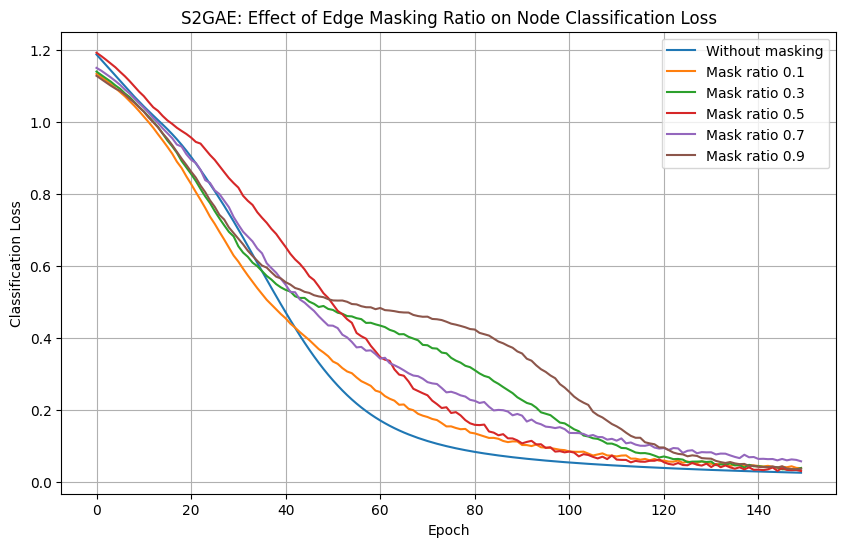

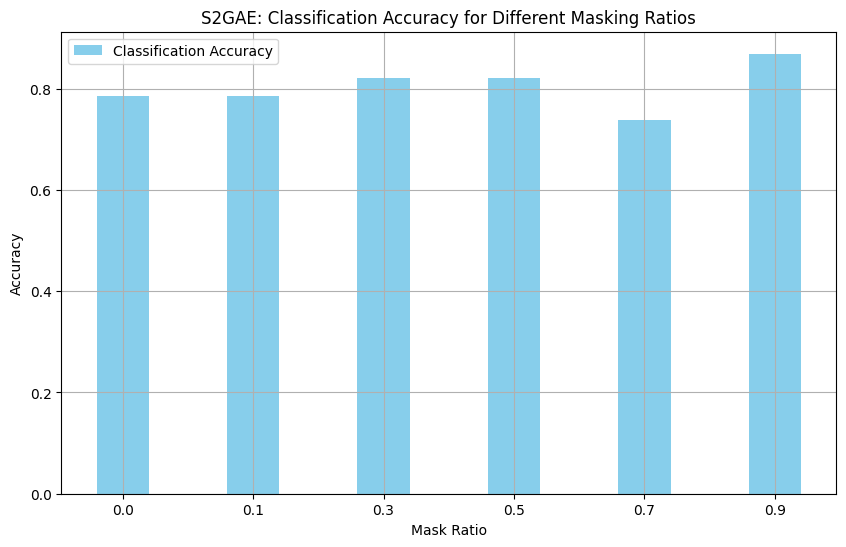

In [ ]:
import torch
import networkx as nx
from torch_geometric.data import Data
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import numpy as np

CUSTOM_EPOCHS = 150

# Generowanie grafu za pomocą Stochastic Block Model (SBM)
num_nodes = 423
sizes = [141, 141, 141]  # Liczba węzłów w każdej społeczności (bloku)
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.25]]  # Macierz prawdopodobieństw krawędzi między społecznościami
G = nx.stochastic_block_model(sizes, probs)

# Przekształcenie grafu NetworkX do formatu akceptowanego przez PyG
edge_index = torch.tensor(list(G.edges)).t().contiguous()
x = torch.eye(num_nodes, dtype=torch.float)  # Feature matrix (identity matrix)
labels = torch.zeros(num_nodes, dtype=torch.long)

# Przydzielanie etykiet węzłom na podstawie społeczności
for i, size in enumerate(sizes):
    labels[sum(sizes[:i]):sum(sizes[:i+1])] = i

data = Data(x=x, edge_index=edge_index, y=labels)

# Podział na zbiór treningowy i testowy
def split_edges_and_nodes(data, test_ratio=0.2):
    edge_index = data.edge_index
    num_edges = edge_index.size(1)
    num_nodes = data.num_nodes

    # Wygenerowanie losowego permutacji indeksów
    perm_edges = torch.randperm(num_edges)
    perm_nodes = torch.randperm(num_nodes)
    test_size_edges = int(num_edges * test_ratio)
    test_size_nodes = int(num_nodes * test_ratio)

    # Podział indeksów na zbiór testowy i treningowy
    test_edge_index = edge_index[:, perm_edges[:test_size_edges]]
    train_edge_index = edge_index[:, perm_edges[test_size_edges:]]
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[perm_nodes[test_size_nodes:]] = True
    test_mask[perm_nodes[:test_size_nodes]] = True

    train_data = Data(x=data.x, edge_index=train_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)
    test_data = Data(x=data.x, edge_index=test_edge_index, y=data.y, train_mask=train_mask, test_mask=test_mask)

    return train_data, test_data

train_data, test_data = split_edges_and_nodes(data, test_ratio=0.2)

# Implementacja Autoenkodera Grafowego S2GAE
class S2GAE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(S2GAE, self).__init__()

        # Enkoder z dwoma warstwami GCN
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

        # Dekoder z korelacją krzyżową do rekonstrukcji krawędzi
        self.cross_correlation_decoder = nn.Sequential(
            nn.Linear(out_channels * 3, out_channels * 2),  # Update input size to match actual concatenated size
            nn.ReLU(),
            nn.Linear(out_channels * 2, 1)  # Output size of 1 to predict edge existence
        )

        # Dekoder do klasyfikacji węzłów
        self.node_classifier = nn.Linear(out_channels, 3)  # Assuming 3 classes for node classification

    def encode(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

    def decode(self, z, edge_index):
        row, col = edge_index
        # Combine node embeddings from both endpoints of edges
        h_e = torch.cat([z[row] * z[col], z[row], z[col]], dim=1)  # Ensure concatenation results in the expected size
        return self.cross_correlation_decoder(h_e).squeeze()

    def classify(self, z):
        return self.node_classifier(z)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        node_classification = self.classify(z)
        return node_classification

# Trening i ocena modelu
def train_and_evaluate_s2gae(in_channels, out_channels, train_data, test_data, mask_ratios, epochs=100):
    results = defaultdict(list)
    criterion = torch.nn.CrossEntropyLoss()
    models = {}  # Store trained models for each mask ratio

    for ratio in mask_ratios:
        print(f'Training with mask ratio: {ratio}')

        model = S2GAE(in_channels=in_channels, out_channels=out_channels)
        optimizer = Adam(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            masked_train_data = mask_edges(train_data.clone(), ratio) if ratio > 0 else train_data
            node_classification = model(masked_train_data.x, masked_train_data.edge_index)

            loss = criterion(node_classification[masked_train_data.train_mask], masked_train_data.y[masked_train_data.train_mask])
            loss.backward()
            optimizer.step()

            results[ratio].append(loss.item())

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

        models[ratio] = model  # Save the trained model for this ratio

    return results, models

def predict(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        node_classification = model.classify(z)
        return node_classification, z

def evaluate_on_test(model, test_data):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        node_classification, z = predict(model, test_data)
        test_loss = criterion(node_classification[test_data.test_mask], test_data.y[test_data.test_mask]).item()

        # Obliczanie dokładności
        _, pred = node_classification[test_data.test_mask].max(dim=1)
        correct = pred.eq(test_data.y[test_data.test_mask]).sum().item()
        accuracy = correct / test_data.test_mask.sum().item()

        print(f'Test Loss: {test_loss}')
        print(f'Test Accuracy: {accuracy:.4f}')

    return test_loss, accuracy

def plot_results(results):
    plt.figure(figsize=(10, 6))

    for ratio, losses in results.items():
        if ratio == 0.0:
            plt.plot(losses, label=f'Without masking')
        else:
            plt.plot(losses, label=f'Mask ratio {ratio}')

    plt.xlabel('Epoch')
    plt.ylabel('Classification Loss')
    plt.title('S2GAE: Effect of Edge Masking Ratio on Node Classification Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Funkcja obliczająca błąd predykcji (przykładowa)
def calculate_prediction_error(pred, data):
    _, predicted_classes = pred.max(dim=1)
    correct = predicted_classes.eq(data.y).sum().item()
    accuracy = correct / data.y.size(0)
    error = 1 - accuracy  # Przykład błędu jako 1 - accuracy
    return error

def calculate_classification_accuracy(pred_logits, data):
    # Get the predicted classes by selecting the index of the highest logit value
    _, predicted_classes = pred_logits.max(dim=1)

    # Compare predicted classes to true labels
    correct = predicted_classes[data.test_mask].eq(data.y[data.test_mask]).sum().item()

    # Calculate accuracy
    accuracy = correct / data.test_mask.sum().item()

    return accuracy


# Trening i ocena modelu
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
results, trained_models = train_and_evaluate_s2gae(
    in_channels=train_data.num_features,
    out_channels=2,
    train_data=train_data,
    test_data=test_data,
    mask_ratios=mask_ratios,
    epochs=CUSTOM_EPOCHS
)

plot_results(results)

# Predykcja na nieolabelowanych danych
unlabeled_data = test_data  # W rzeczywistym scenariuszu użyj innego zbioru danych

accuracies = {}
for ratio in mask_ratios:
    model = trained_models[ratio]  # Use the trained model for the specific mask ratio

    # Forward pass to get predictions
    node_classification = model(unlabeled_data.x, unlabeled_data.edge_index)

    # Calculate classification accuracy
    classification_accuracy = calculate_classification_accuracy(node_classification, unlabeled_data)

    accuracies[ratio] = classification_accuracy

# Prepare data for visualization of classification accuracy
plt.figure(figsize=(10, 6))
bar_width = 0.4
index = np.arange(len(accuracies))

# Plot classification accuracy for each mask ratio
plt.bar(index, list(accuracies.values()), width=bar_width, color='skyblue', label='Classification Accuracy')
plt.xlabel('Mask Ratio')
plt.ylabel('Accuracy')
plt.title('S2GAE: Classification Accuracy for Different Masking Ratios')
plt.xticks(index, [str(ratio) for ratio in accuracies.keys()])
plt.legend()
plt.grid(True)
plt.show()